In [1]:
import serre
import numpy as np
import matplotlib.pyplot as plt
import generalFunctions as gF
import cnoidal
import nswe
import muscl2
import nswe_wbmuscl4 as wb4
%matplotlib inline

nan = float('nan')

In [2]:
def openDomainThreeGC(h,hu,BC,dx,t):
    """
    *Function to be passed as "bcfunction" argument for DDM_NSWE
    *Impose classical open boundary conditions in a domain with three ghost cells in each side (necessary for O4).
    *The domain is supposed to be [-L-3*dx, L+3*dx]
    
    *Inputs
        * h, hu : variables to impose the BCs (can be any variable)
        * BC, dx, t : unused in this function
        
    * Outputs :
        * hb,hub : h,hu with BCs
    """
    
    hb = 1.*h
    hub = 1.*hu
    
    hb[0] = h[3]
    hub[0] = hu[3]
    hb[1] = h[3]
    hub[1] = hu[3]
    hb[2] = h[3]
    hub[2] = hu[3]
    
    hb[-1] = h[-4]
    hub[-1] = hu[-4]    
    hb[-2] = h[-4]
    hub[-2] = hu[-4]
    hb[-3] = h[-4]
    hub[-3] = hu[-4]
    
    return hb,hub

In [3]:
def fluxes(h,hu,n):
    """
    *Function to be passed as "fvsolver" argument for DDM_NSWE
    *Impose periodicty to ghost cells and compute the fluxes
    *The domain is supposed to be [-L-3*dx, L+3*dx]
    
    *Inputs
        * h, hu
        * n : unused in this function
        
    * Outputs :
        * fp : fluxes on the cells' interfaces
    """
    
    h0 = np.copy(h)
    u0 = np.copy(hu)
    d0 = np.zeros(n)
    u0 = np.where(h0>1e-10,u0/h0,h0)#hu/h
    
    fp, fm, sc = wb4.fluxes_sources(d0,h0,u0)
    return fp

In [4]:
import nswe_wbmuscl4 as wb4
def fluxes_periodic(h,hu,n):
    nx = h.shape[0]-4
    h0 = np.zeros(nx+6)
    u0 = np.zeros(nx+6)
    d0 = np.zeros(nx+6)

    h0[3:-3] = h[2:-2]
    u0[3:-3] = hu[2:-2] #hu
    u0 = np.where(h0>1e-10,u0/h0,h0)#hu/h
    
    #periodic bcs
    h0[:3] = h0[-6:-3]
    h0[-3:] = h0[3:6]
    u0[:3] = u0[-6:-3]
    u0[-3:] = u0[3:6]
    
    fp, fm, sc = wb4.fluxes_sources(d0,h0,u0)
    return fp

# Validation : José's example

In [5]:
g = 9.81
t0 = 0.0
t = t0
tmax = 5.
q0 = 4.42

xmin = 0.
xmax = 25
nx = 100

x,dx = serre.discretizeSpace(xmin,xmax,nx)

H0 = 2.
d0 = np.where((x<=12.)*(x>=8), 0.2-0.05*(x-10.)**2,0.0)
h = H0-d0
u = q0/h

hall,uall,tall = serre.NSWE(x,h,u,t0,tmax,openDomainThreeGC,None,dx,x.size,vardt = False, dt = 0.05,
                              fvsolver=fluxes, ghostcells=3,fvTimesolver=serre.RK4)

umin = np.amin(uall)
umax = np.amax(uall)
hmin = np.amin(hall)
hmax = np.amax(hall)

CFL = 3.200000


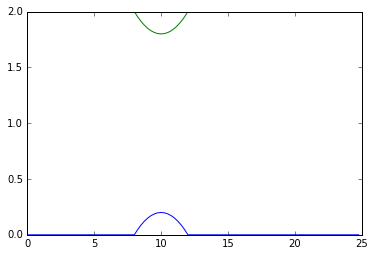

In [6]:
plt.plot(x,d0)
plt.plot(x,h)

In [7]:
hallP = np.copy(hall)
d0all = np.copy(hall)

for i in range (tall.size):
    d0all[:,i] = d0
    hallP[:,i] = hall[:,i] + d0

*** Plotting animation ...



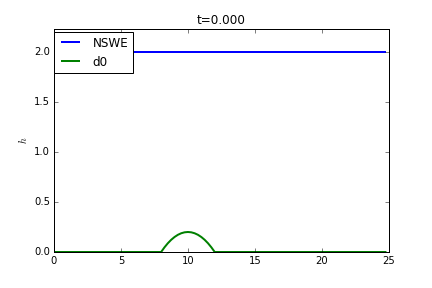
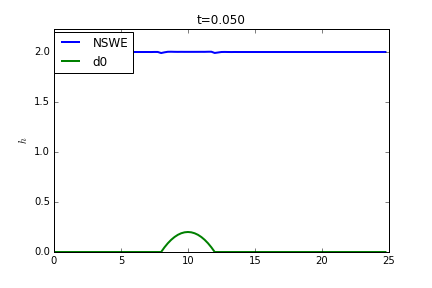
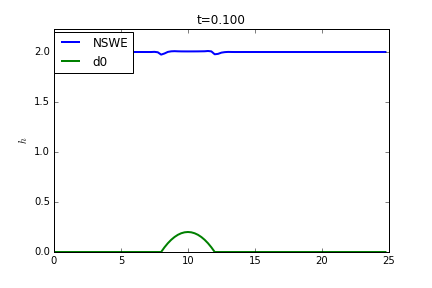
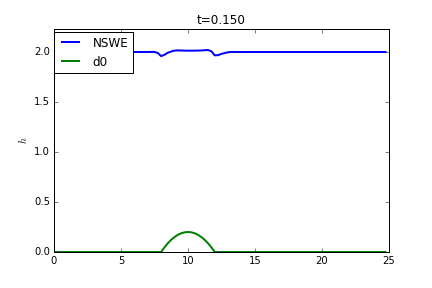
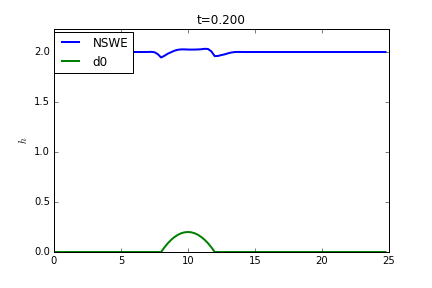
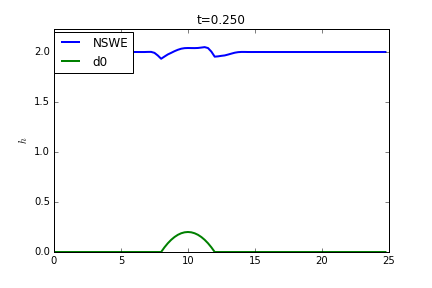
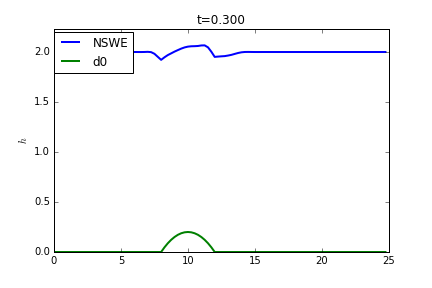
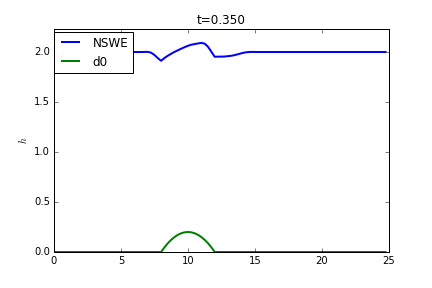
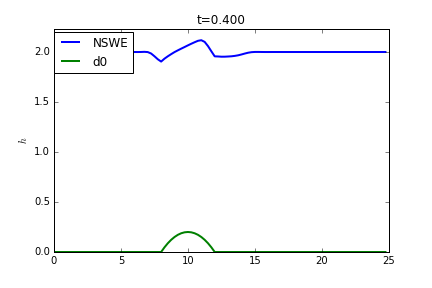
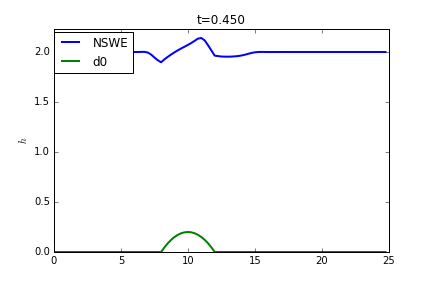
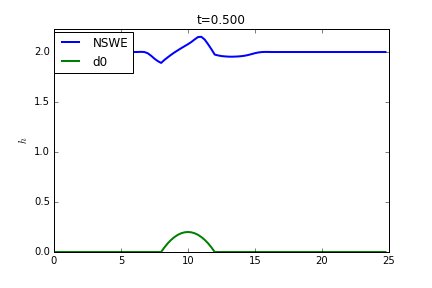
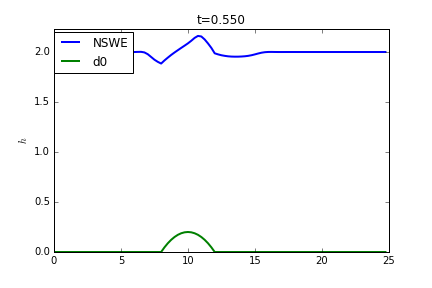
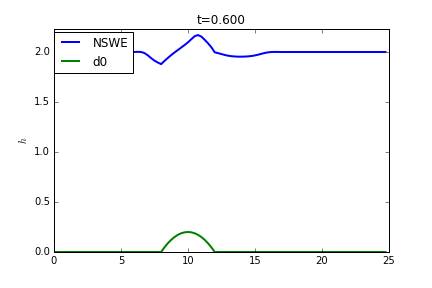
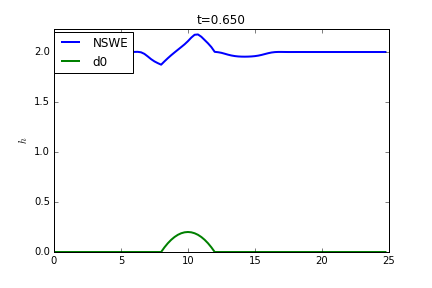
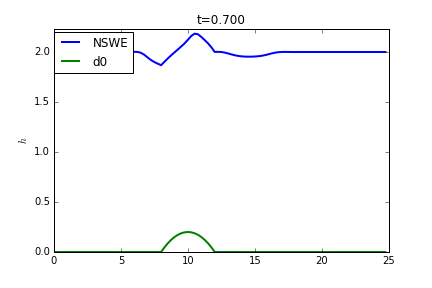
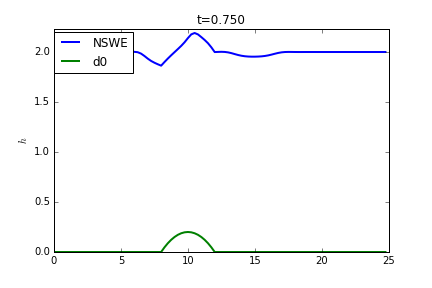
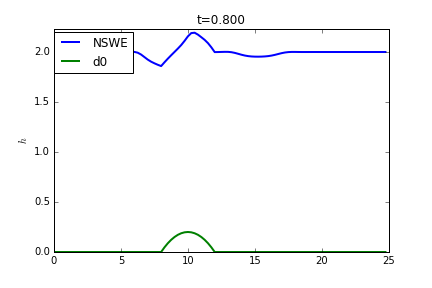
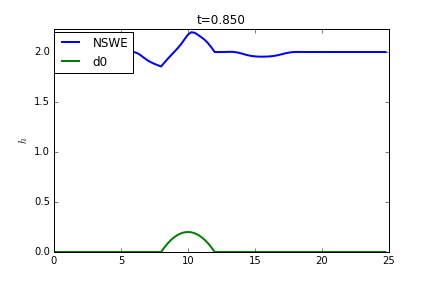
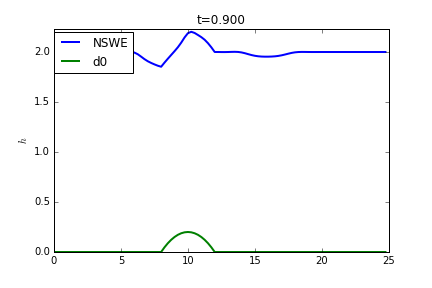
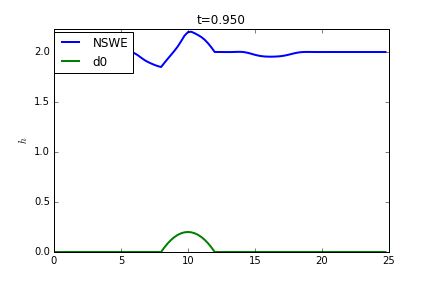
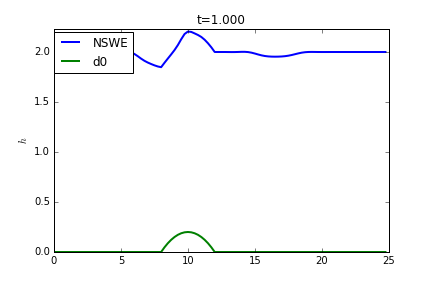
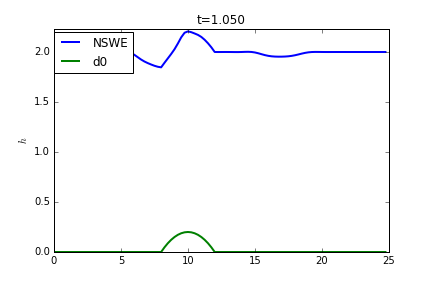
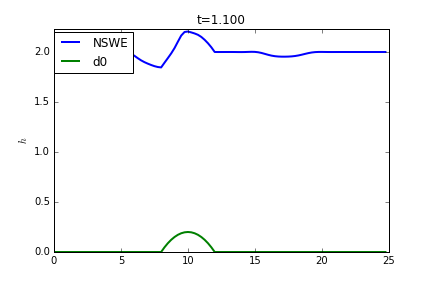
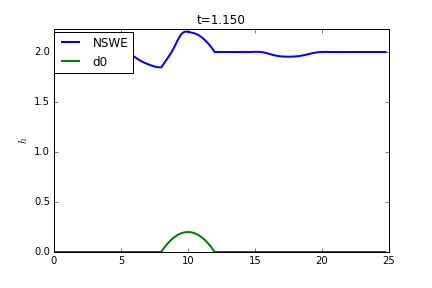
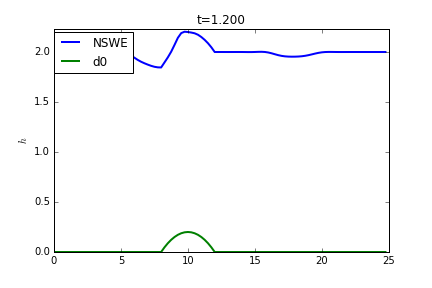
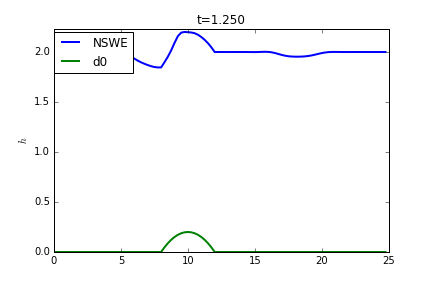
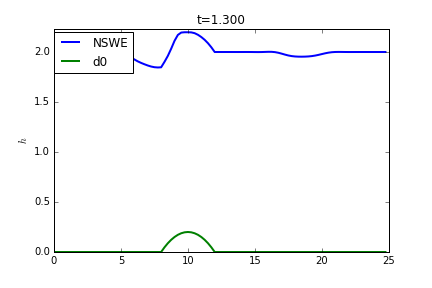
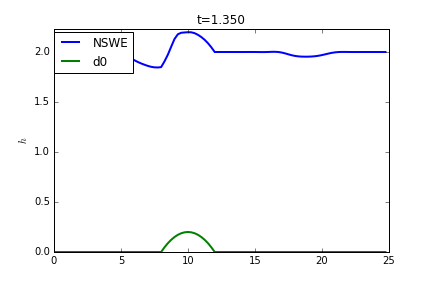
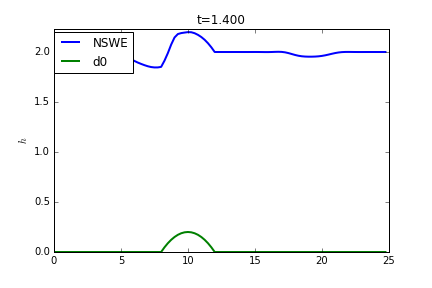
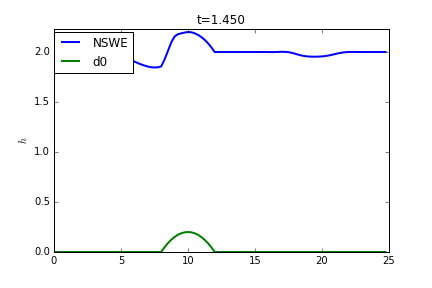
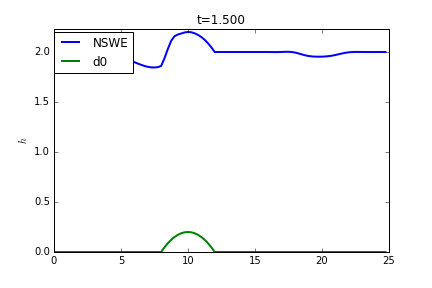
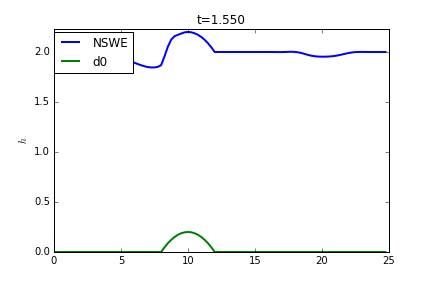
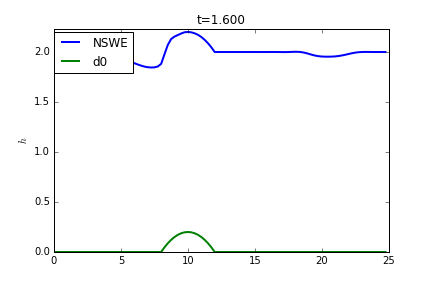
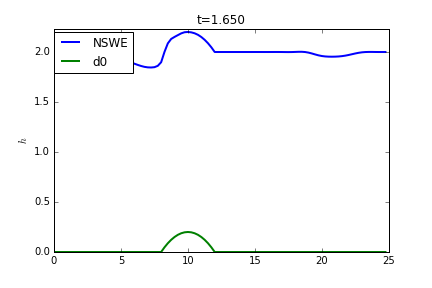
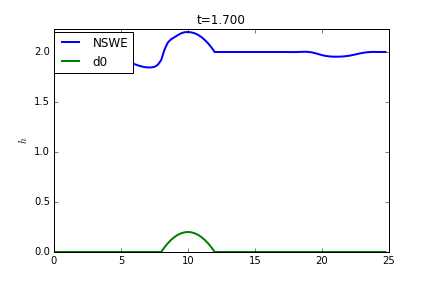
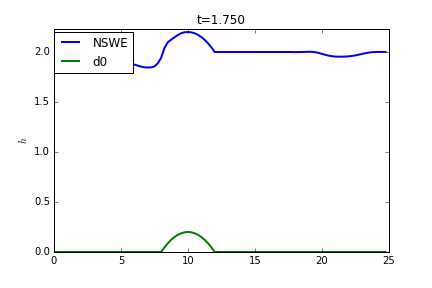
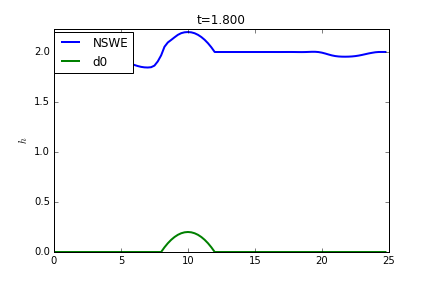
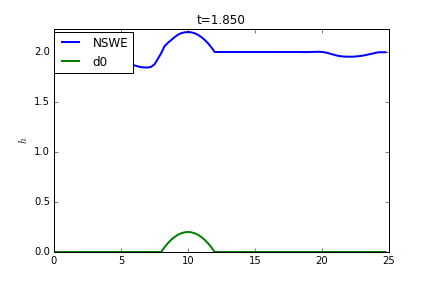
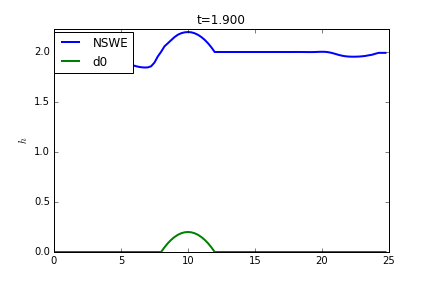
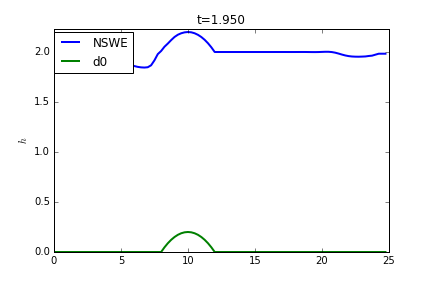
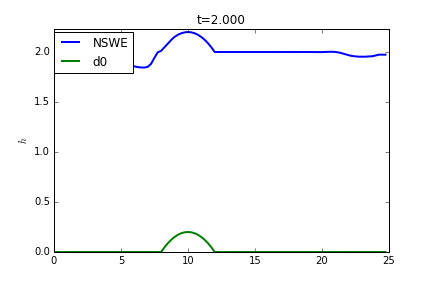
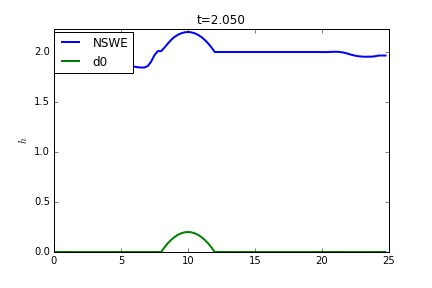
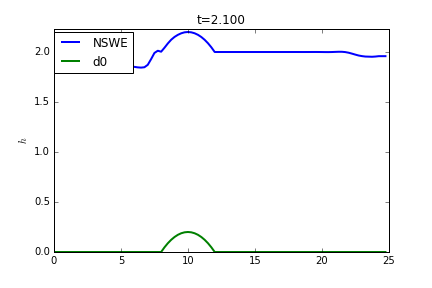
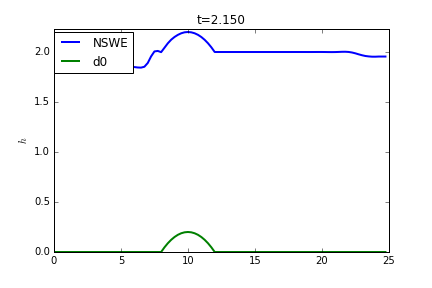
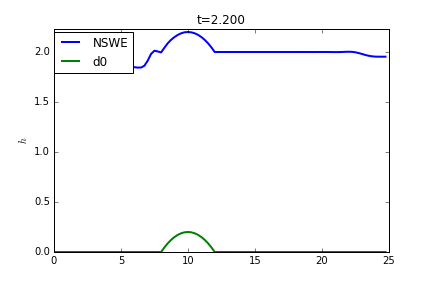
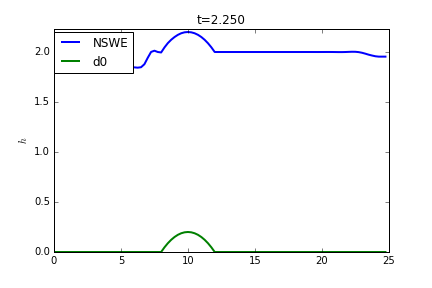
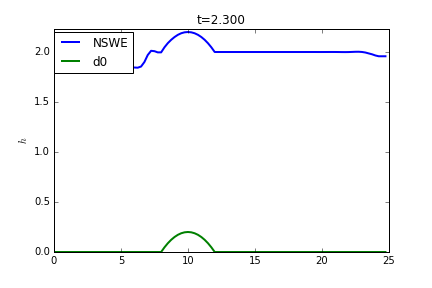
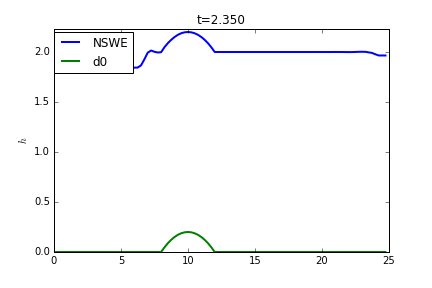
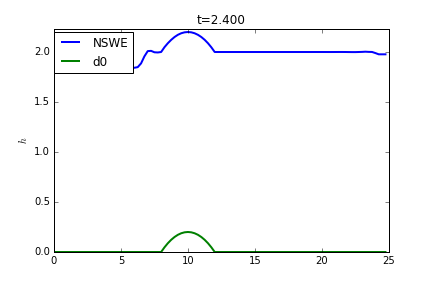
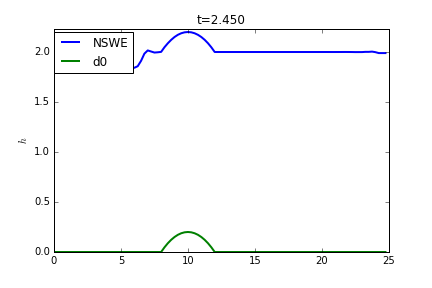
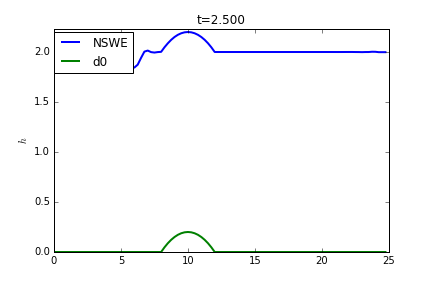
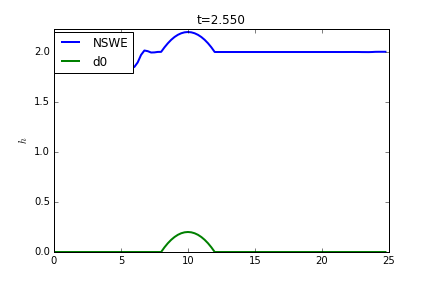
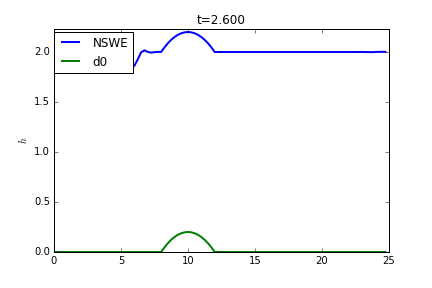
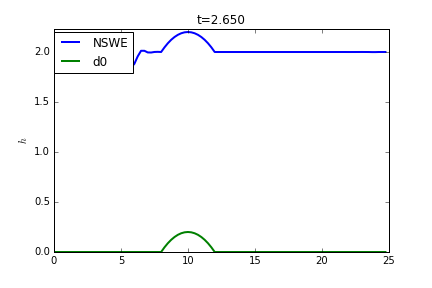
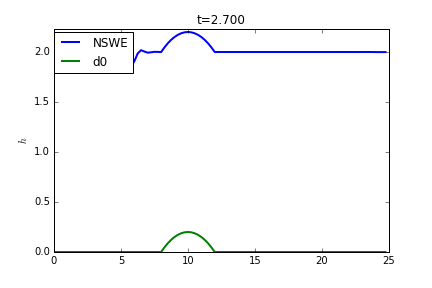
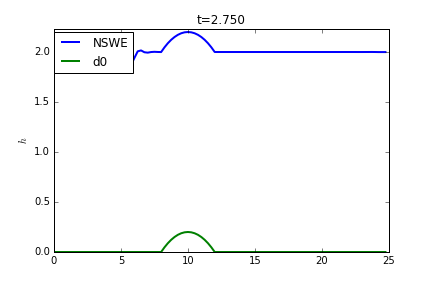
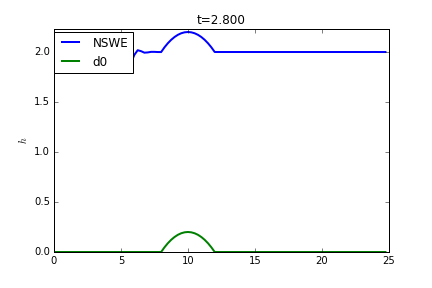
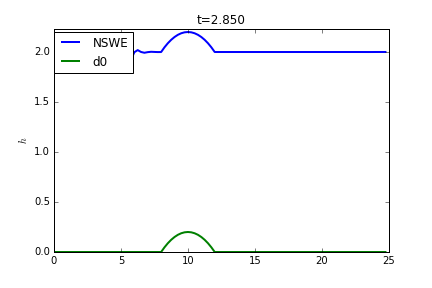
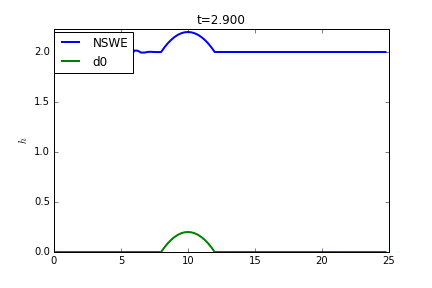
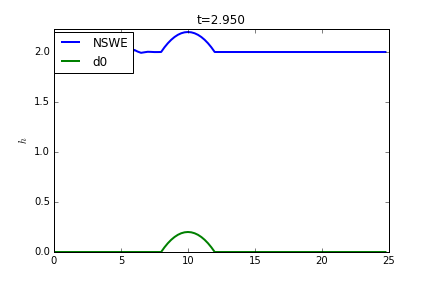
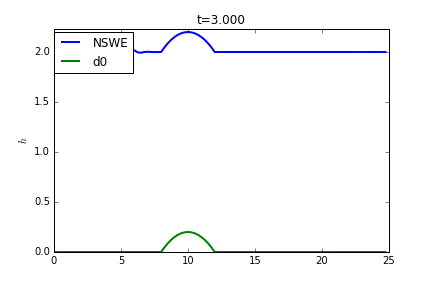
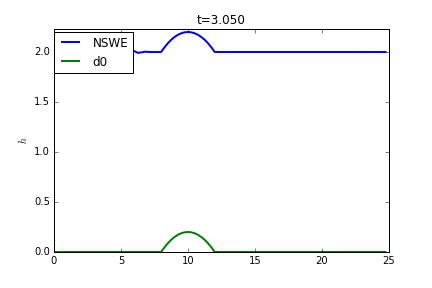
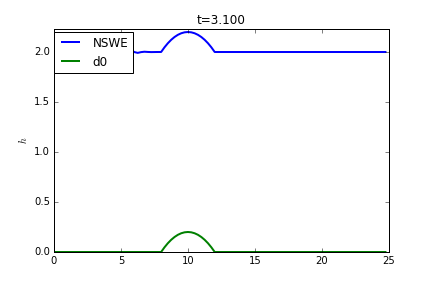
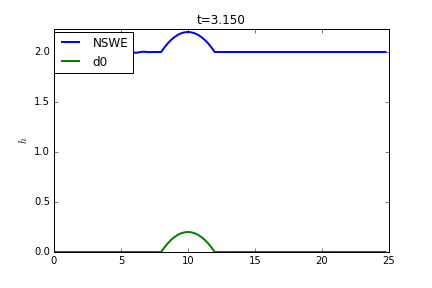
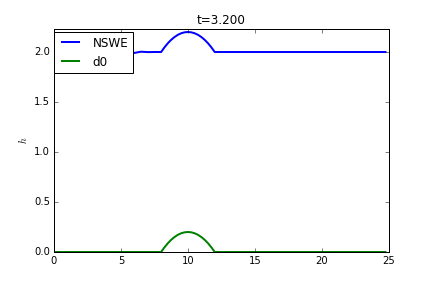
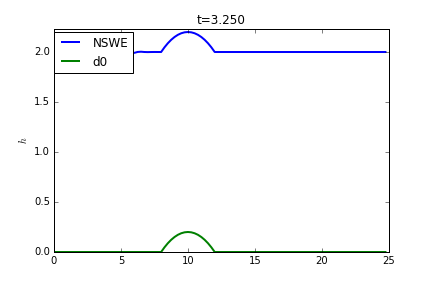
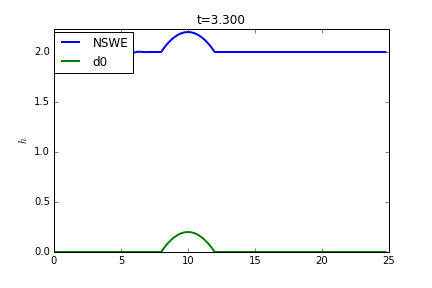
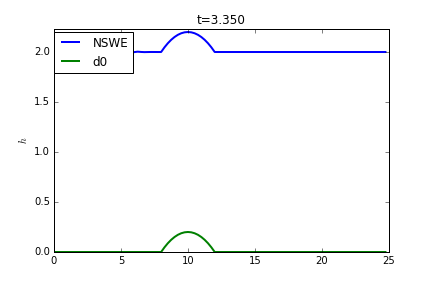
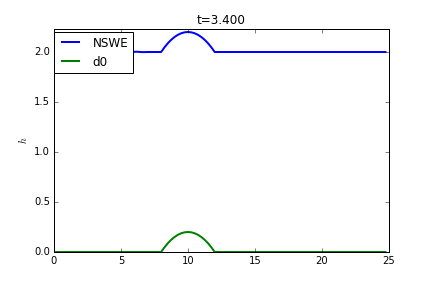
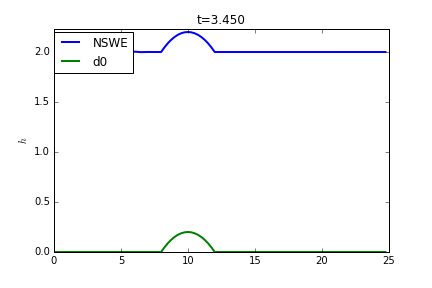
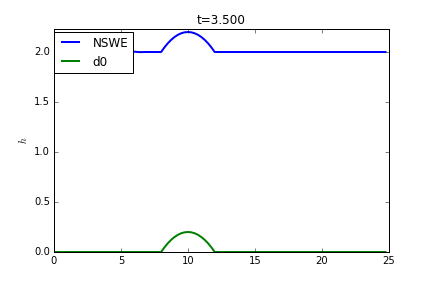
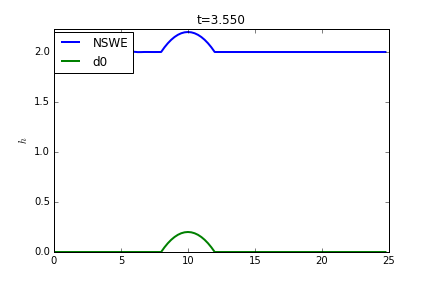
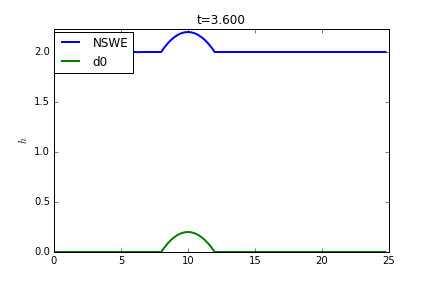
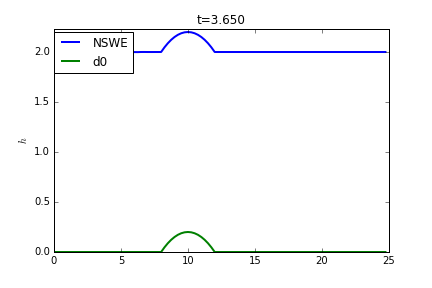
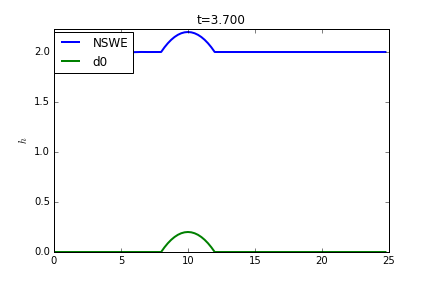
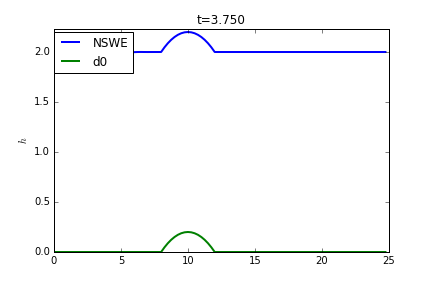
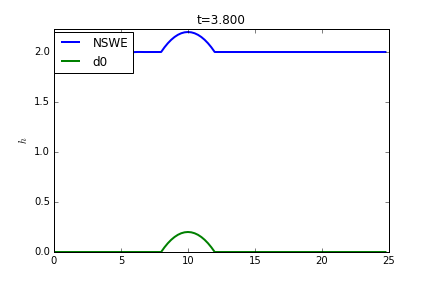
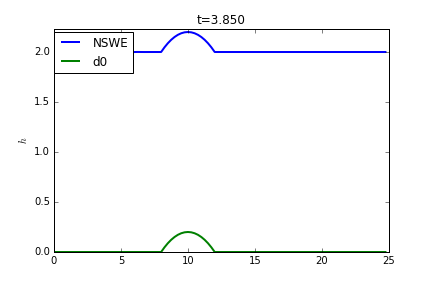
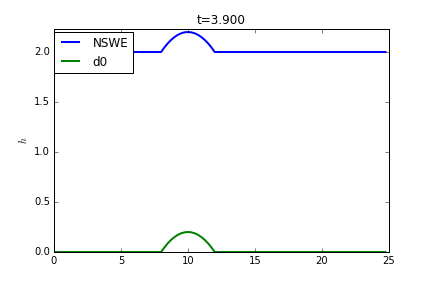
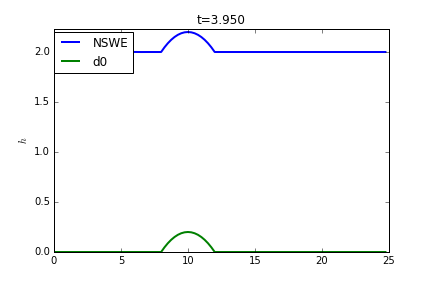
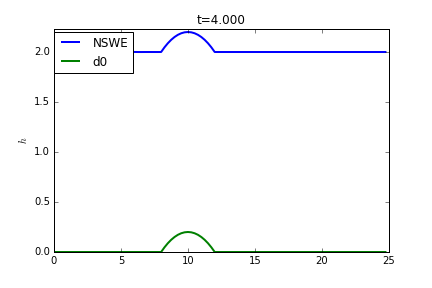
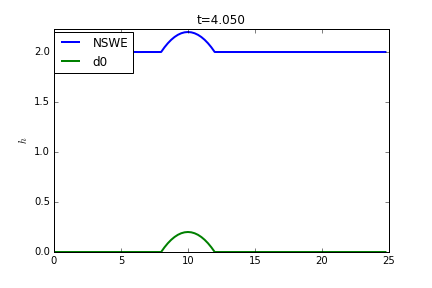
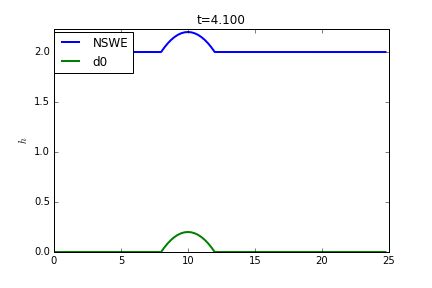
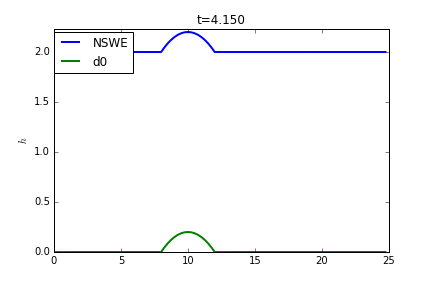
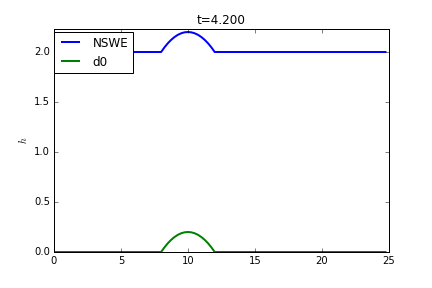
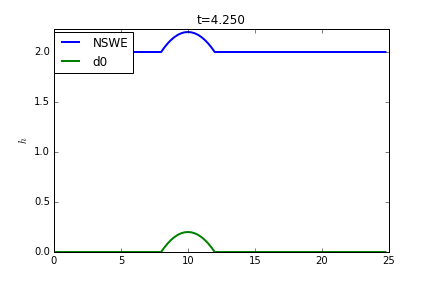
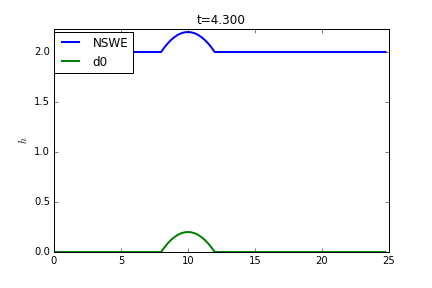
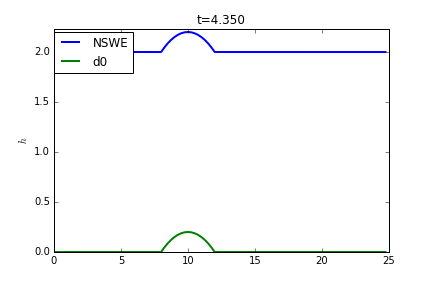
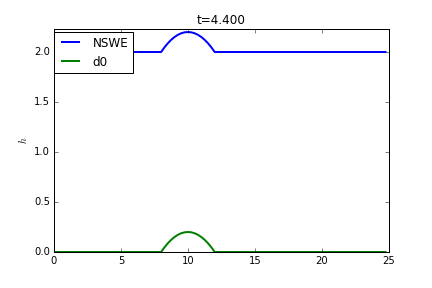
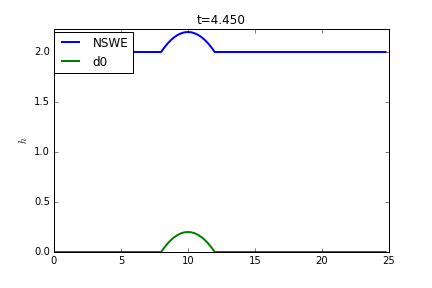
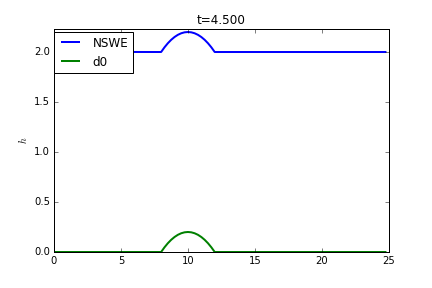
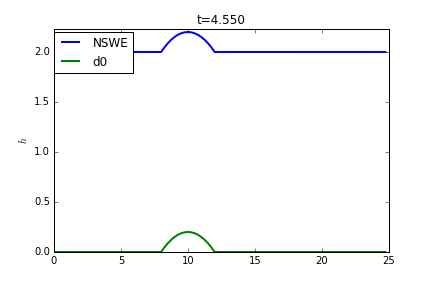
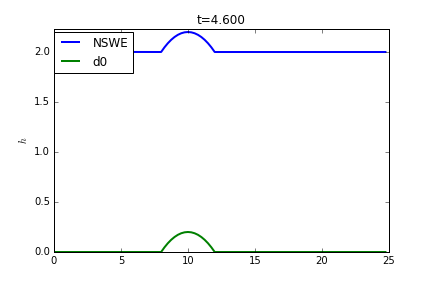
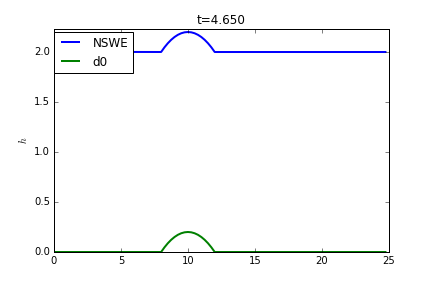
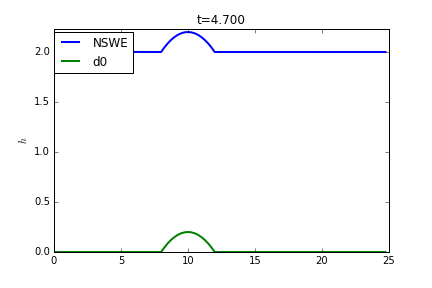
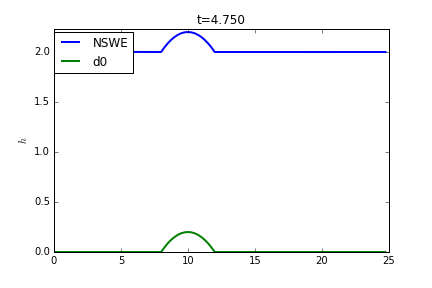
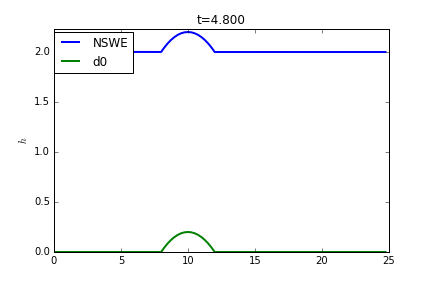
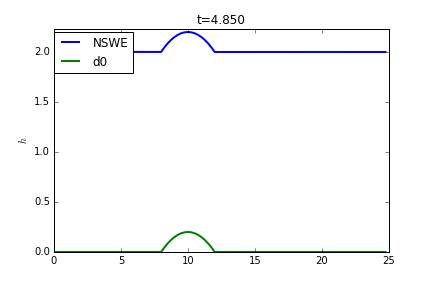
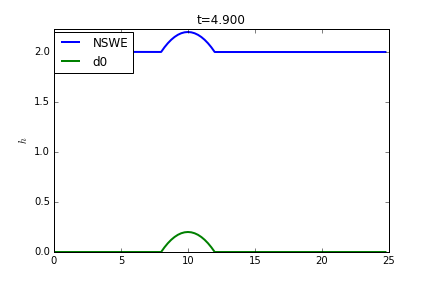
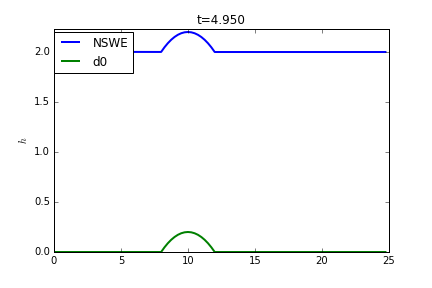
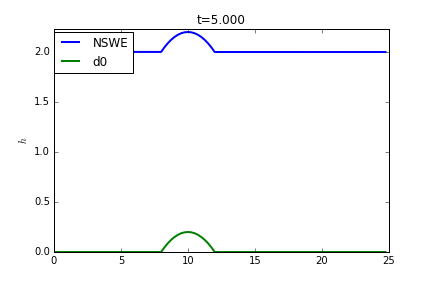
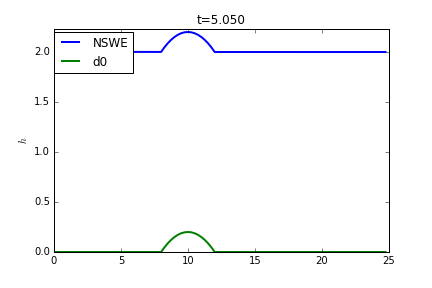

In [8]:
reload(gF)
lb = ["NSWE", "d0"]
gF.plotAnimationNSolutions(2,x,np.array([hallP,d0all]),tall,xmin,xmax,0.,hmax+np.amax(d0),lb,ylabel=r'$h$',location=(0.,0.8))

*** Plotting animation ...



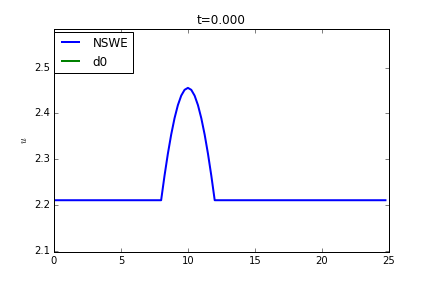
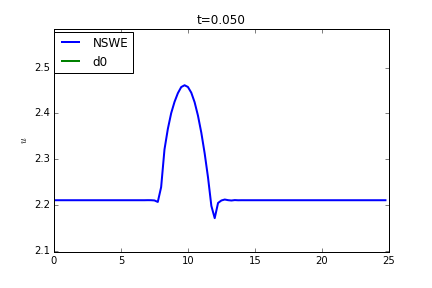
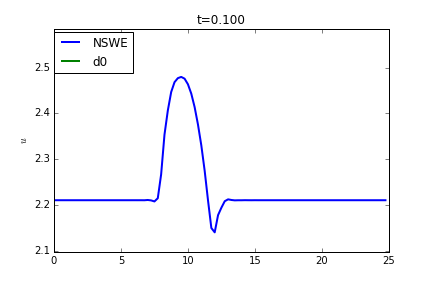
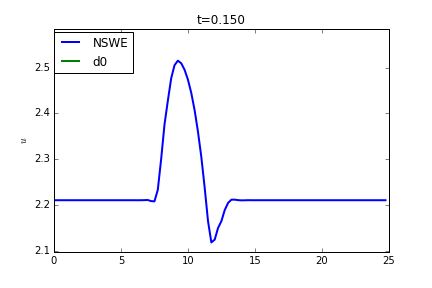
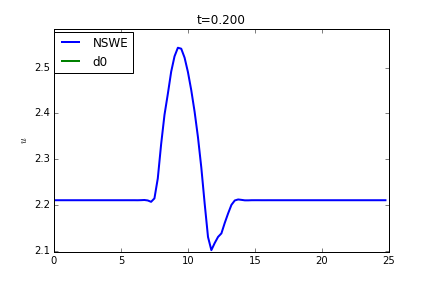
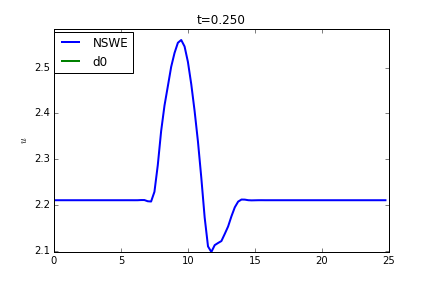
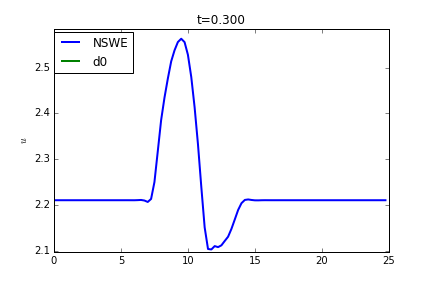
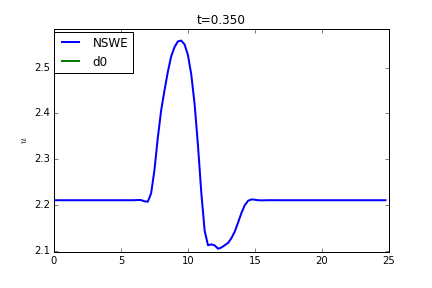
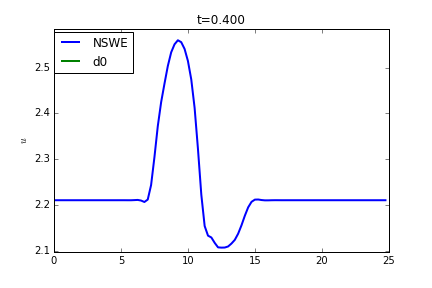
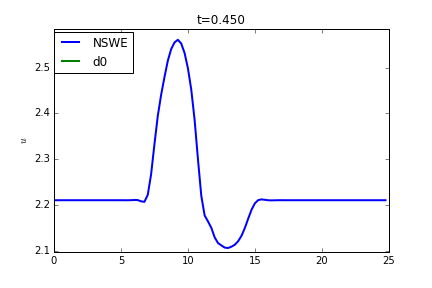
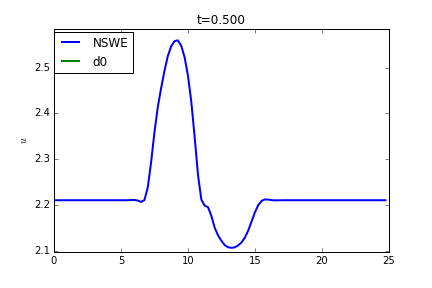
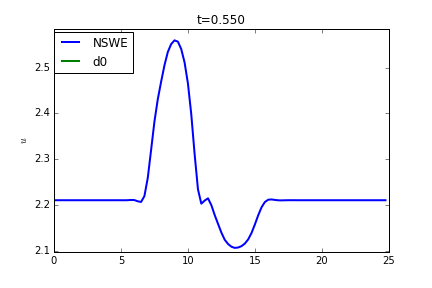
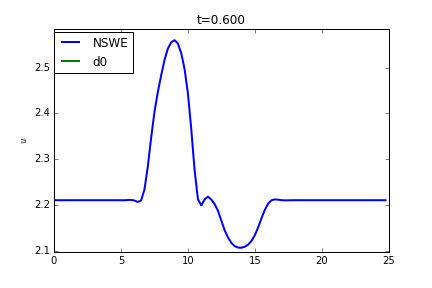
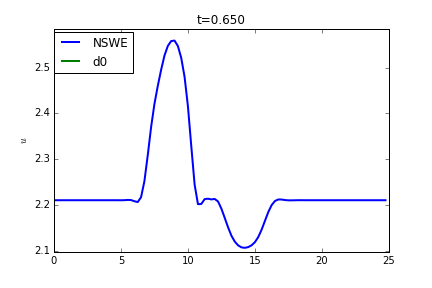
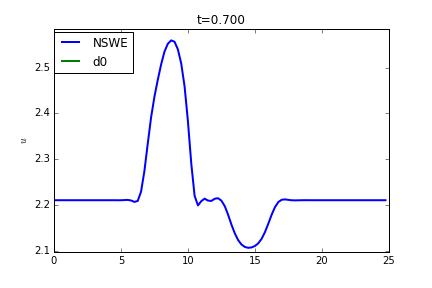
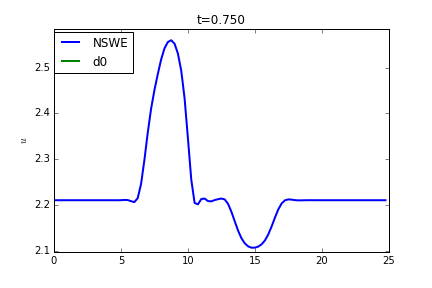
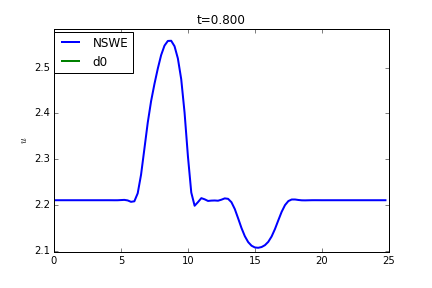
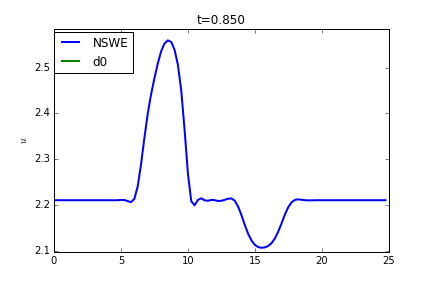
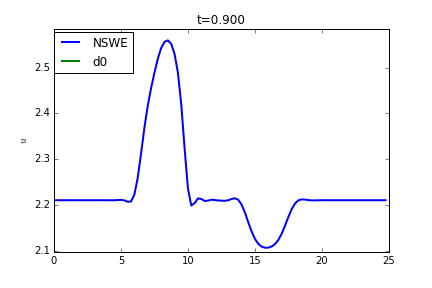
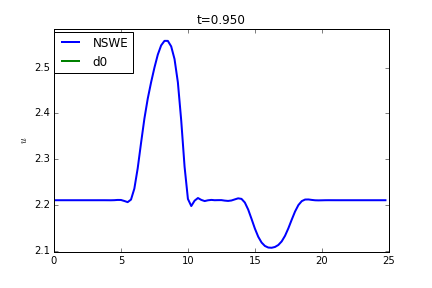
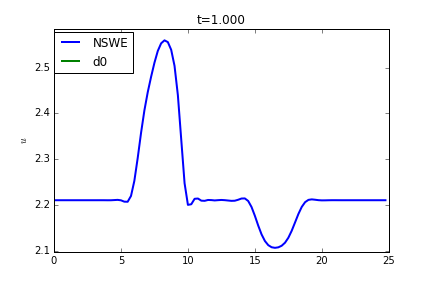
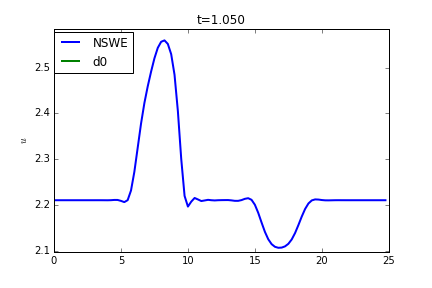
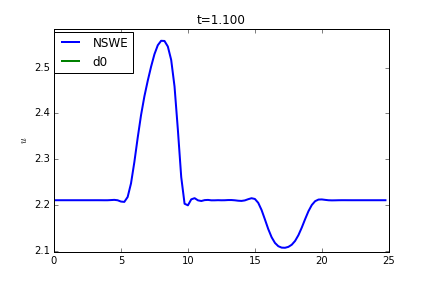
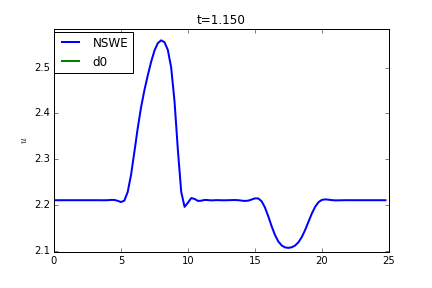
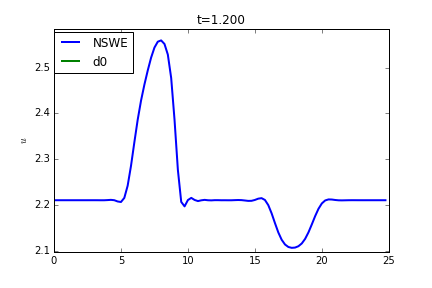
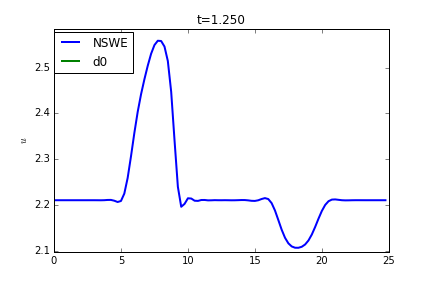
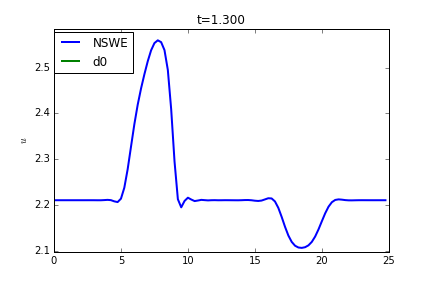
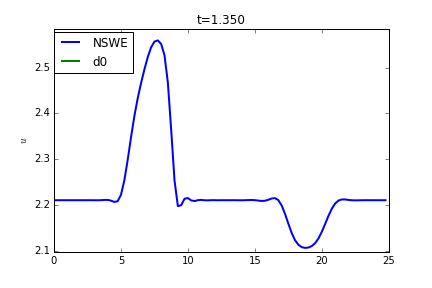
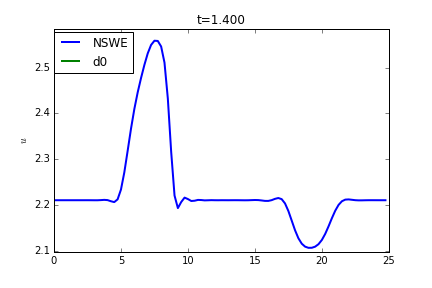
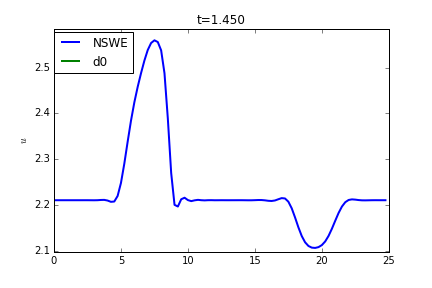
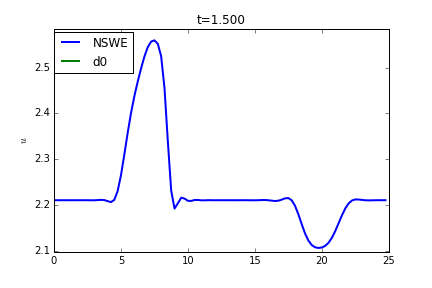
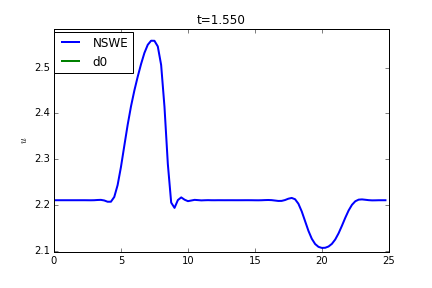
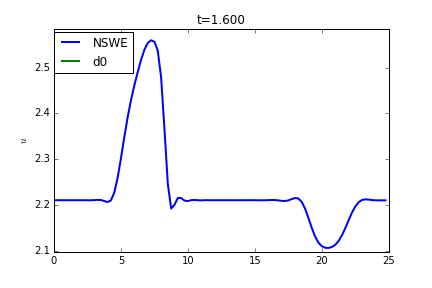
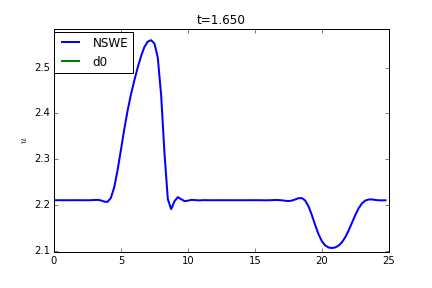
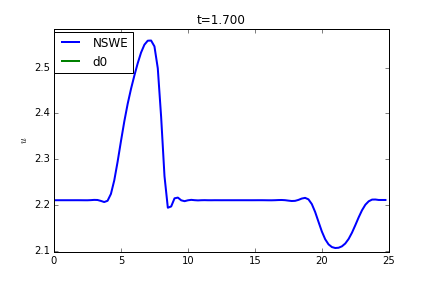
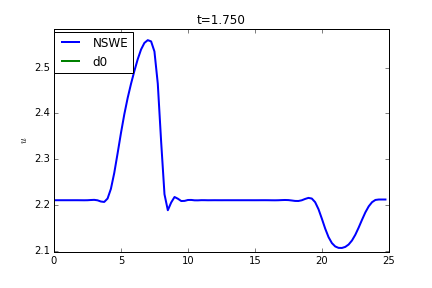
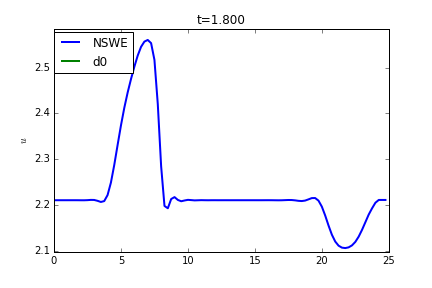
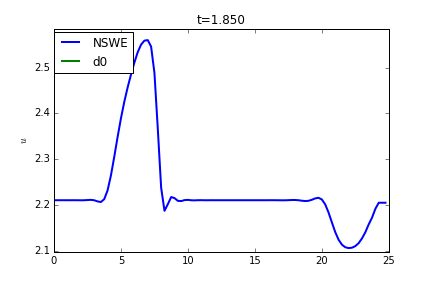
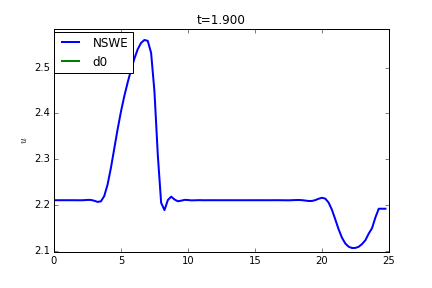
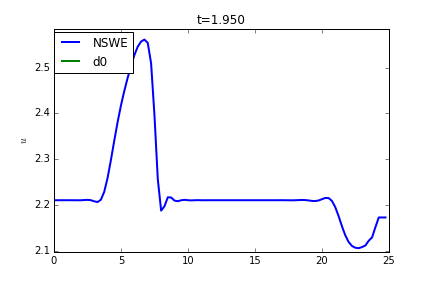
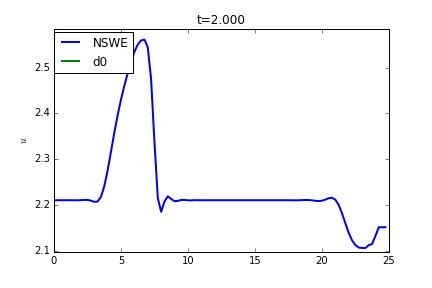
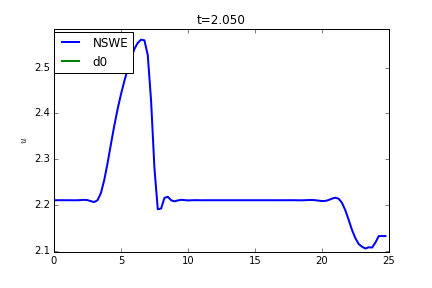
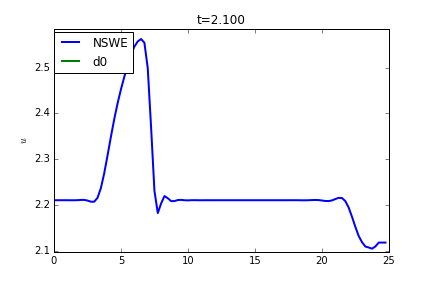
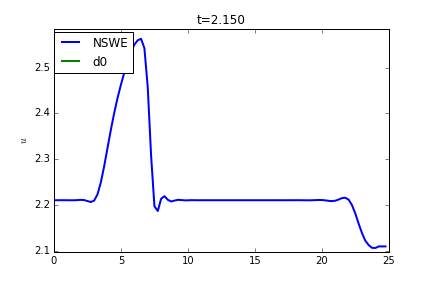
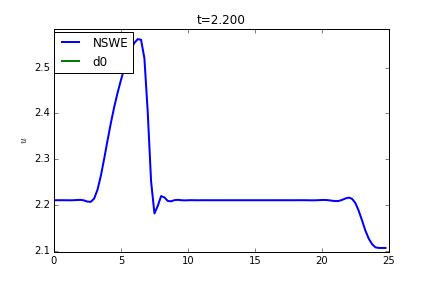
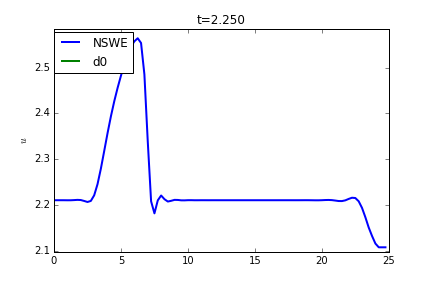
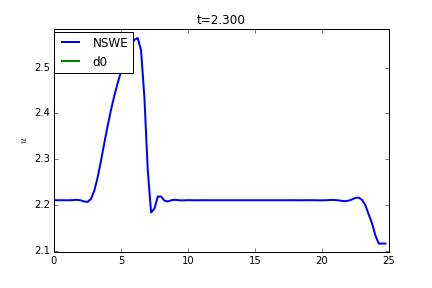
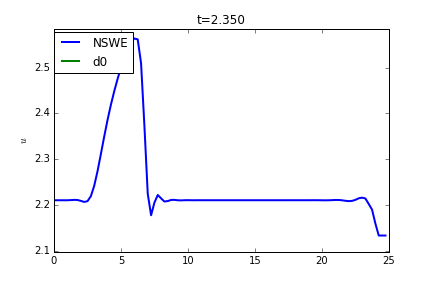
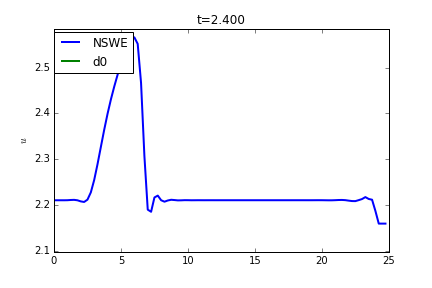
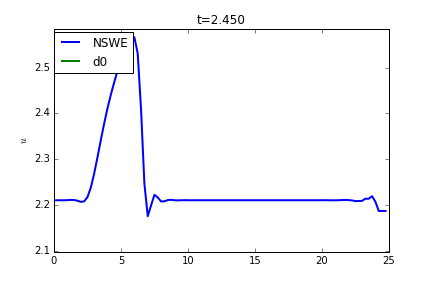
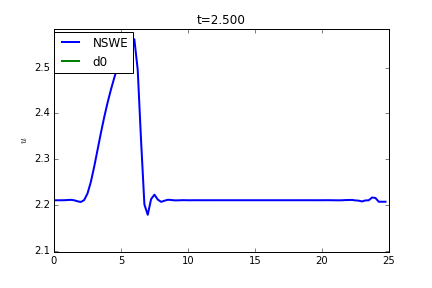
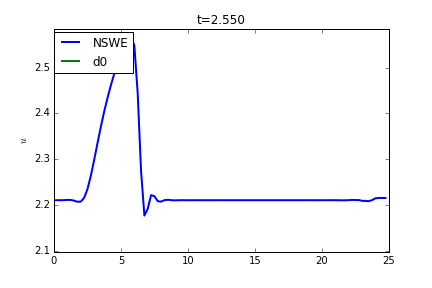
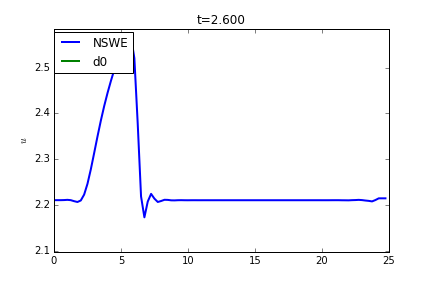
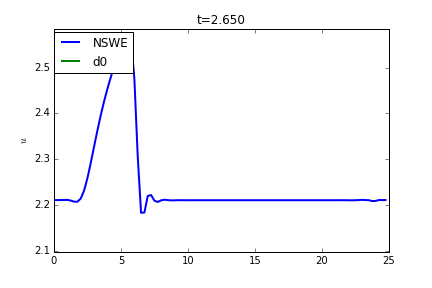
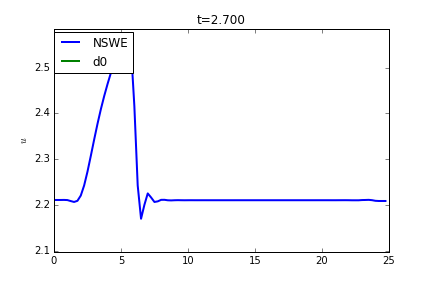
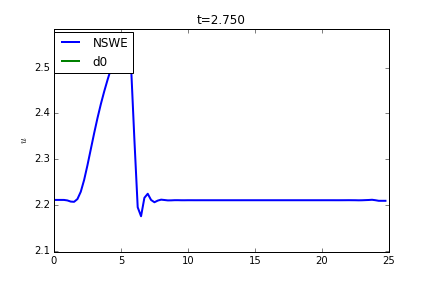
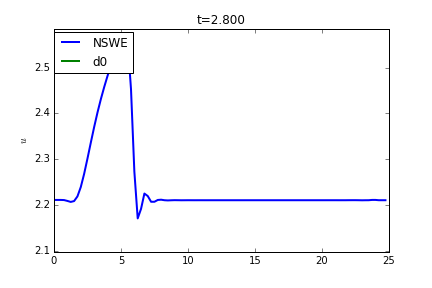
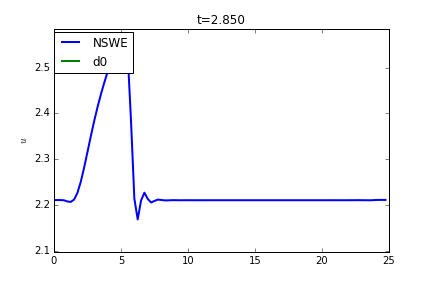
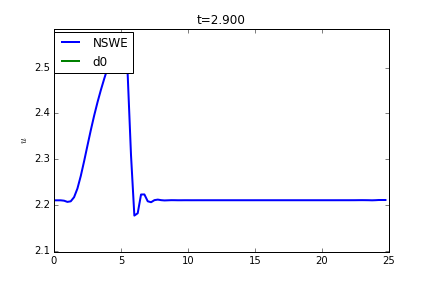
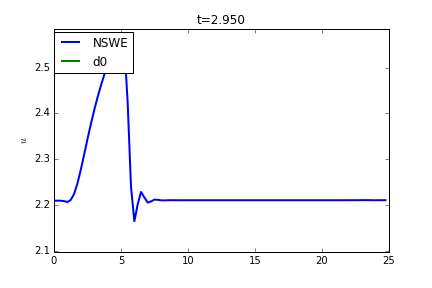
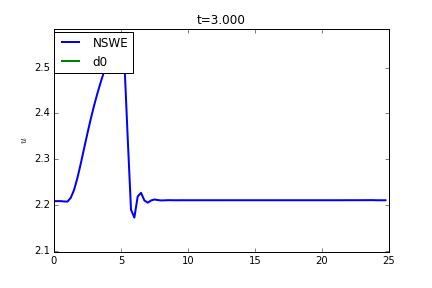
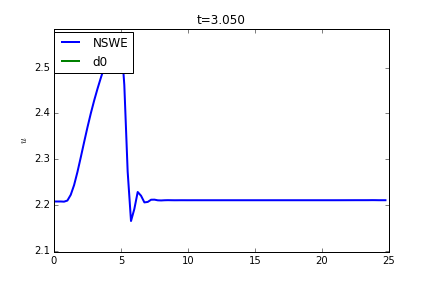
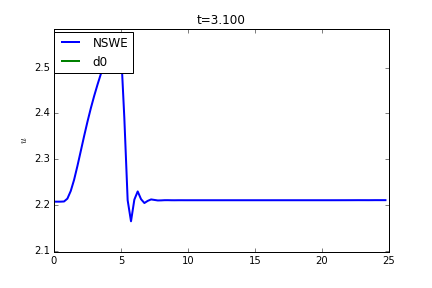
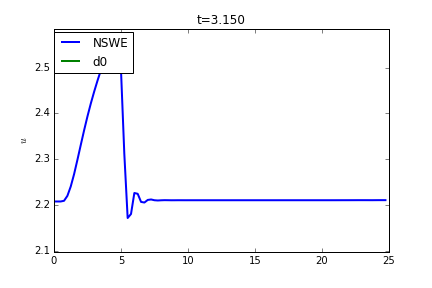
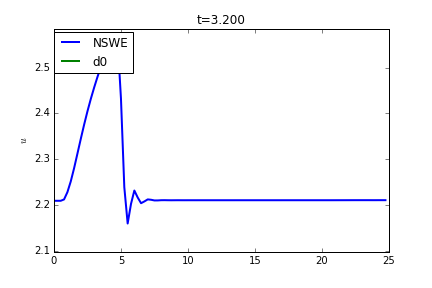
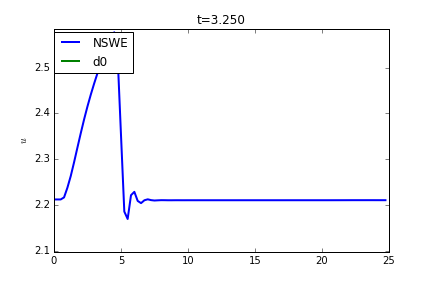
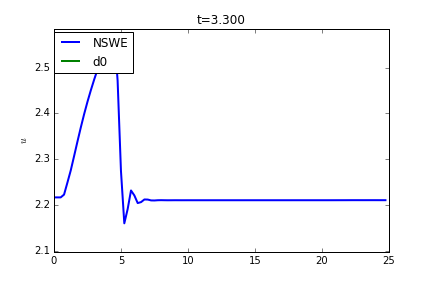
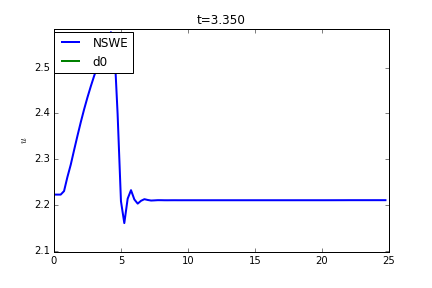
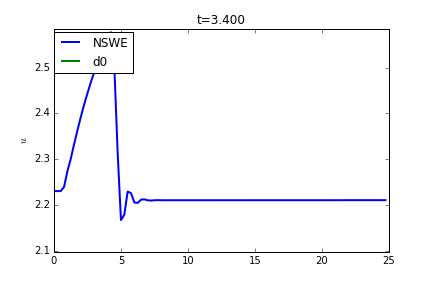
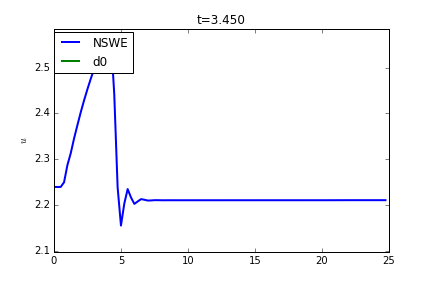
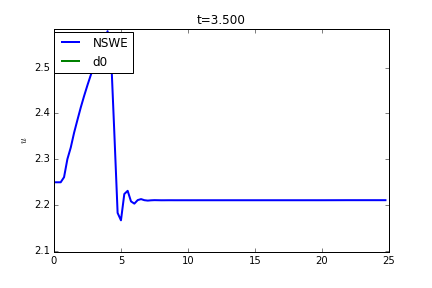
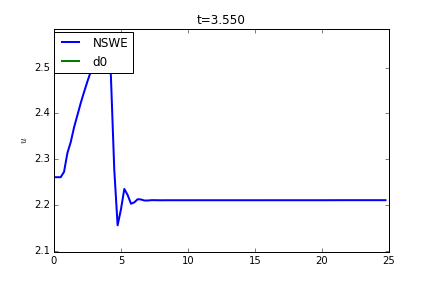
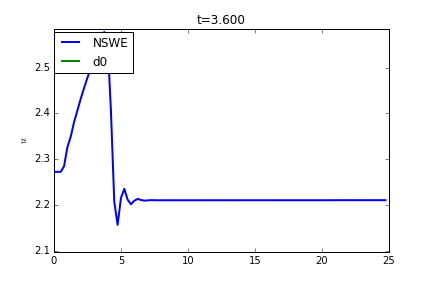
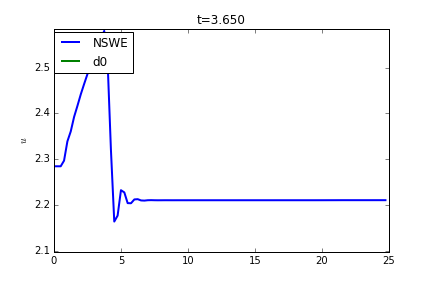
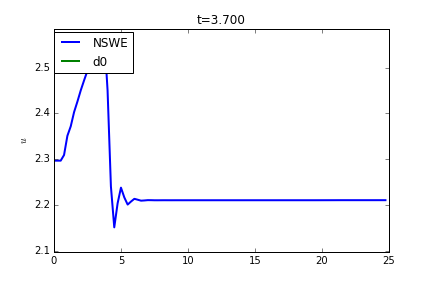
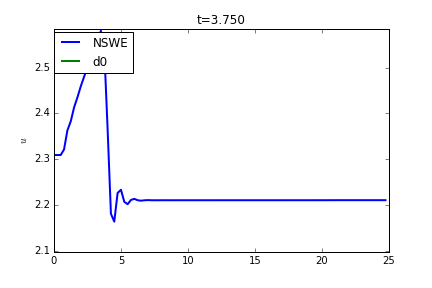
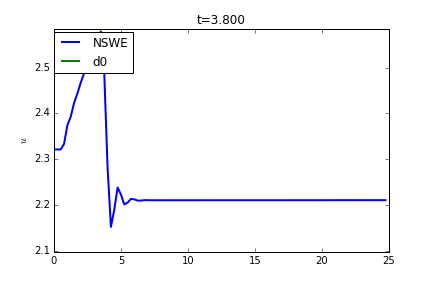
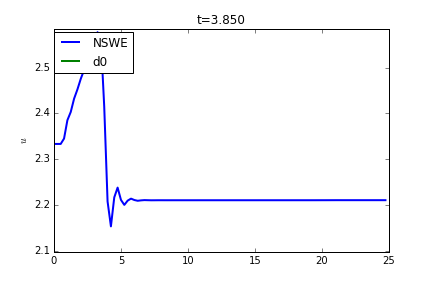
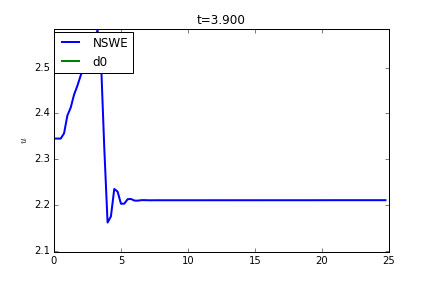
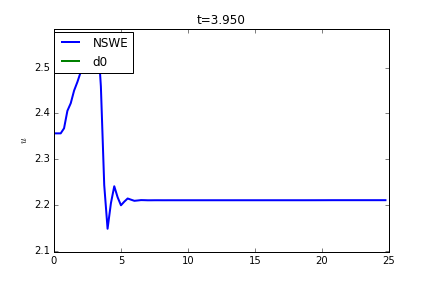
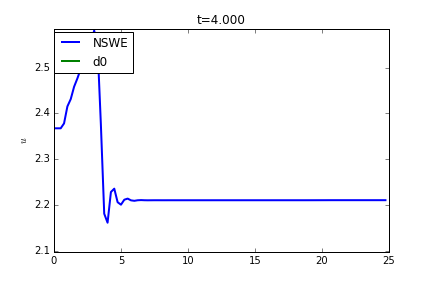
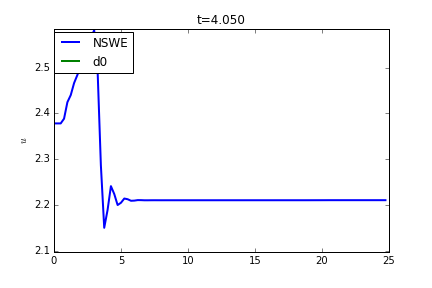
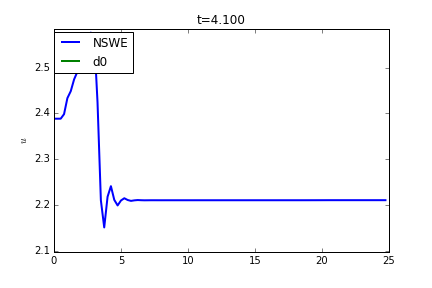
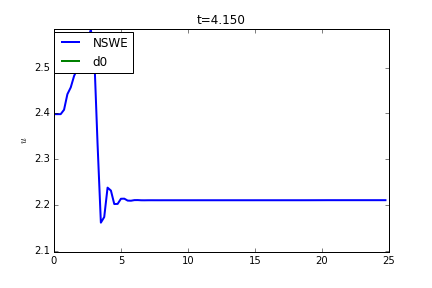
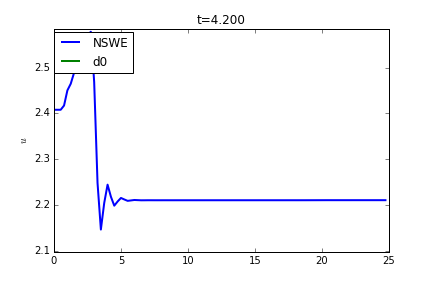
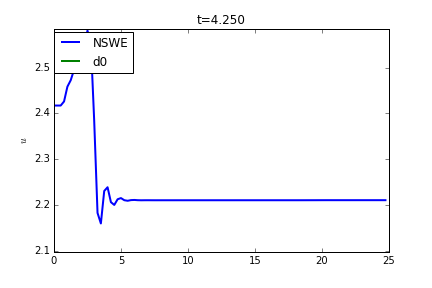
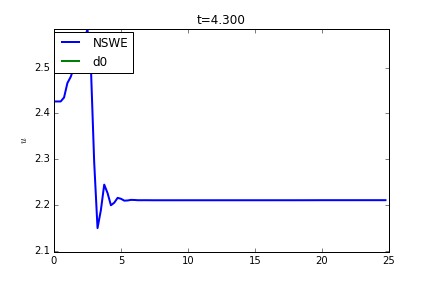
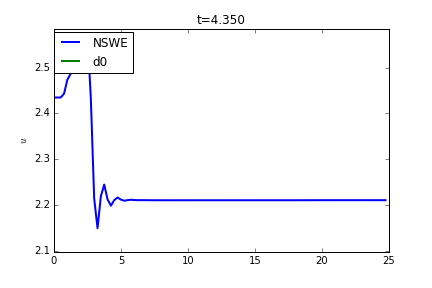
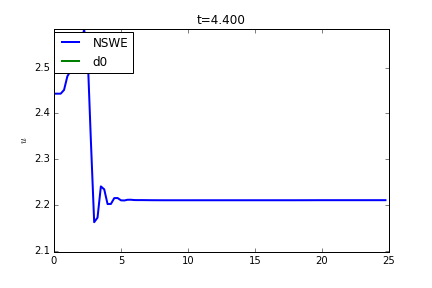
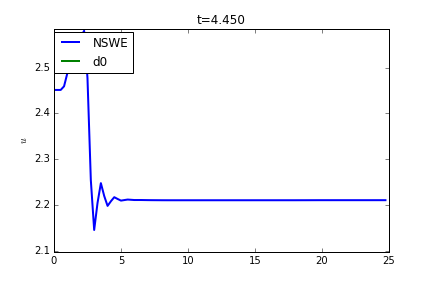
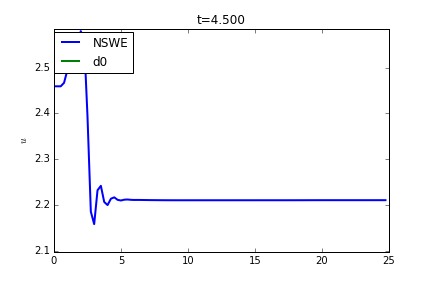
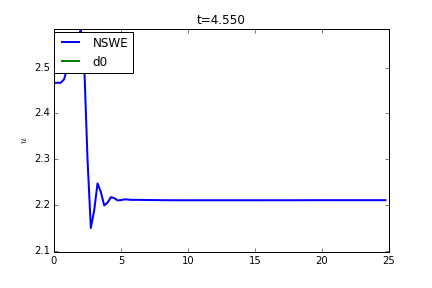
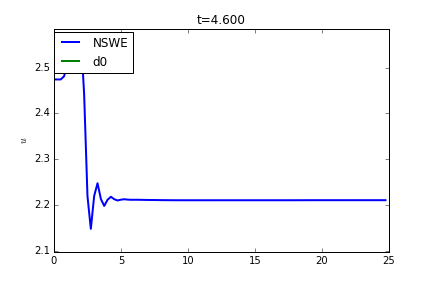
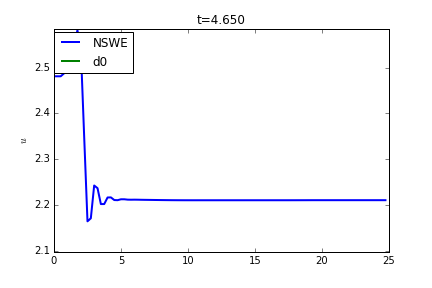
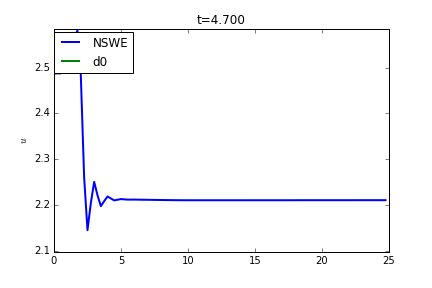
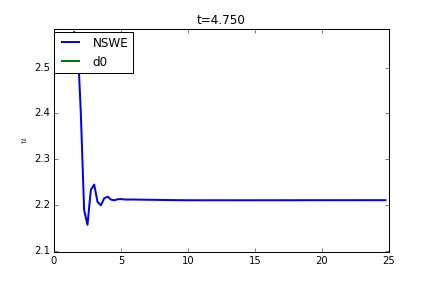
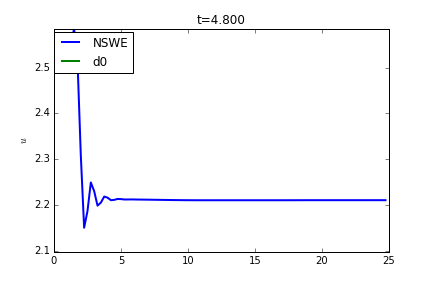
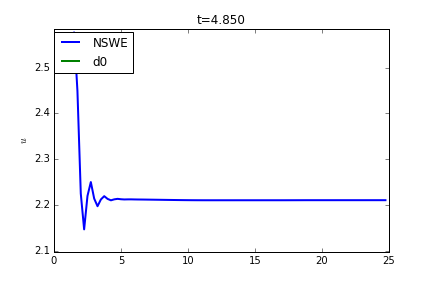
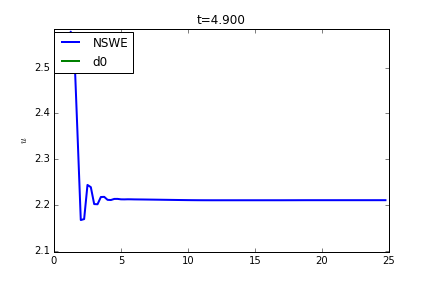
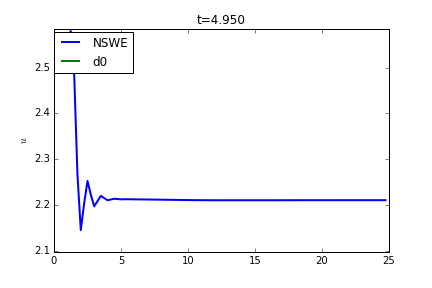
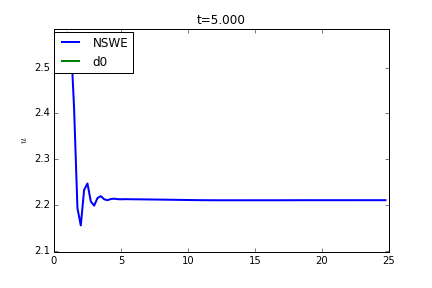
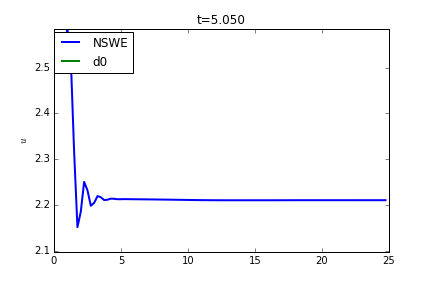

In [9]:
reload(gF)
lb = ["NSWE", "d0"]
gF.plotAnimationNSolutions(2,x,np.array([uall,d0all]),tall,xmin,xmax,umin,umax,lb,ylabel=r'$u$',location=(0.,0.8))

## Validation: solitary solution over constant slope (NSWE)

In [10]:
a0 = 1.
a1 = .1
k = 0.
g = 9.81
t0 = 0.0
t = t0
tmax = 5.

lam, h0 = cnoidal.WaveLengthDepth(k,a0,a1)

L = 3.*lam
xmin = -L
xmax = L
nx = 100

x,dx = serre.discretizeSpace(xmin,xmax,nx)

eta = 0.01
d0 = 0.001 + eta*x
h,u = cnoidal.analyticalSolutionSolitary(x,t,a0,a1)
h = h-d0

BC1=np.array([0.,0.,0.,0.,0.,1.,0.,1.,0.,1.,0.,1.,0.])
BC2=np.array([0.,0.,nan,nan,0.,nan,nan,nan,0,0,0,0.,0.,0,nan,nan])

hall,uall,tall = serre.NSWE(x,h,u,t0,tmax,openDomainThreeGC,None,dx,x.size,vardt = False, dt = 0.01,
                              fvsolver=fluxes, ghostcells=3,fvTimesolver=serre.Euler)

umin = np.amin(uall)
umax = np.amax(uall)
hmin = np.amin(hall)
hmax = np.amax(hall)

CFL = 0.023041


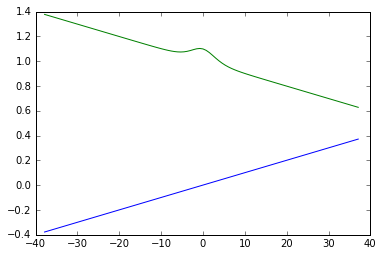

In [11]:
plt.plot(x,d0)
plt.plot(x,h)

In [12]:
hallP = np.copy(hall)
d0all = np.copy(hall)

for i in range (tall.size):
    d0all[:,i] = d0
    hallP[:,i] = hall[:,i] + d0

*** Plotting animation ...



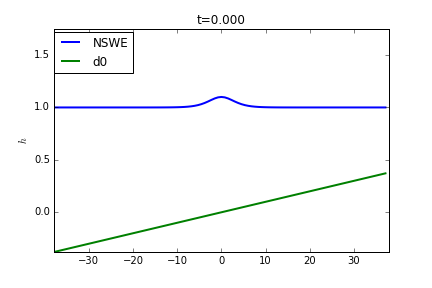
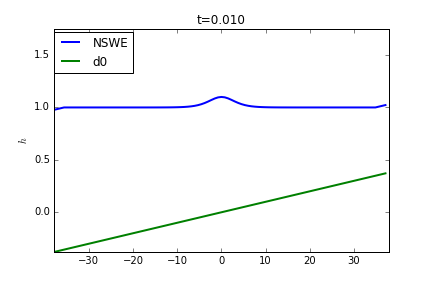
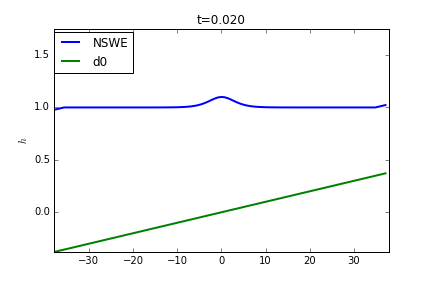
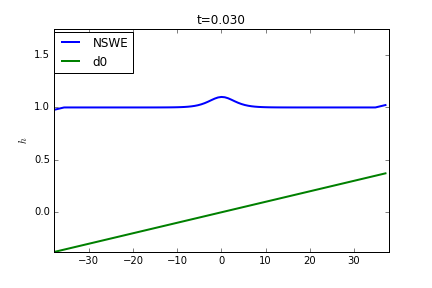
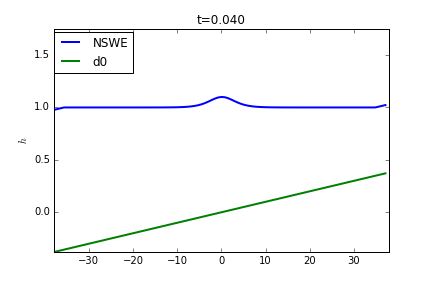
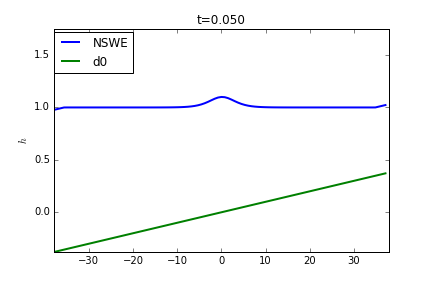
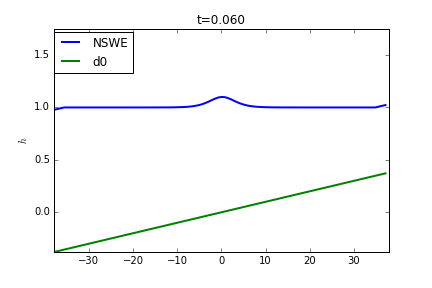
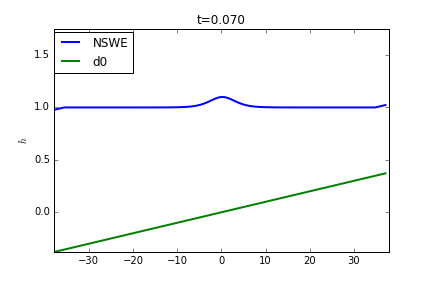
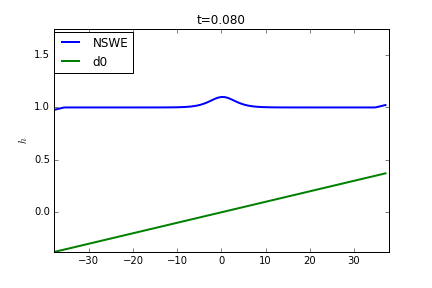
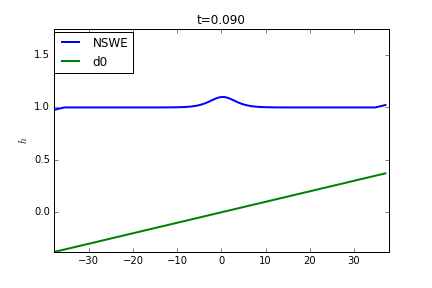
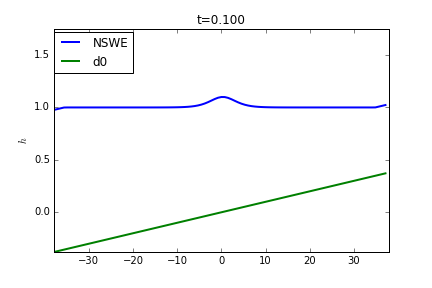
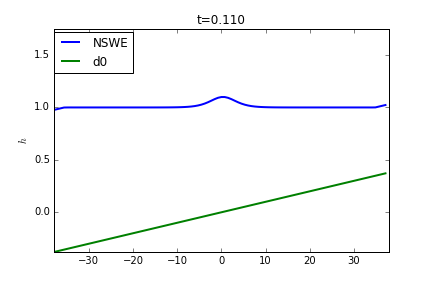
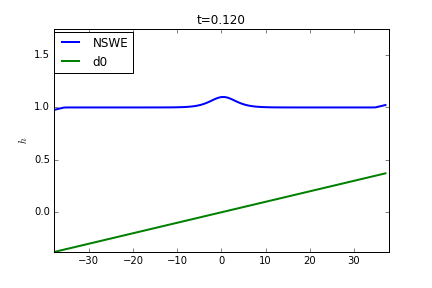
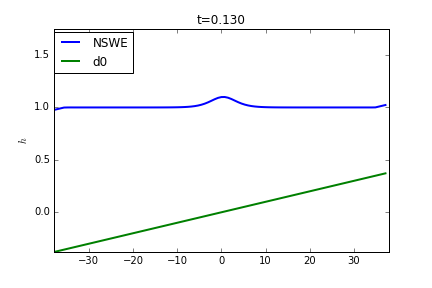
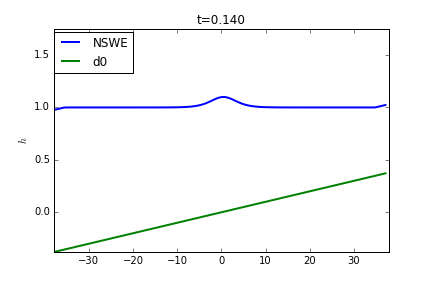
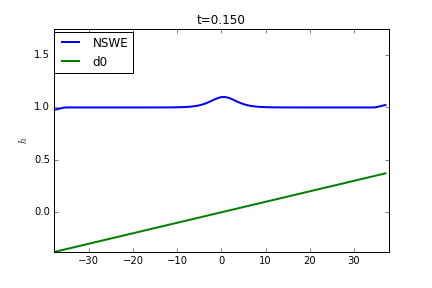
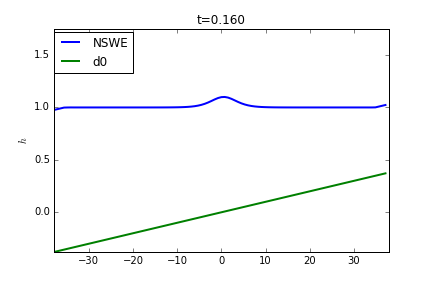
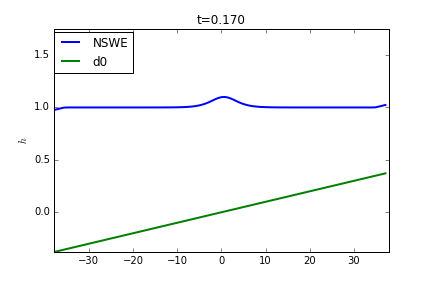
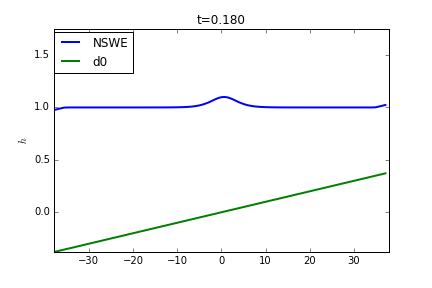
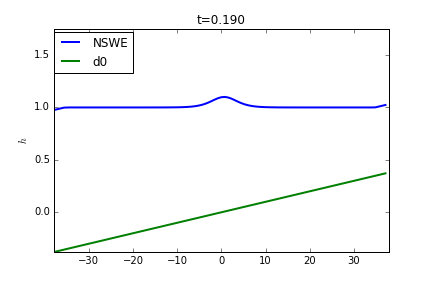
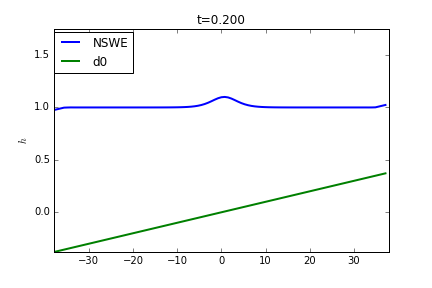
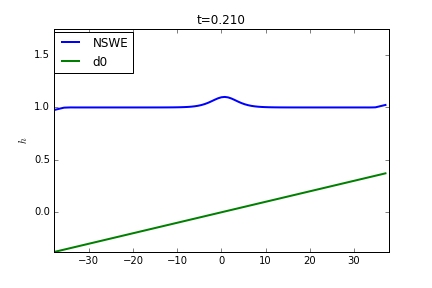
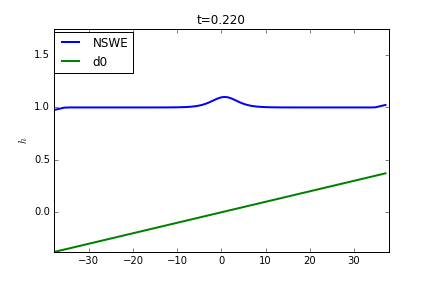
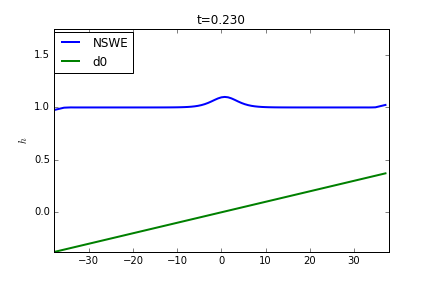
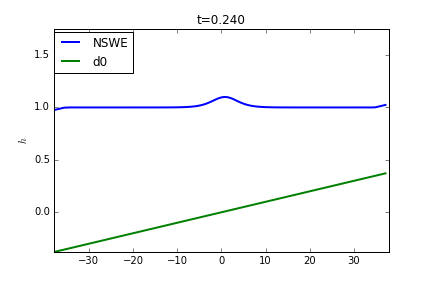
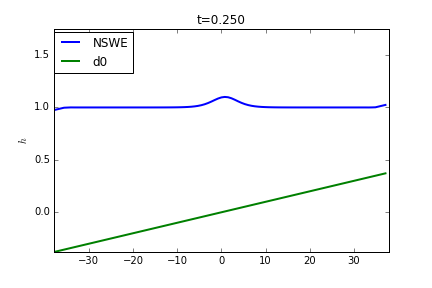
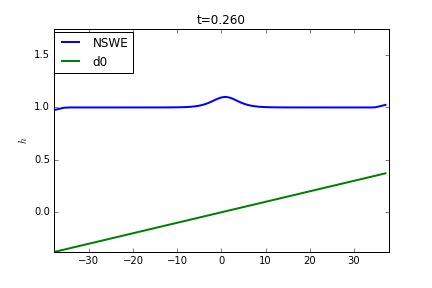
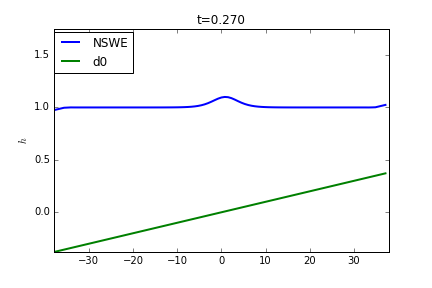
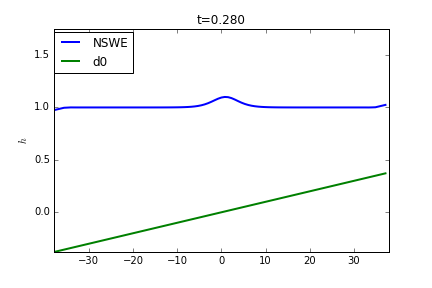
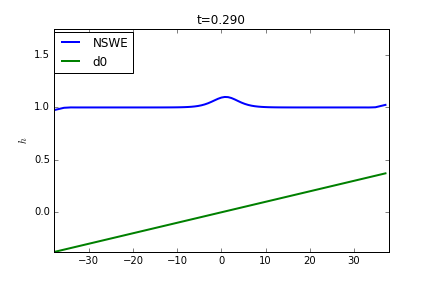
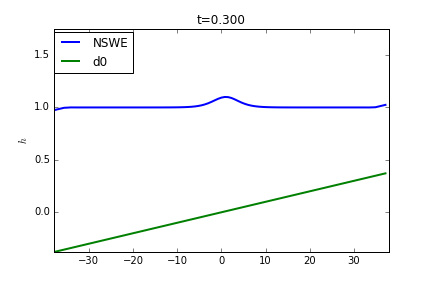
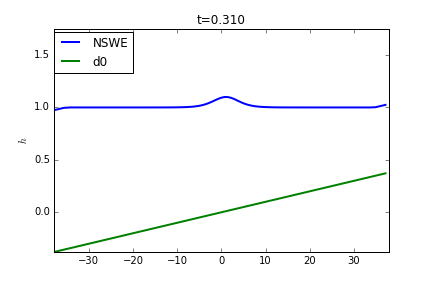
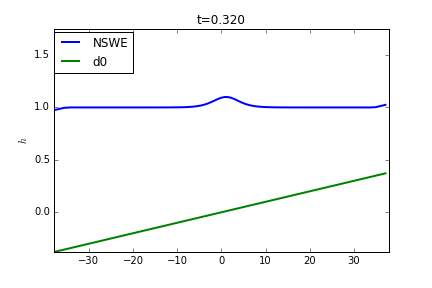
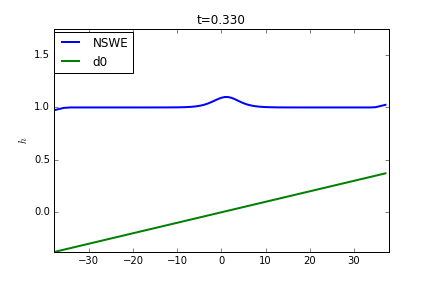
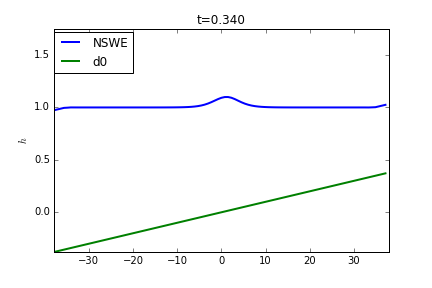
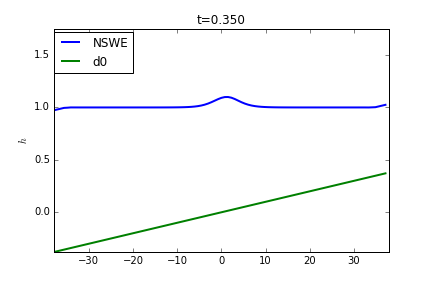
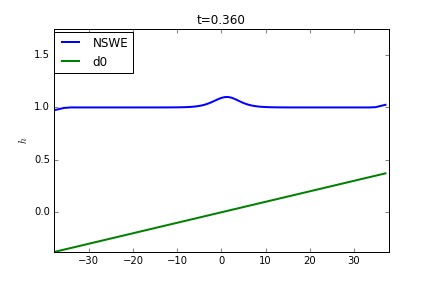
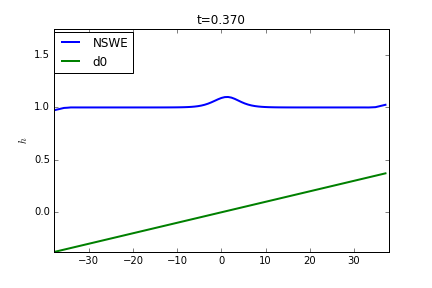
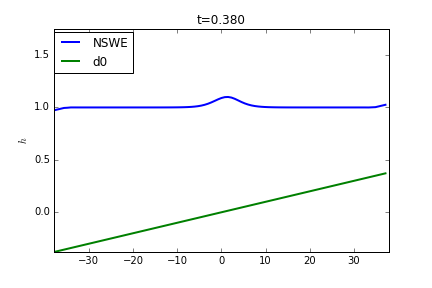
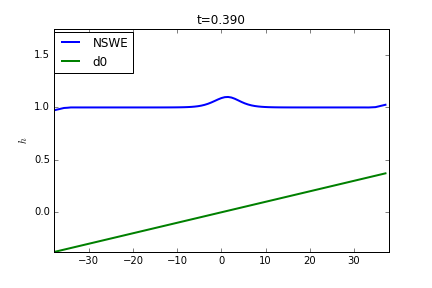
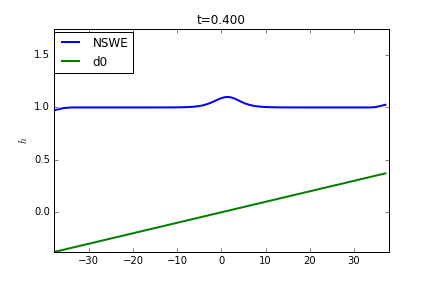
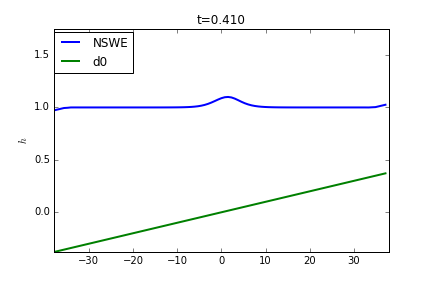
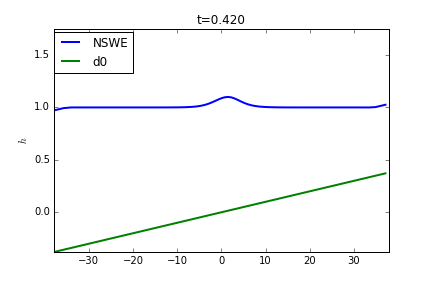
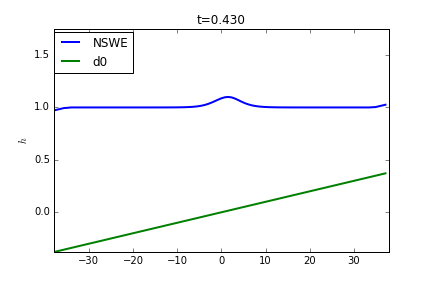
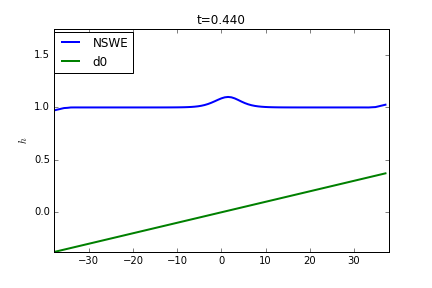
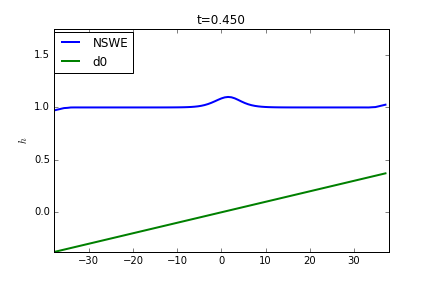
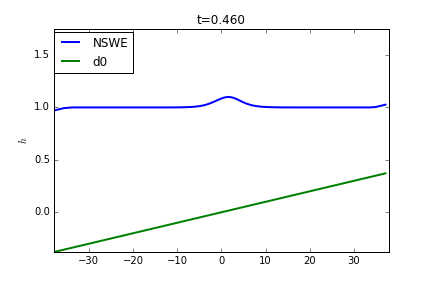
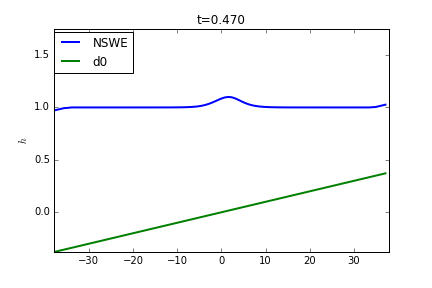
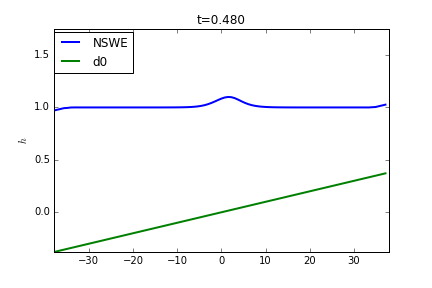
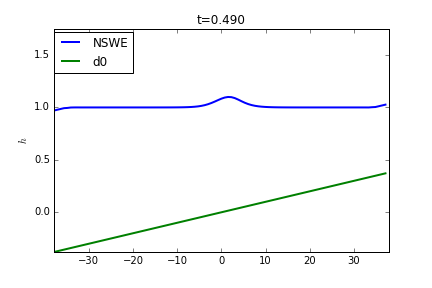
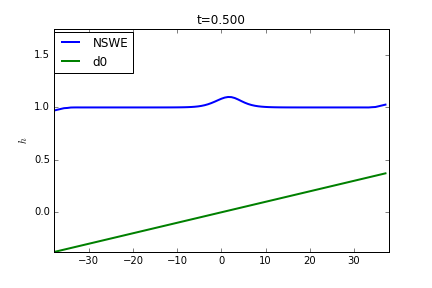
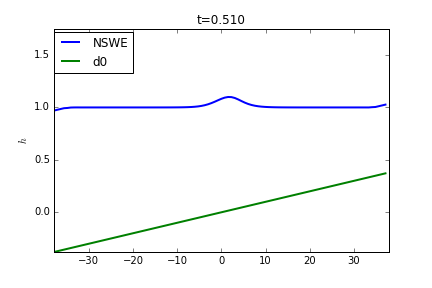
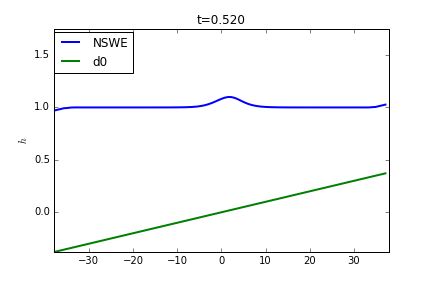
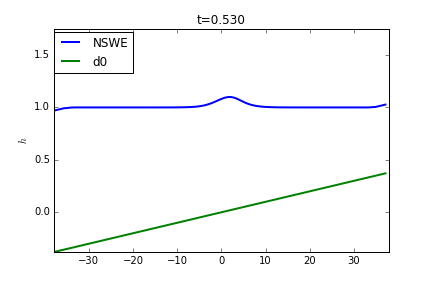
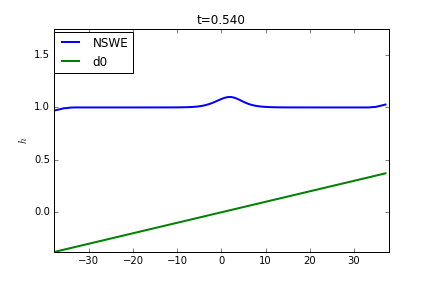
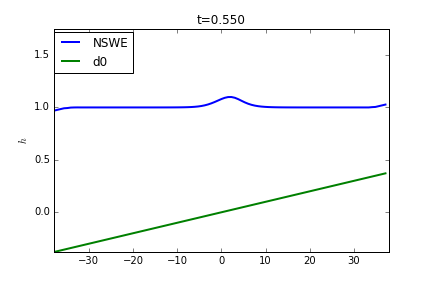
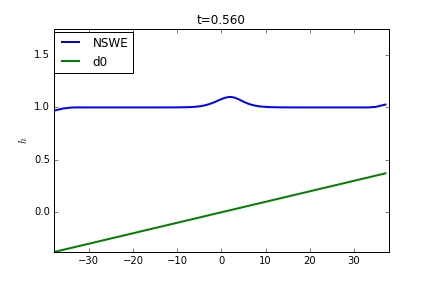
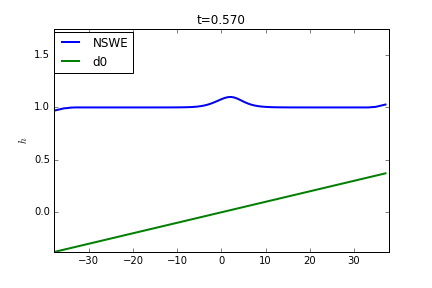
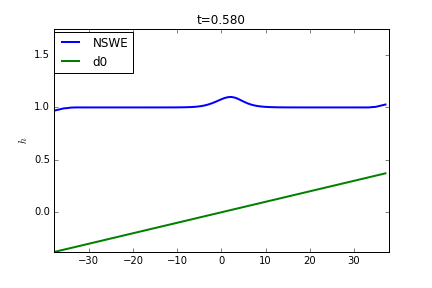
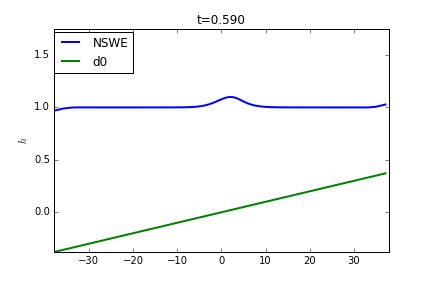
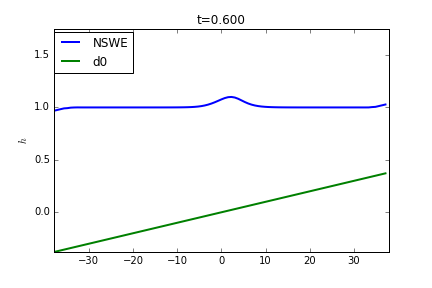
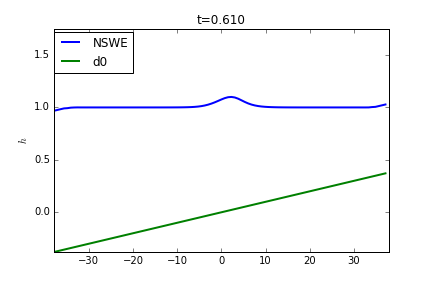
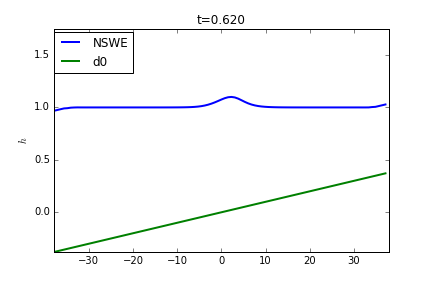
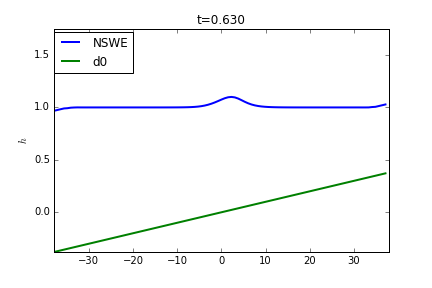
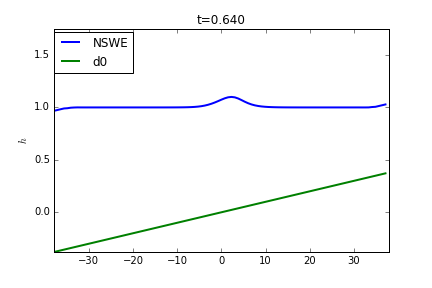
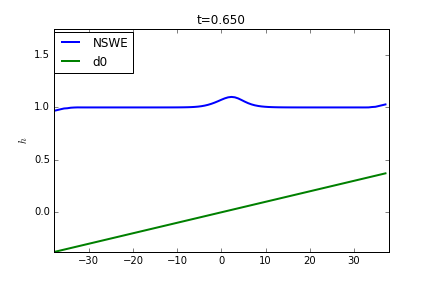
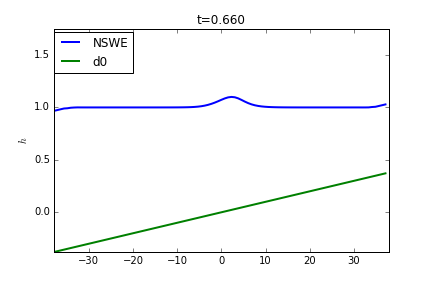
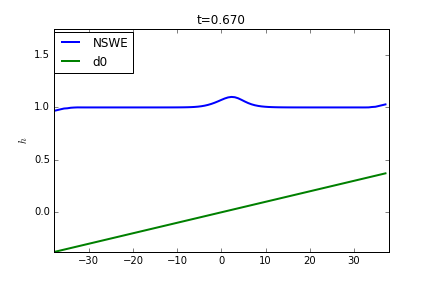
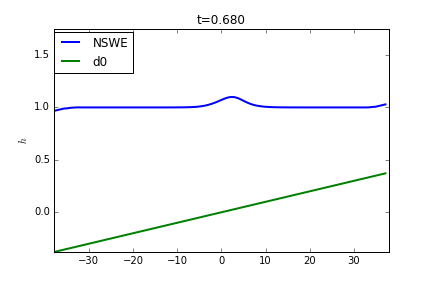
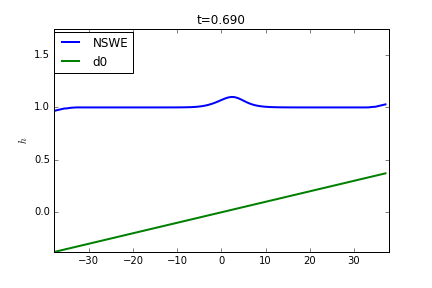
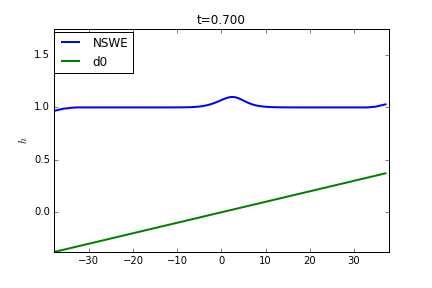
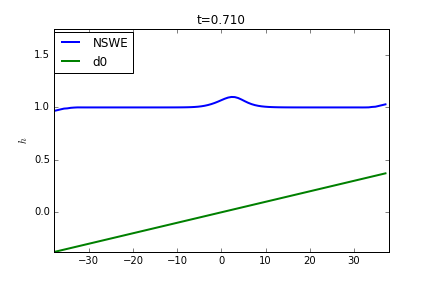
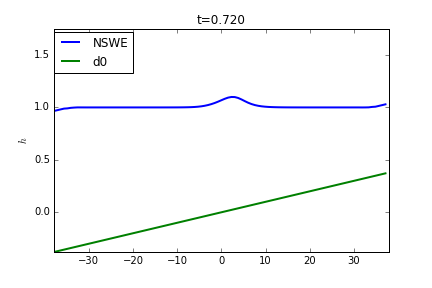
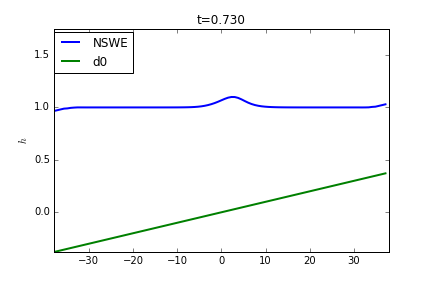
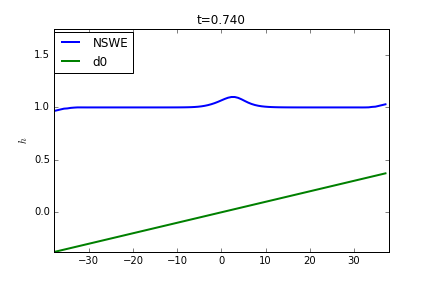
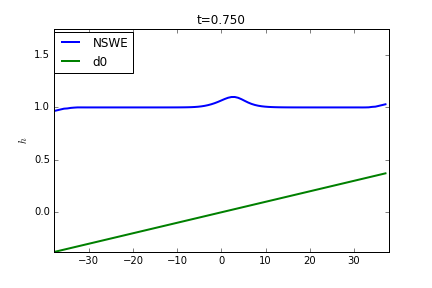
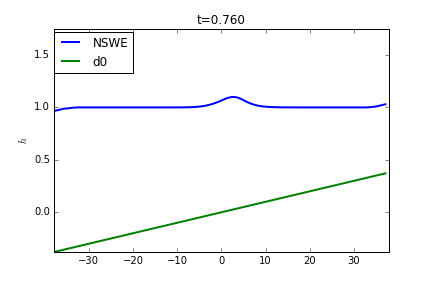
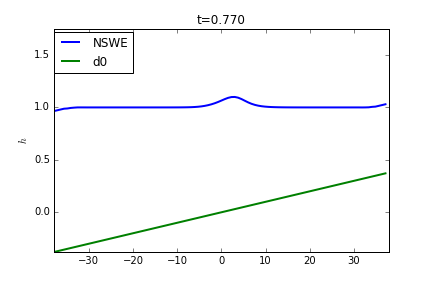
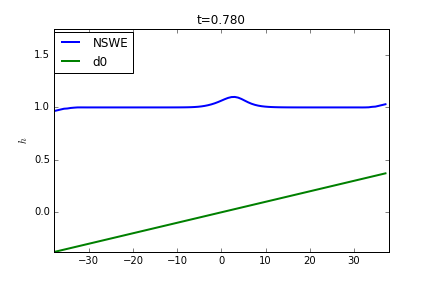
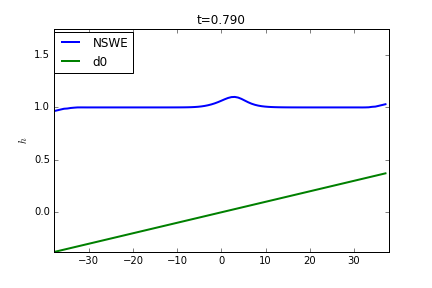
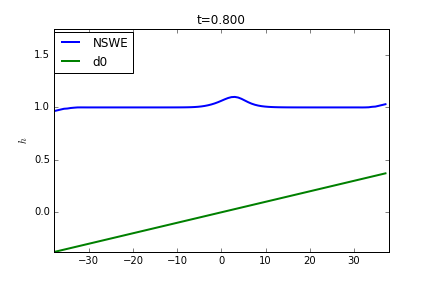
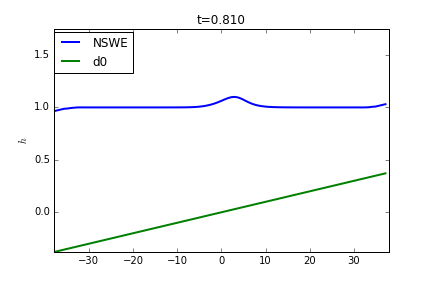
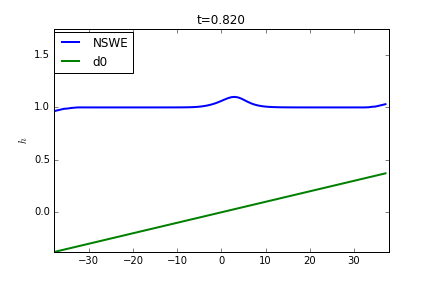
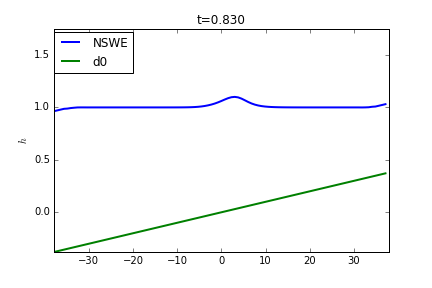
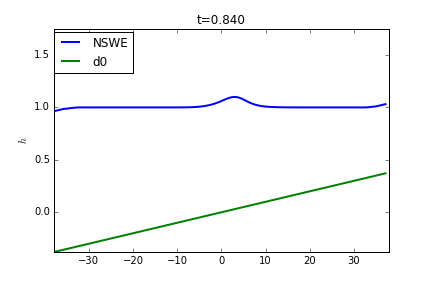
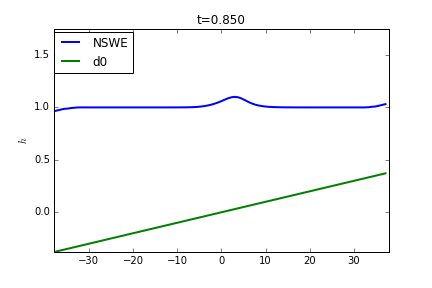
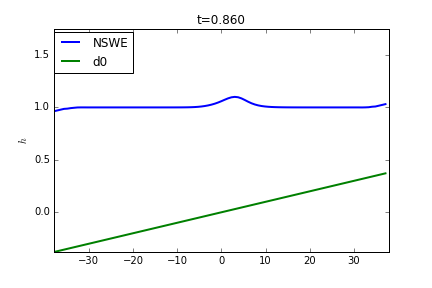
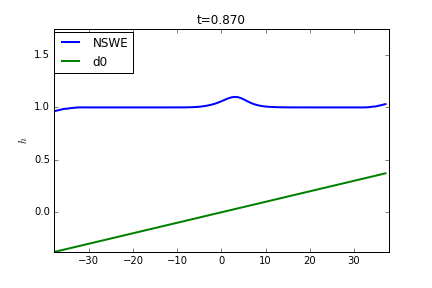
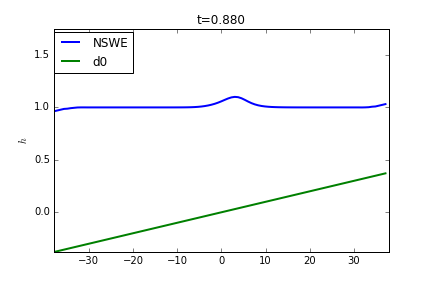
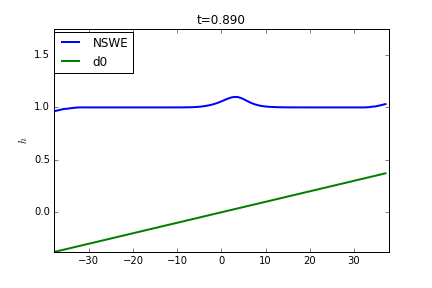
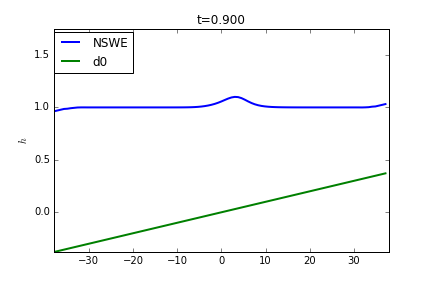
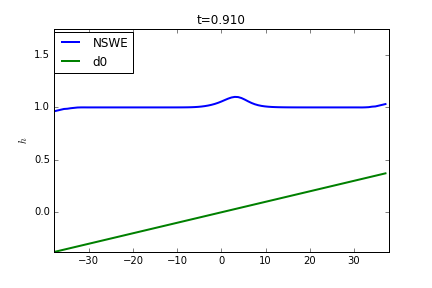
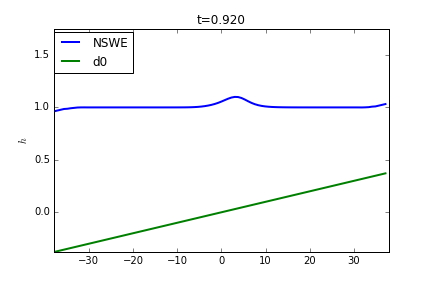
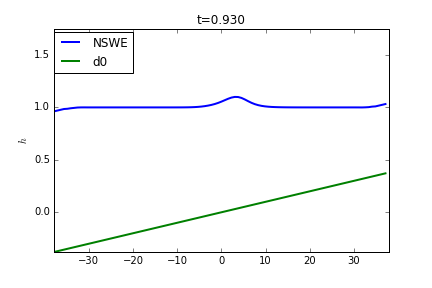
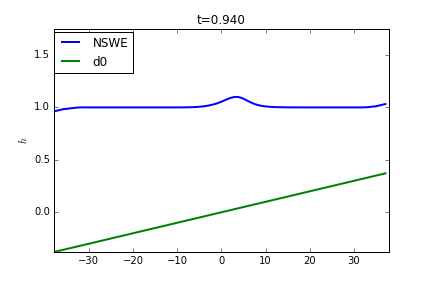
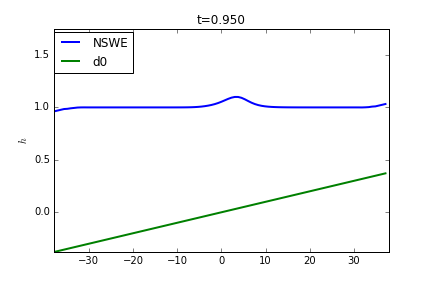
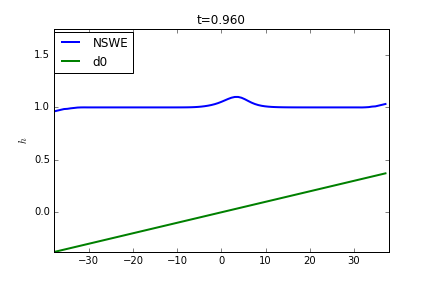
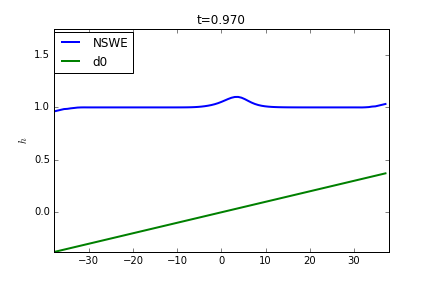
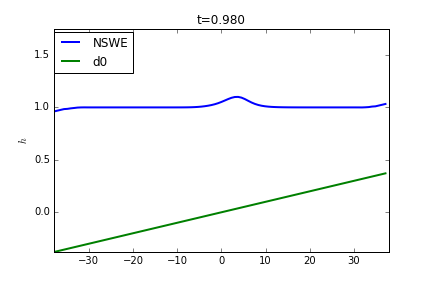
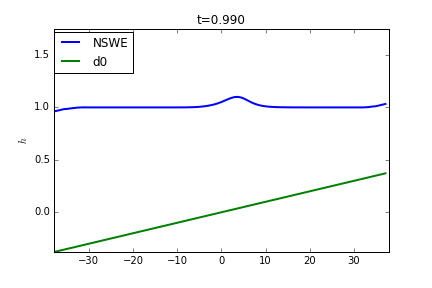
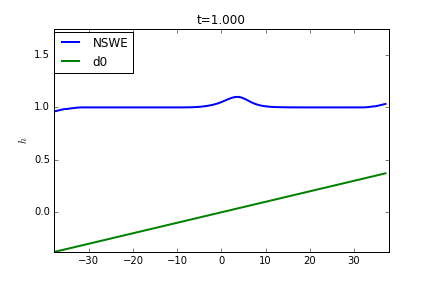
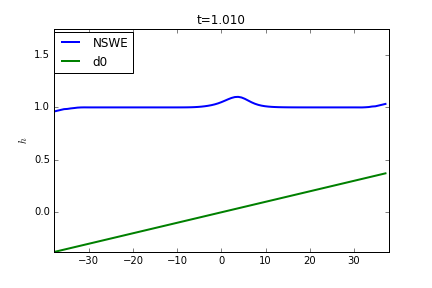
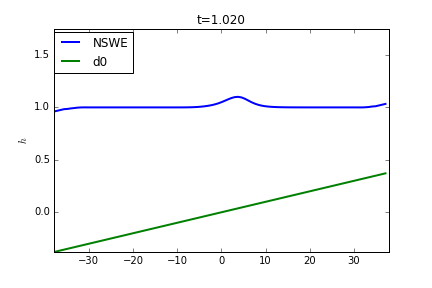
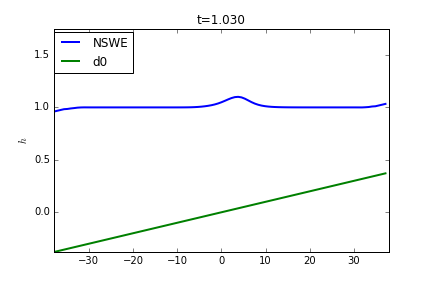
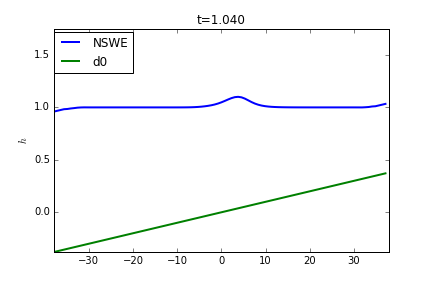
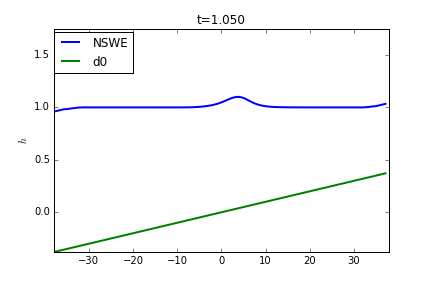
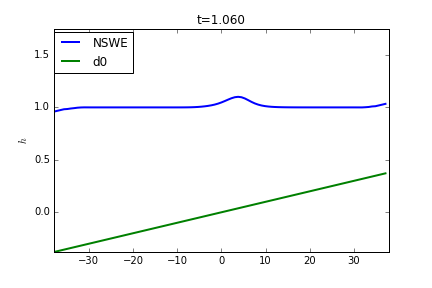
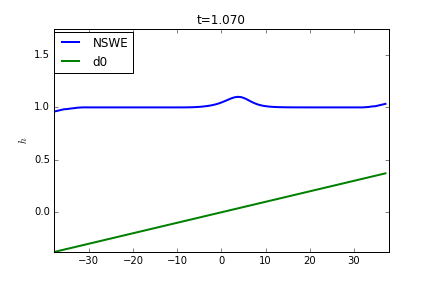
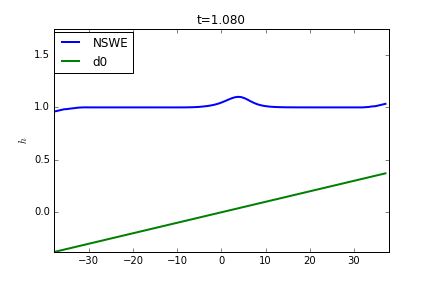
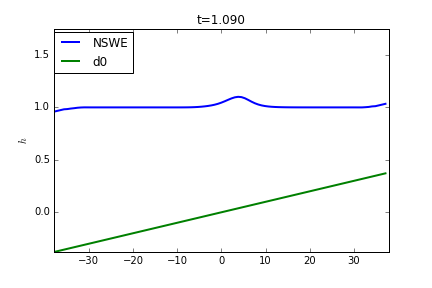
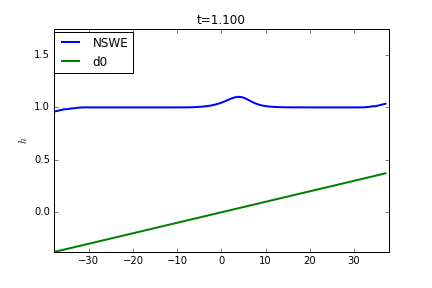
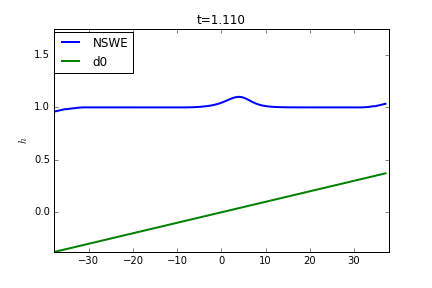
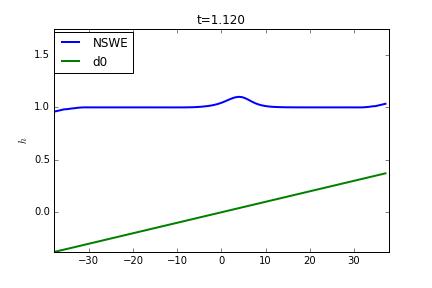
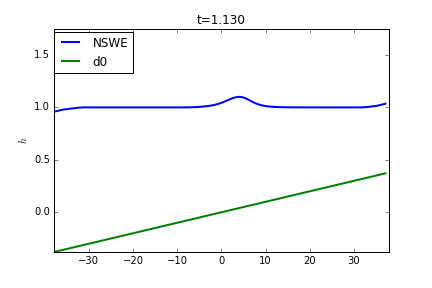
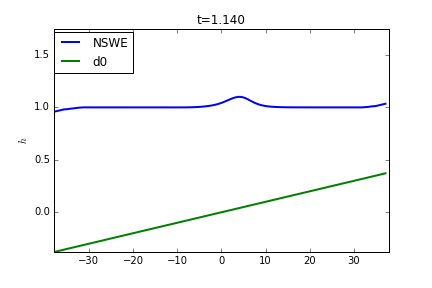
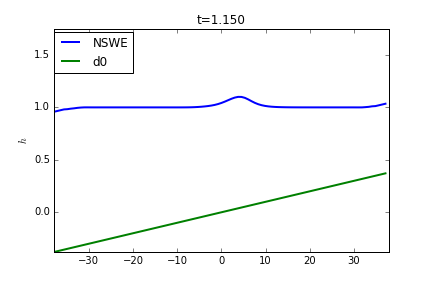
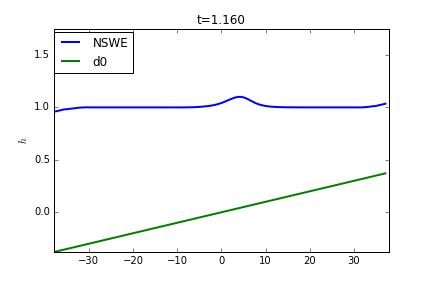
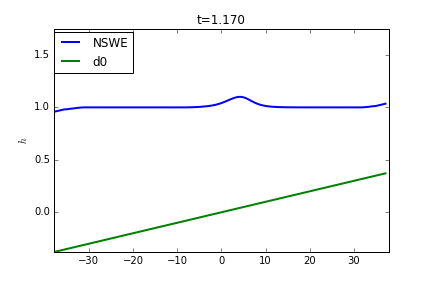
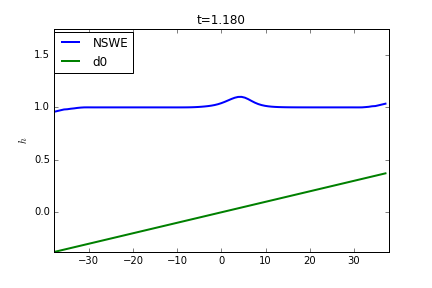
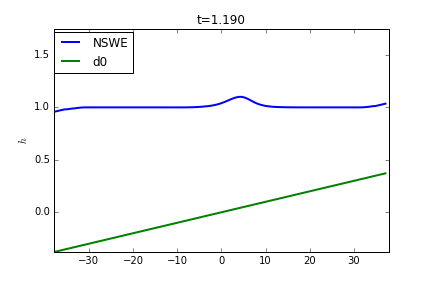
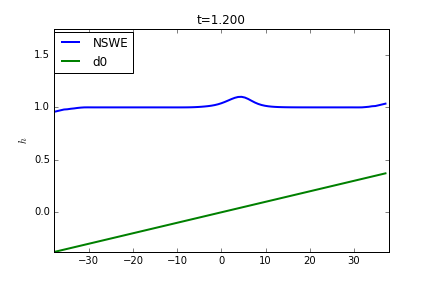
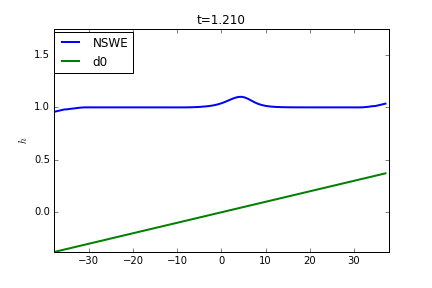
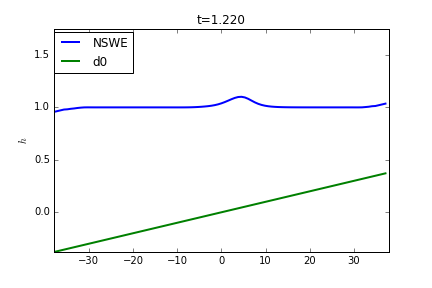
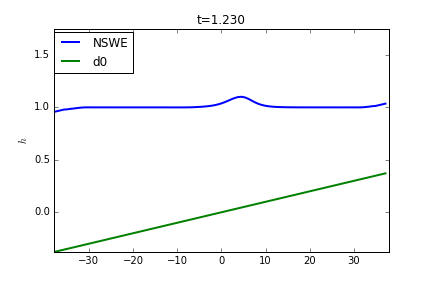
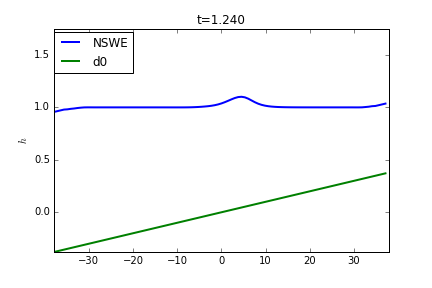
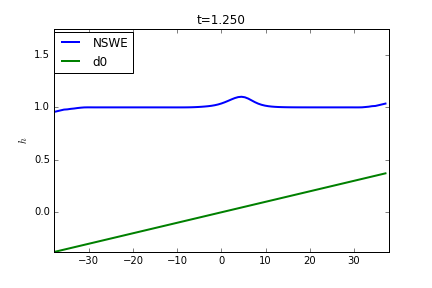
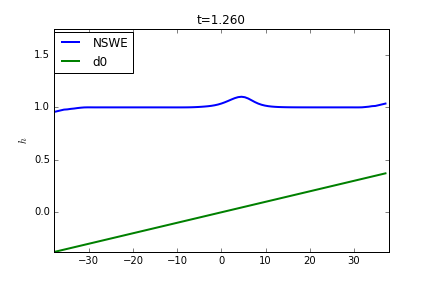
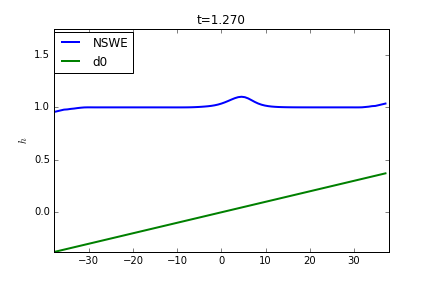
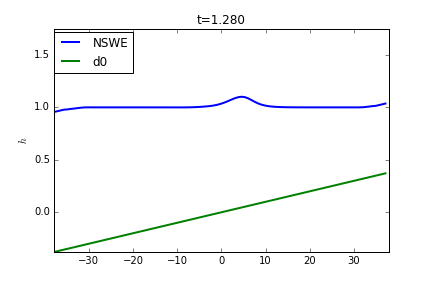
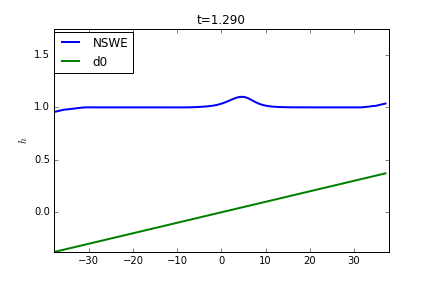
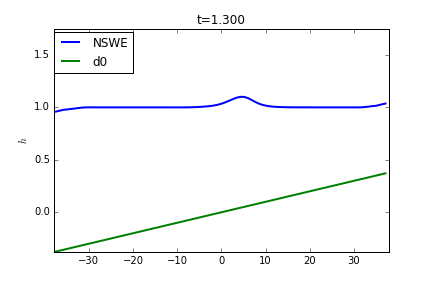
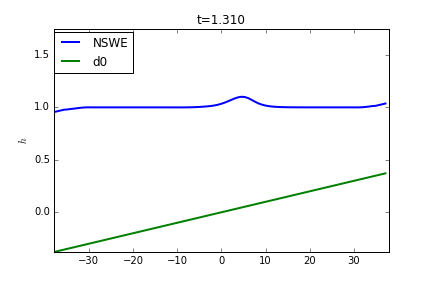
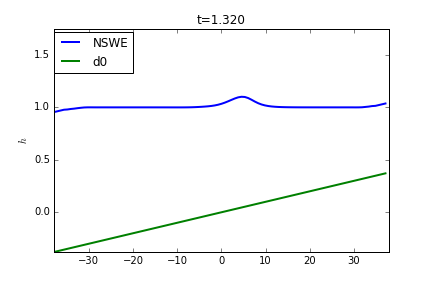
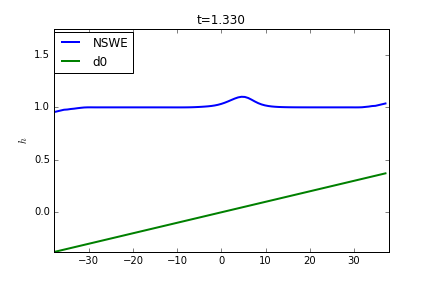
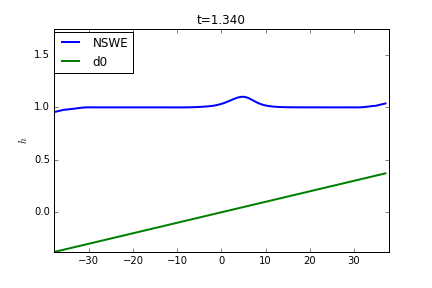
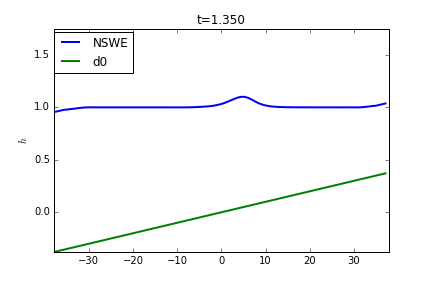
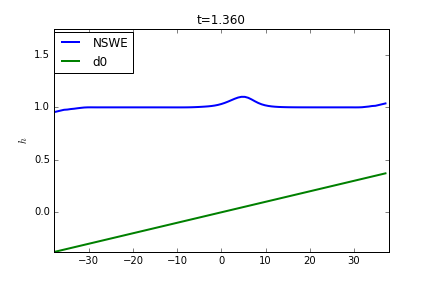
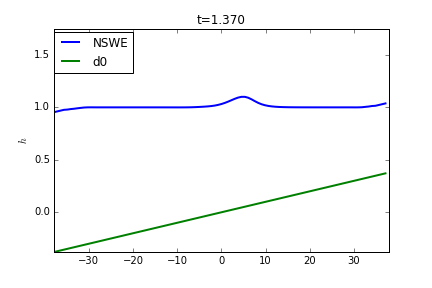
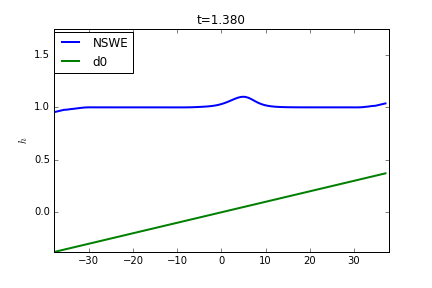
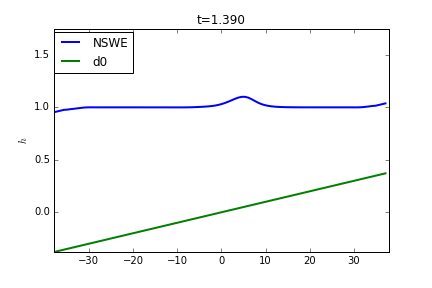
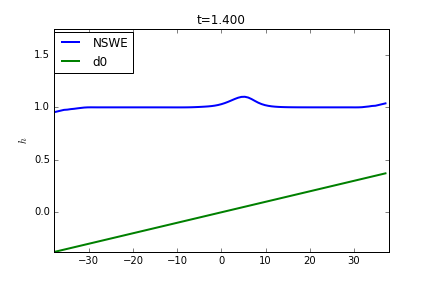
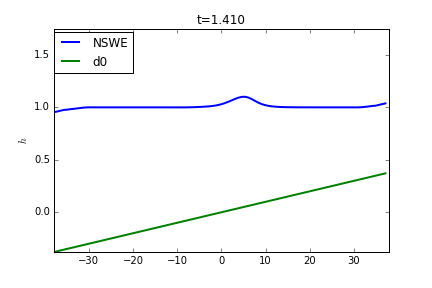
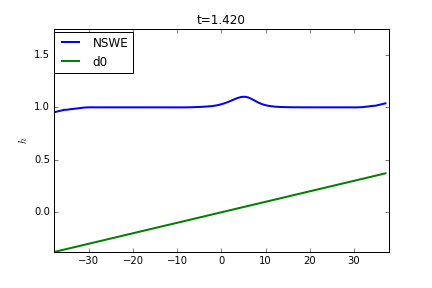
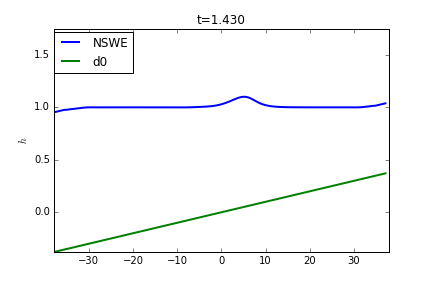
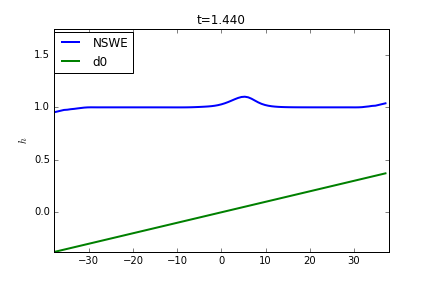
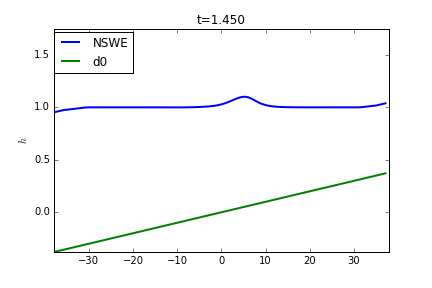
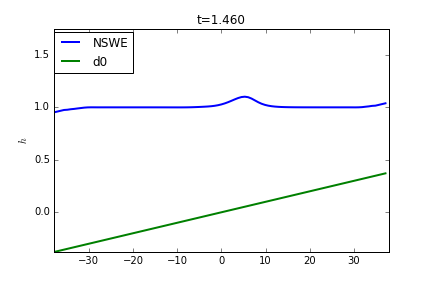
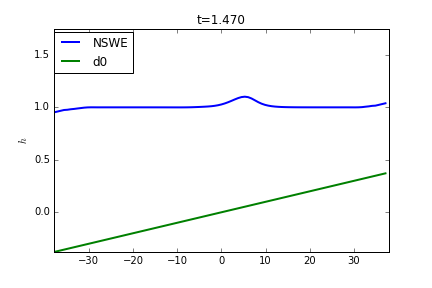
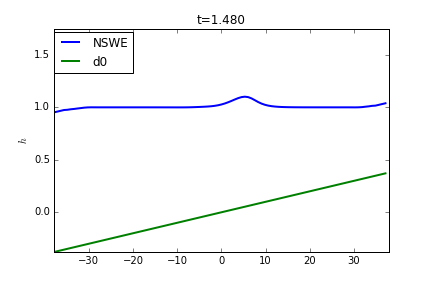
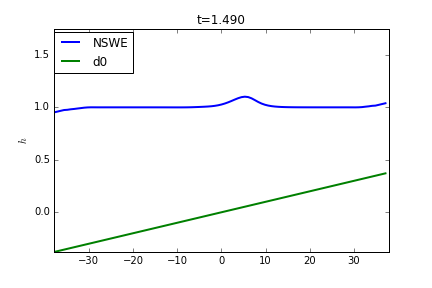
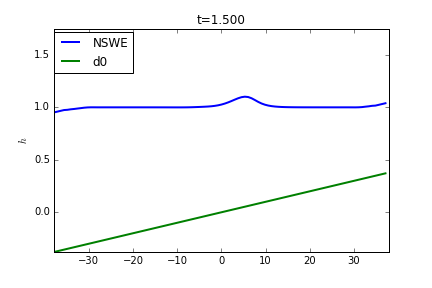
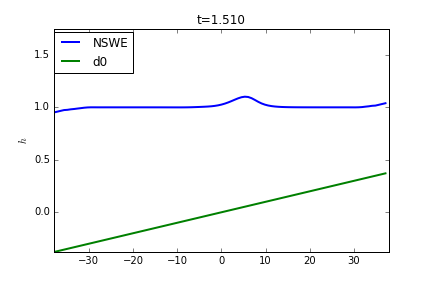
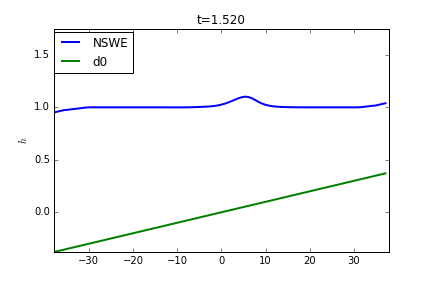
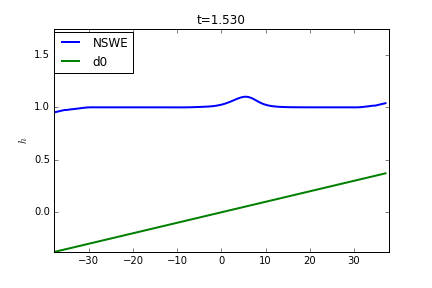
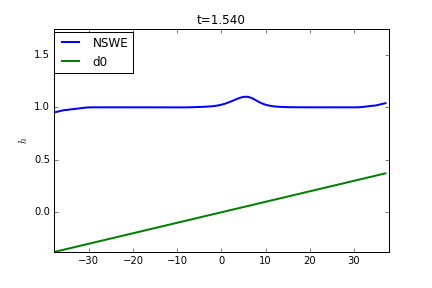
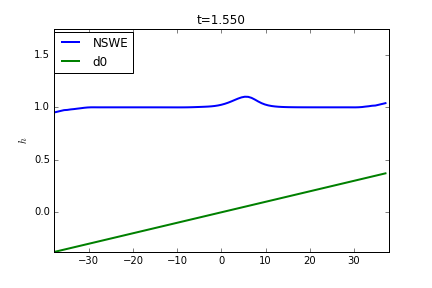
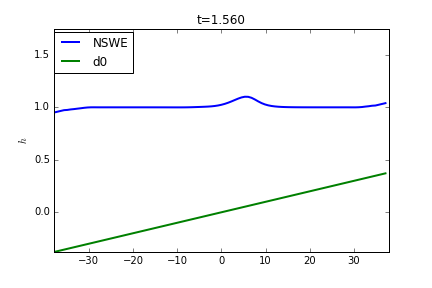
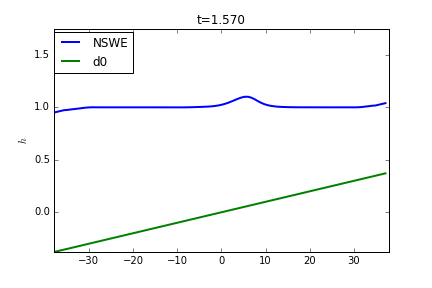
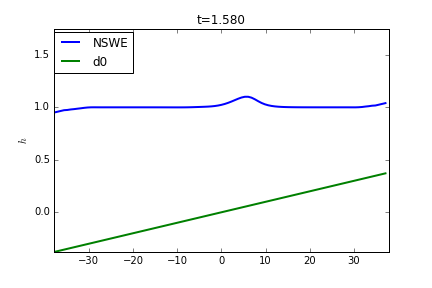
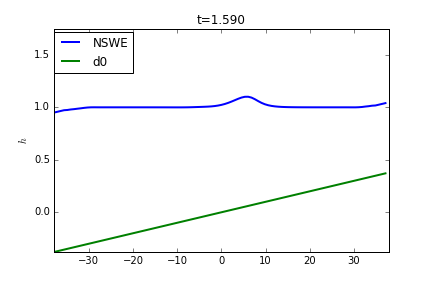
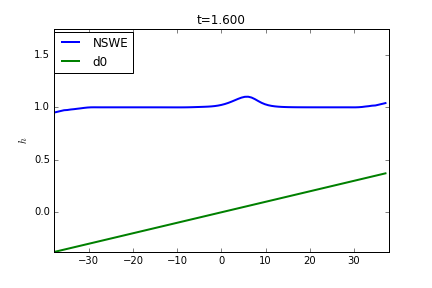
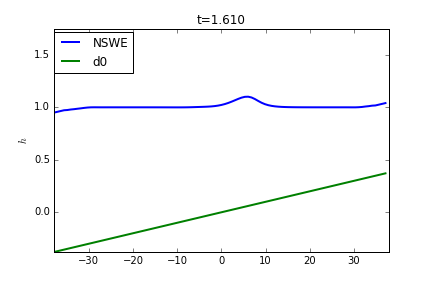
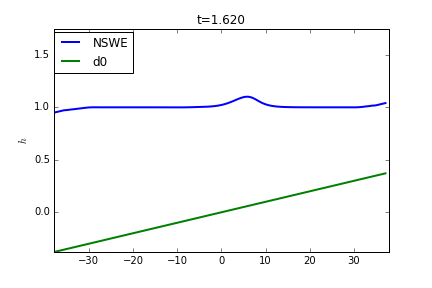
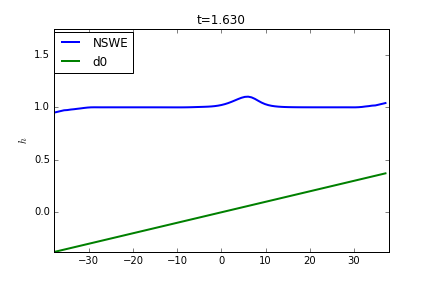
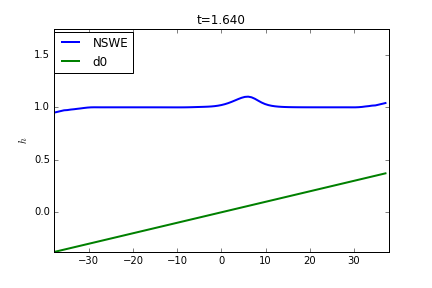
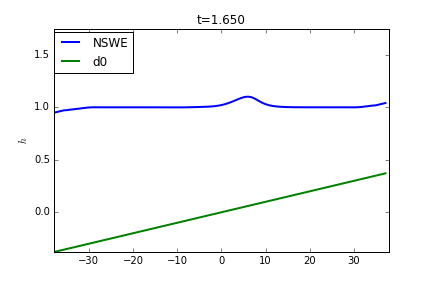
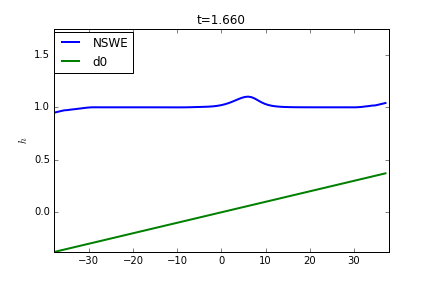
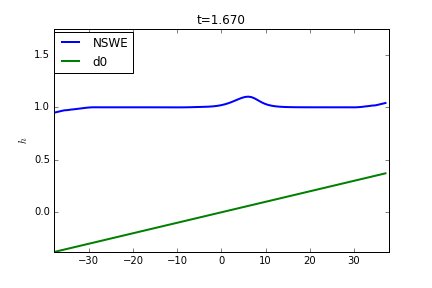
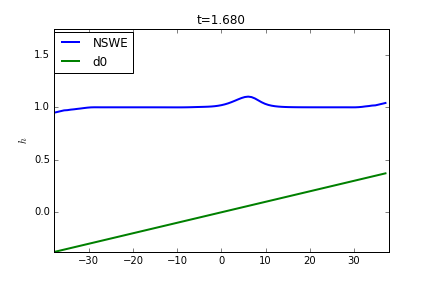
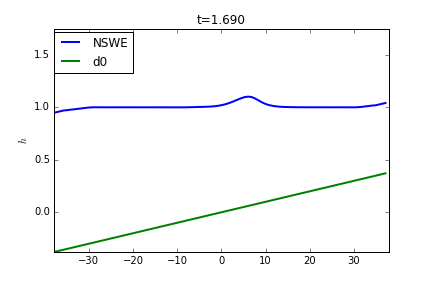
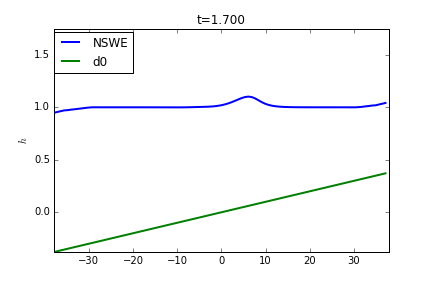
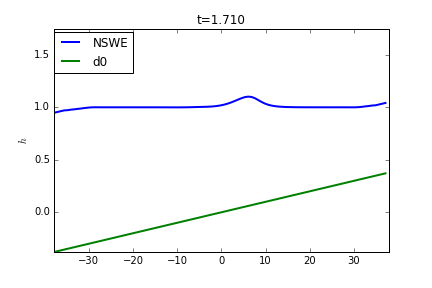
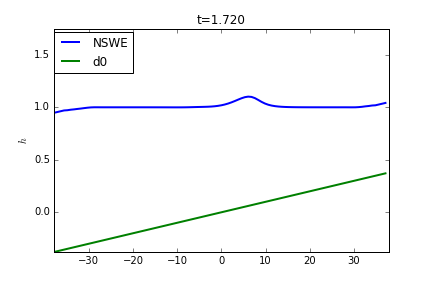
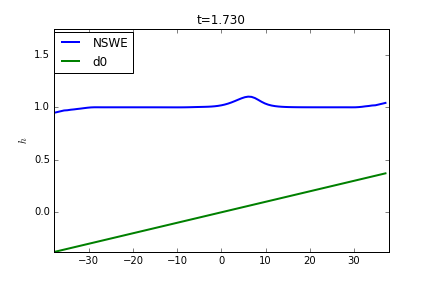
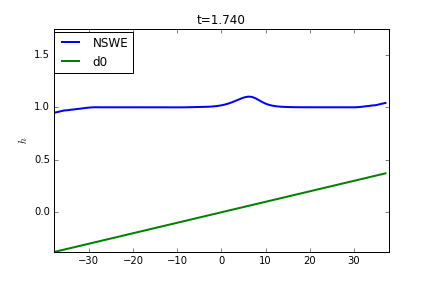
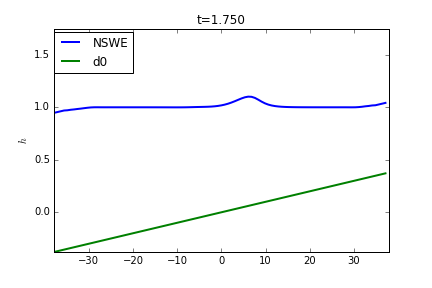
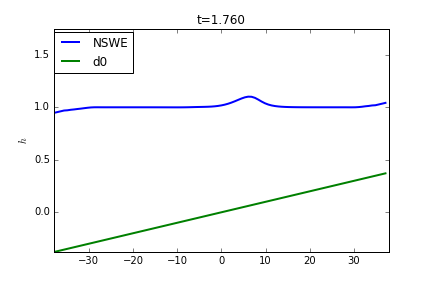
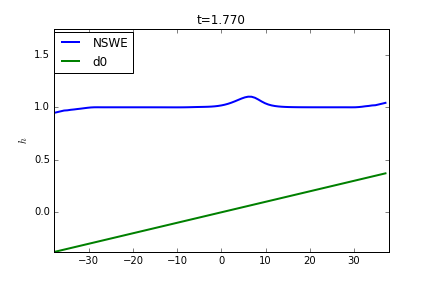
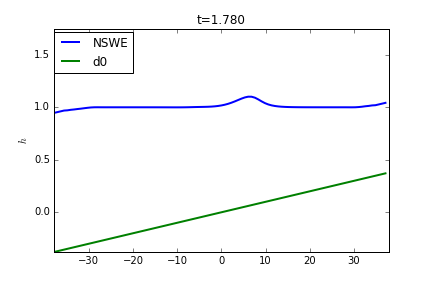
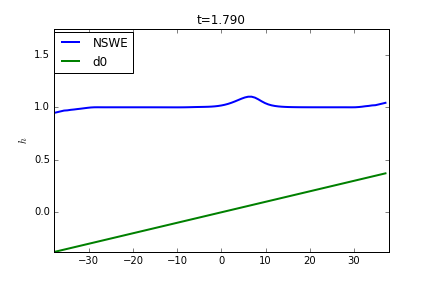
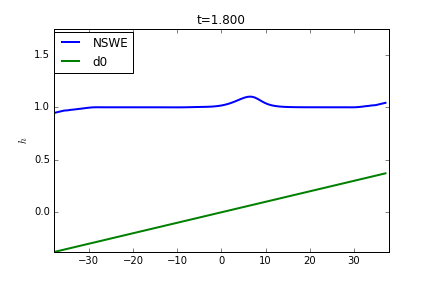
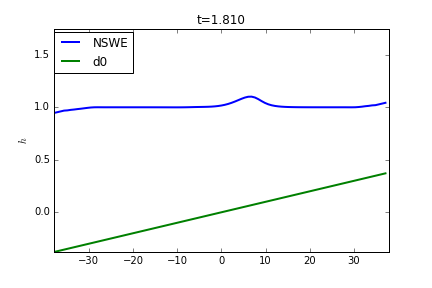
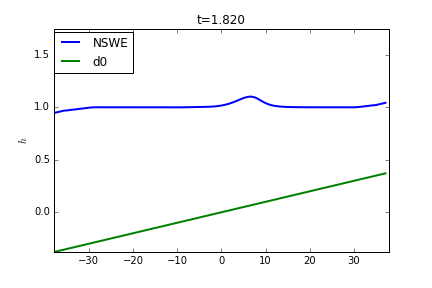
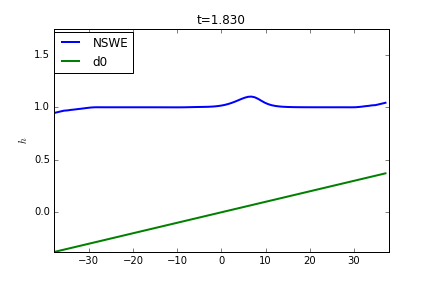
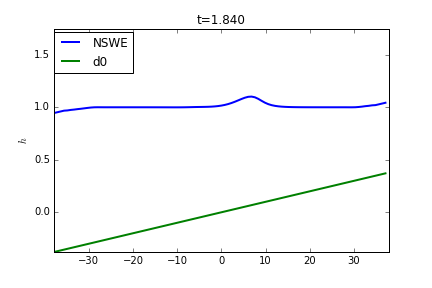
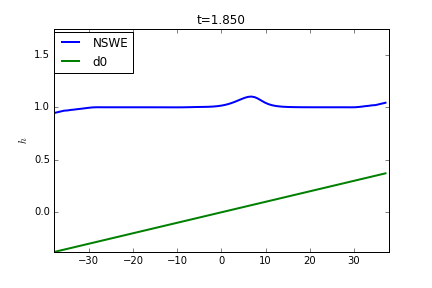
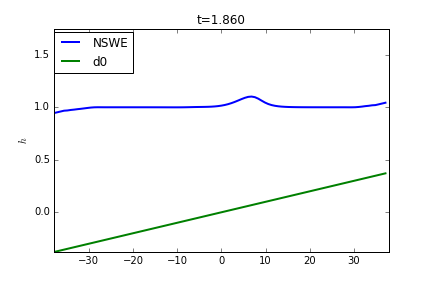
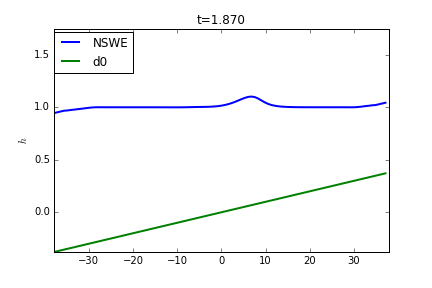
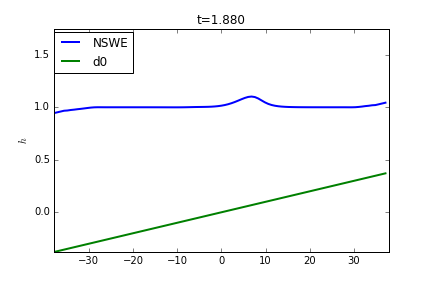
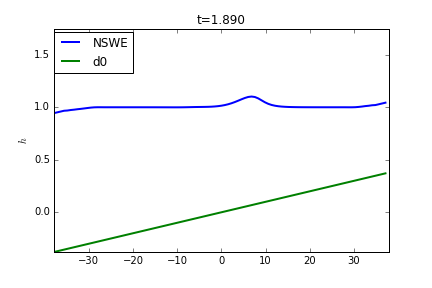
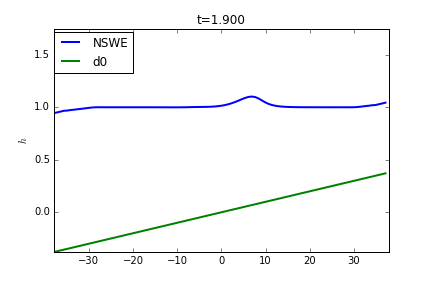
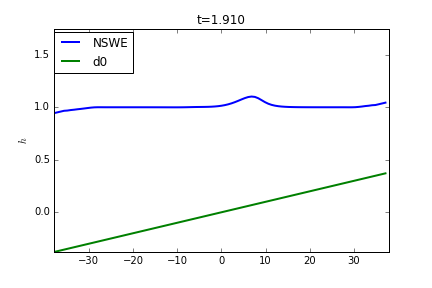
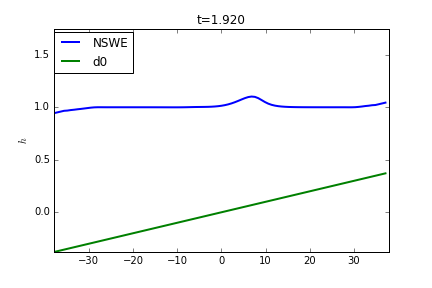
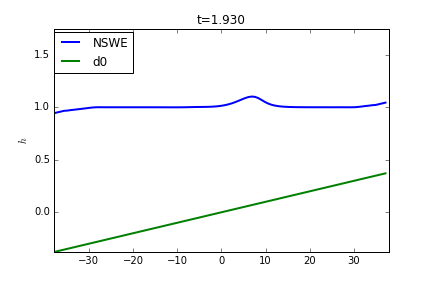
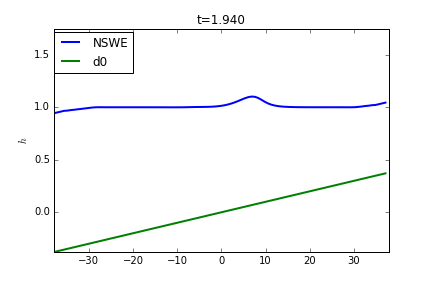
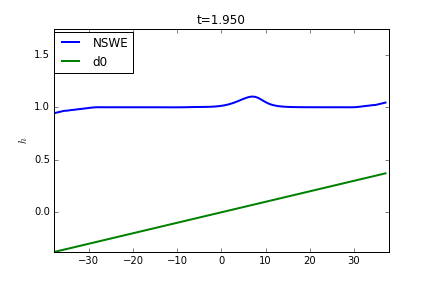
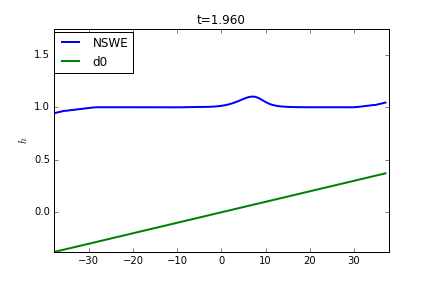
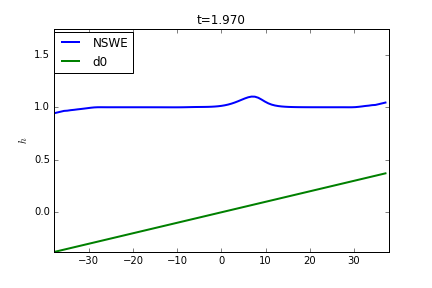
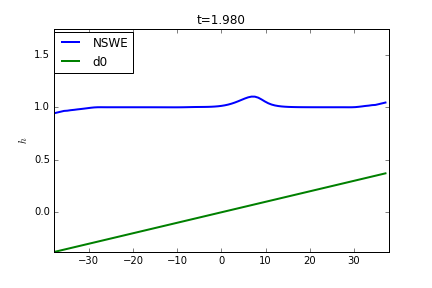
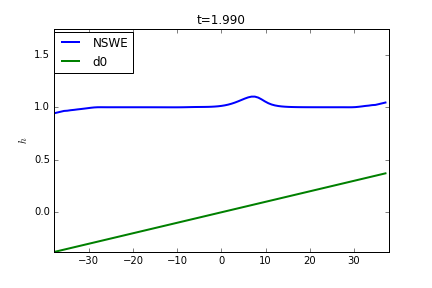
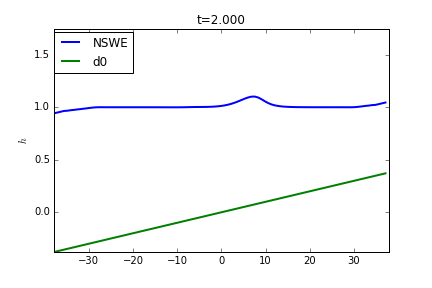
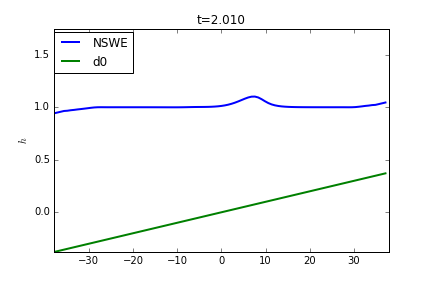
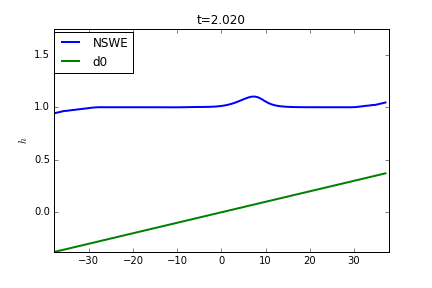
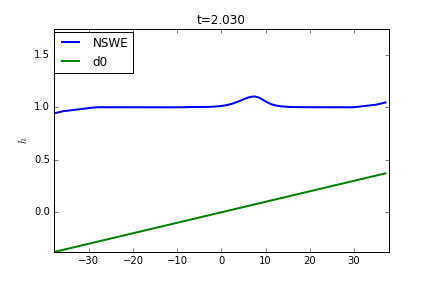
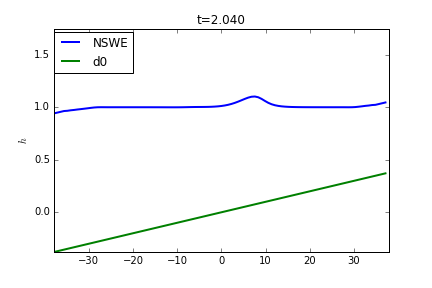
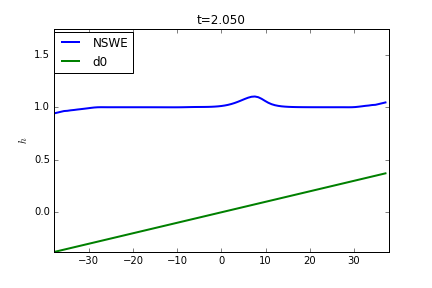
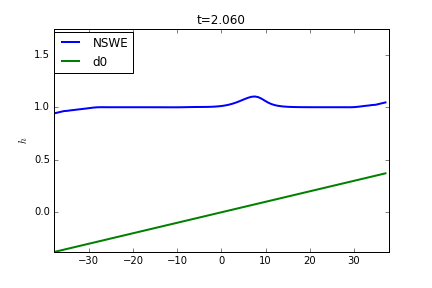
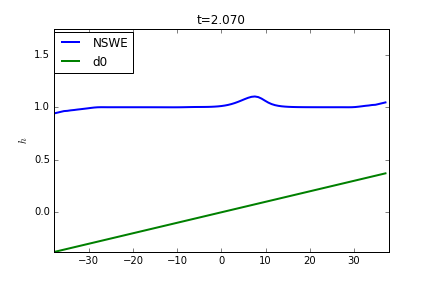
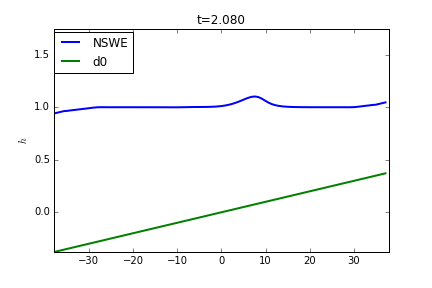
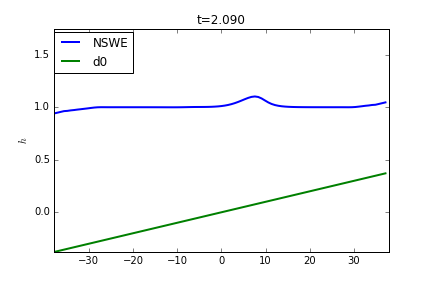
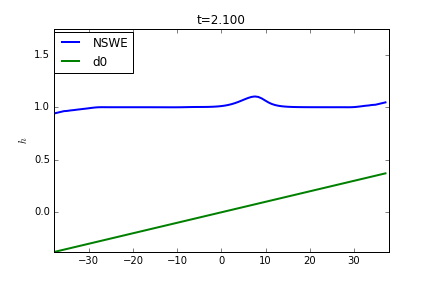
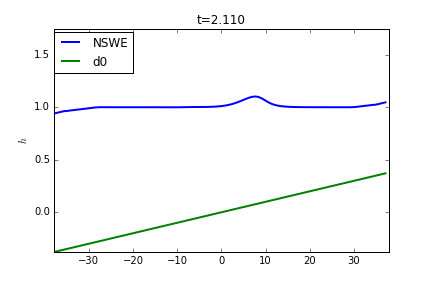
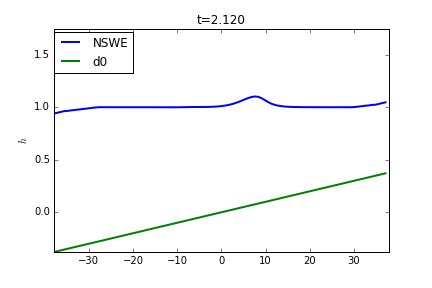
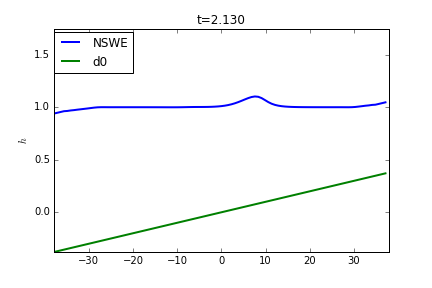
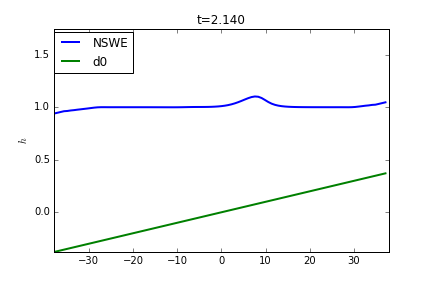
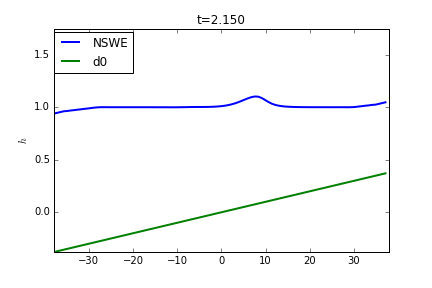
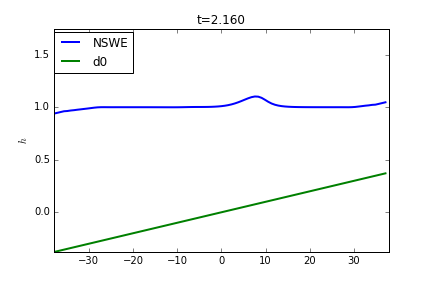
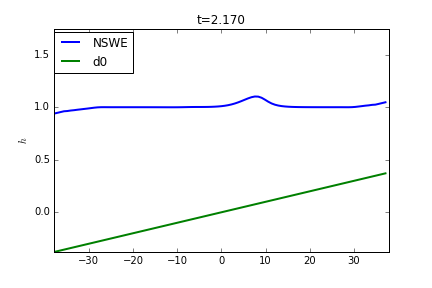
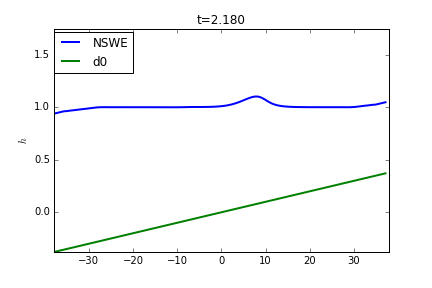
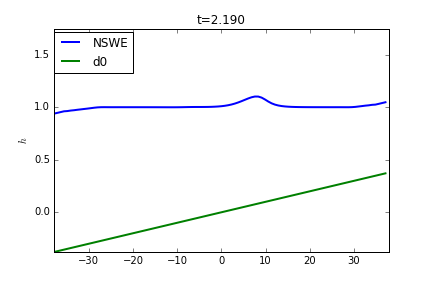
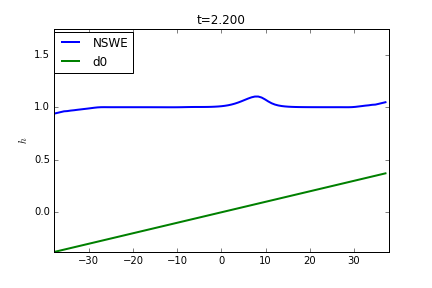
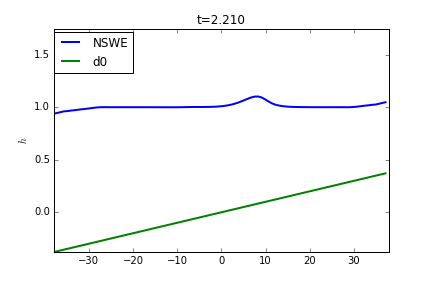
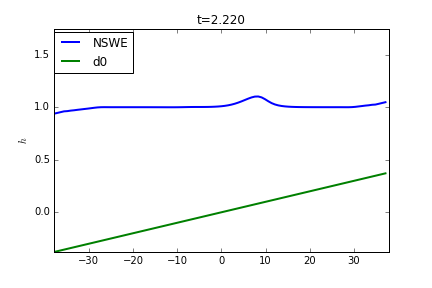
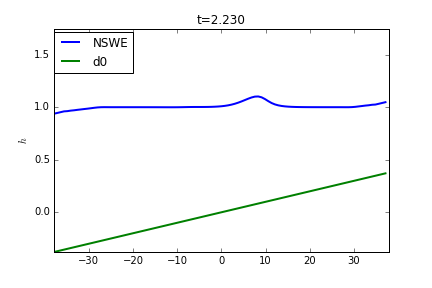
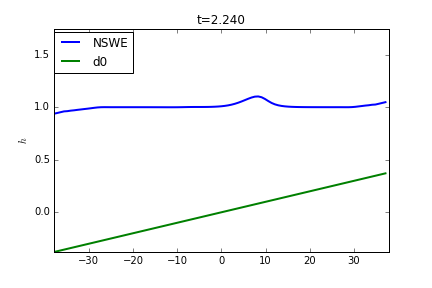
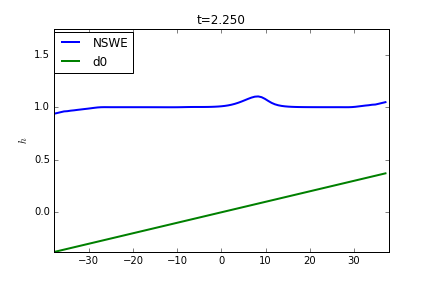
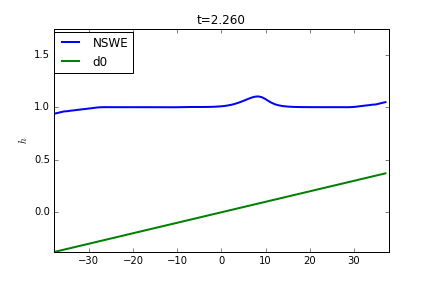
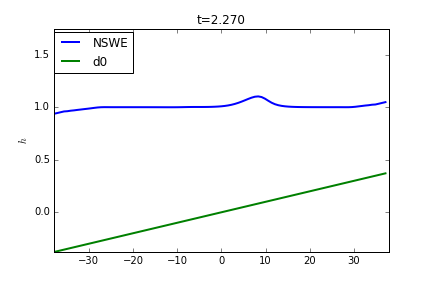
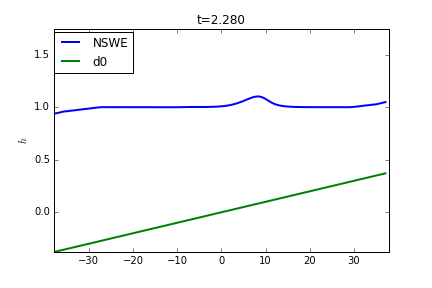
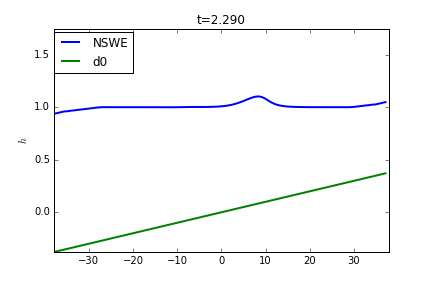
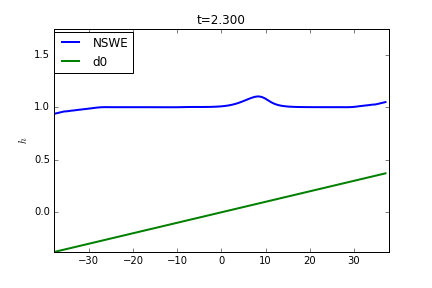
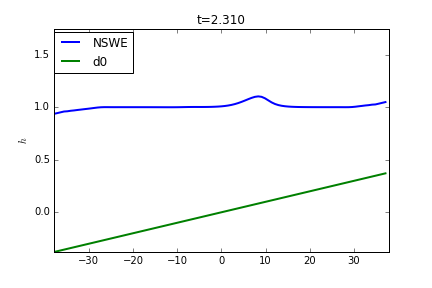
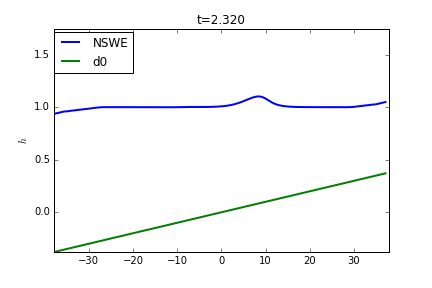
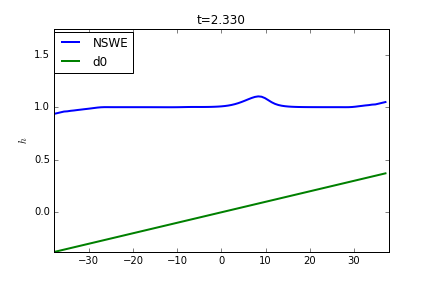
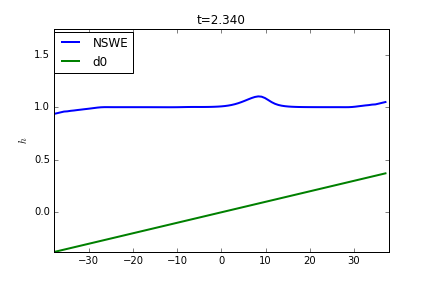
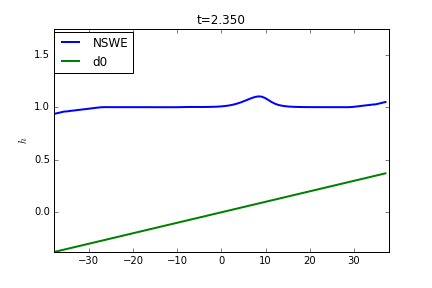
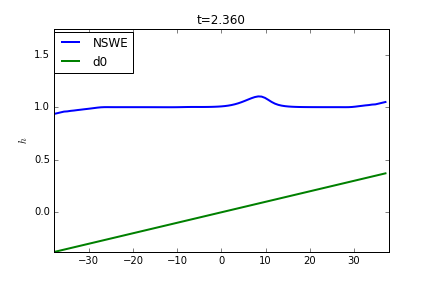
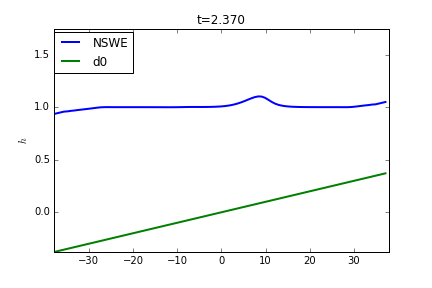
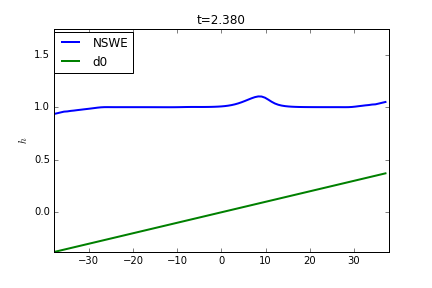
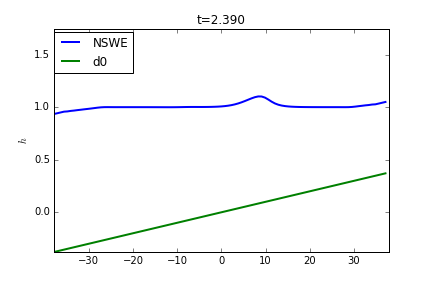
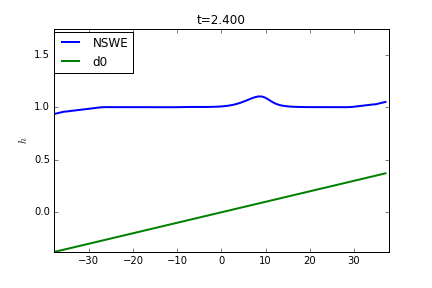
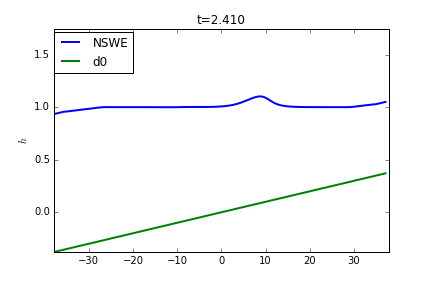
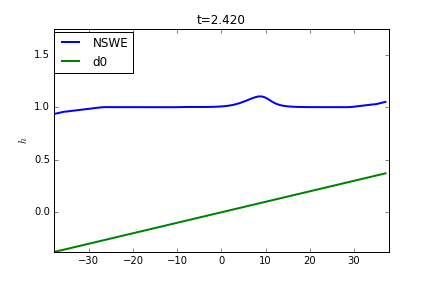
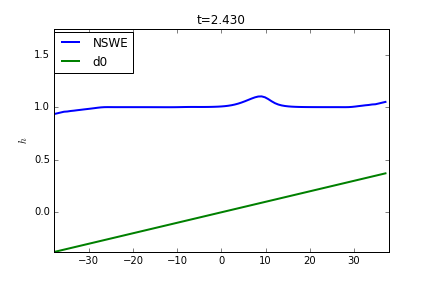
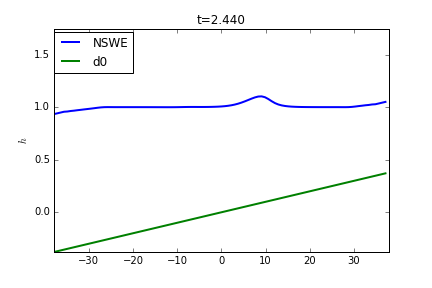
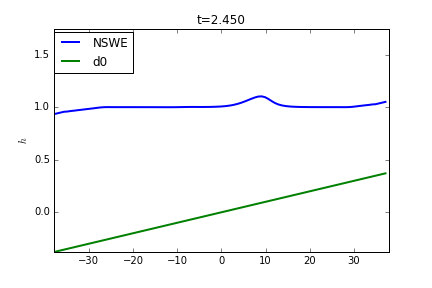
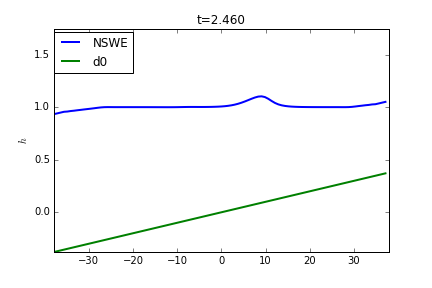
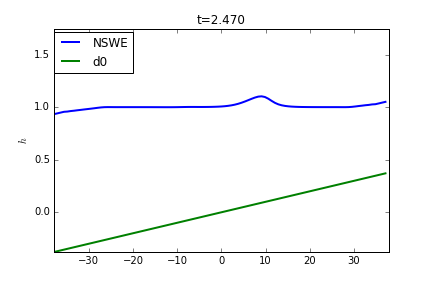
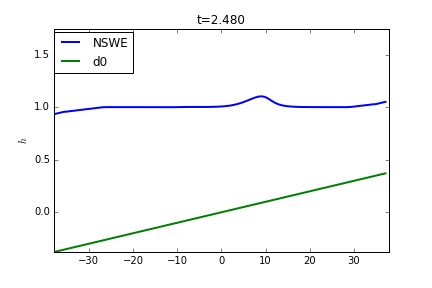
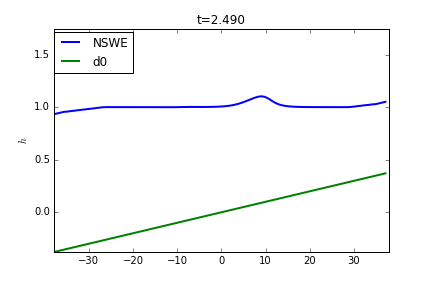
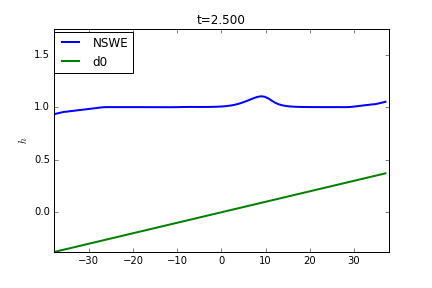
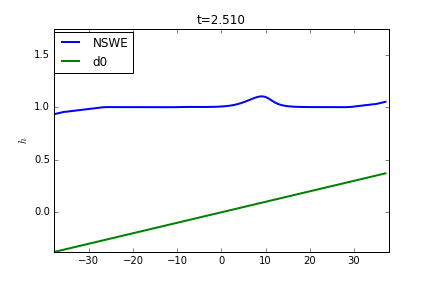
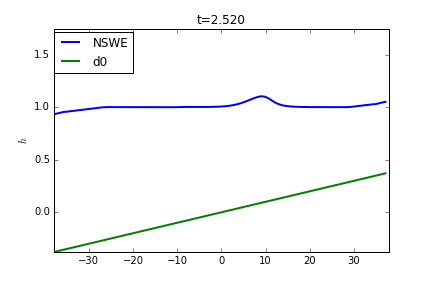
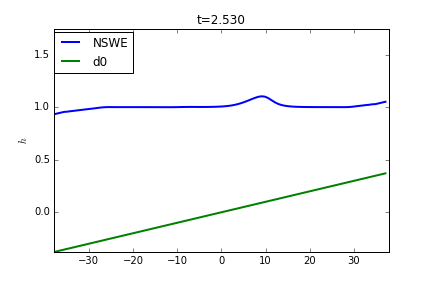
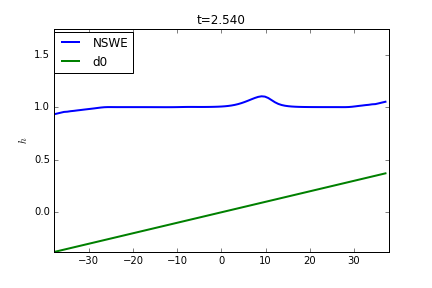
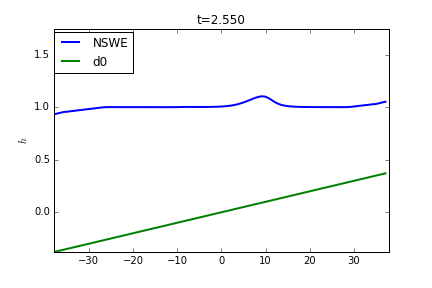
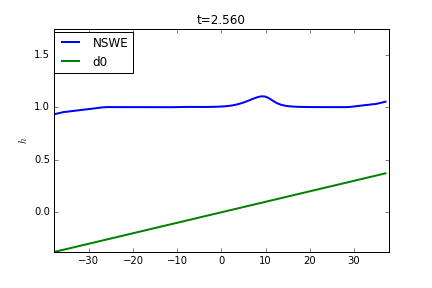
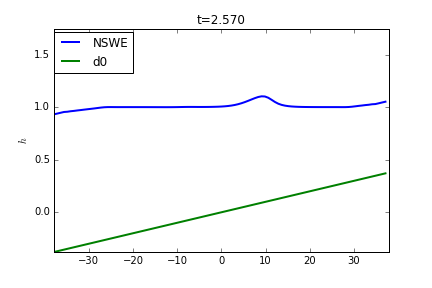
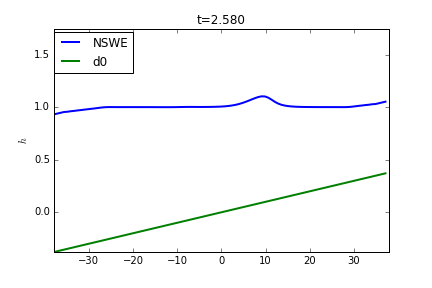
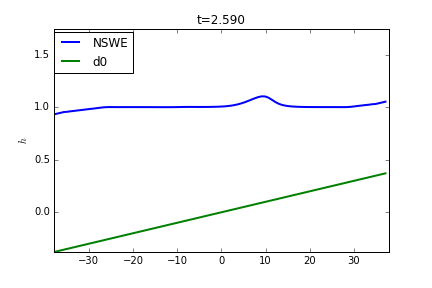
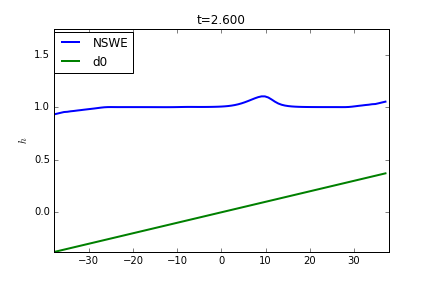
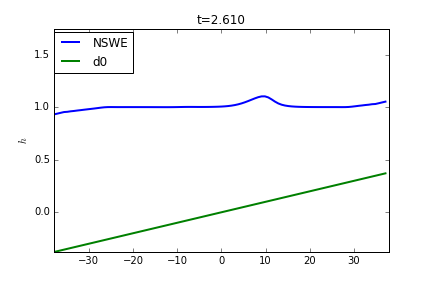
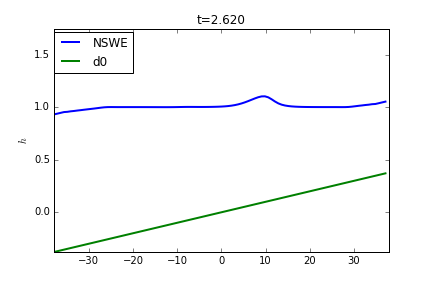
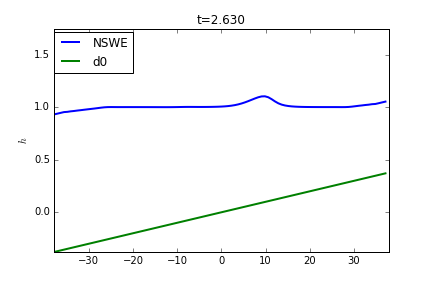
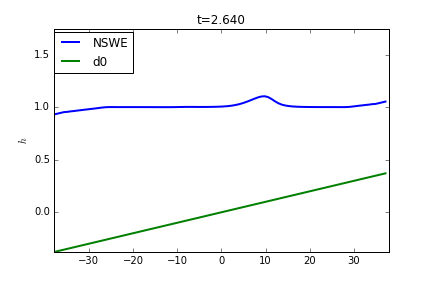
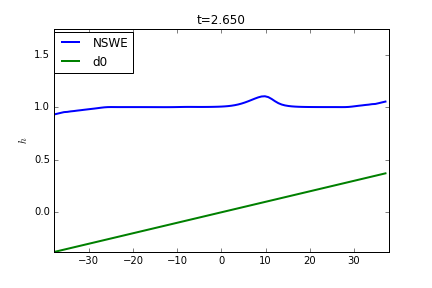
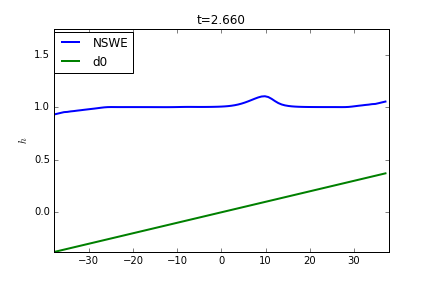
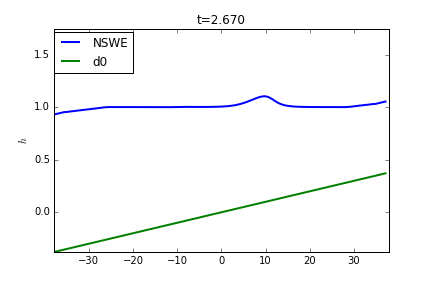
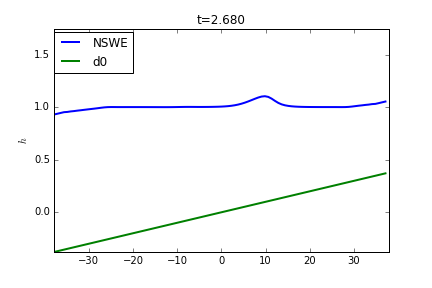
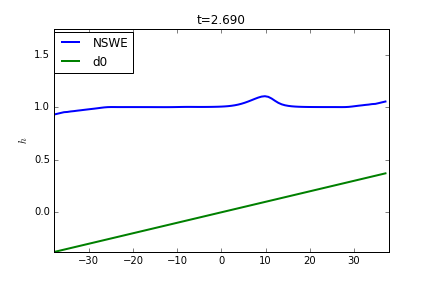
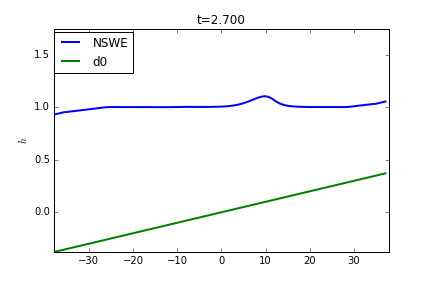
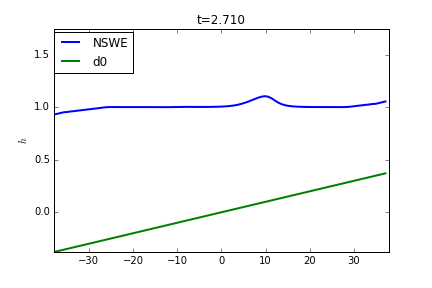
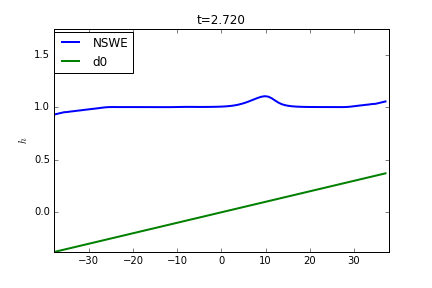
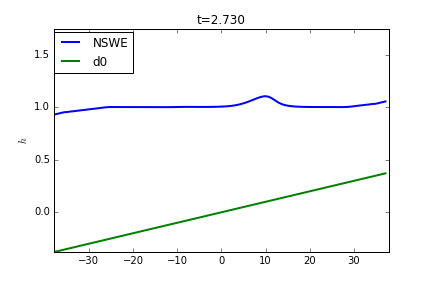
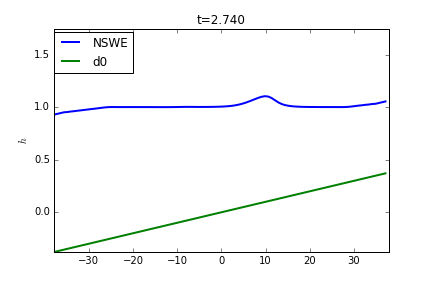
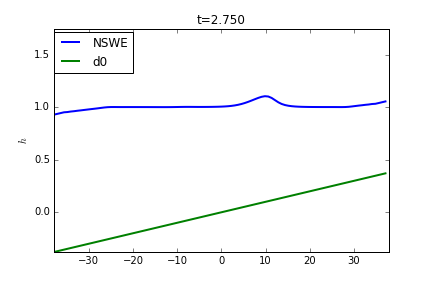
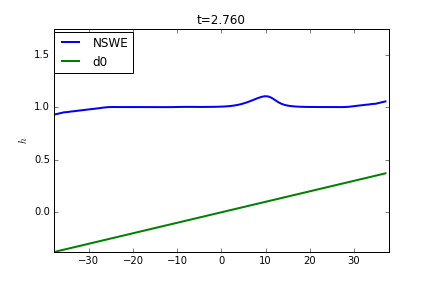
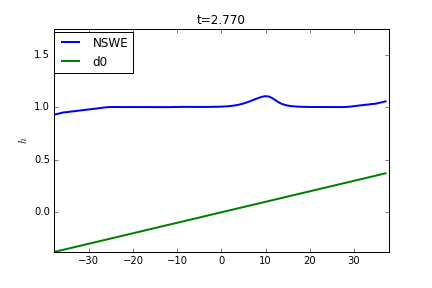
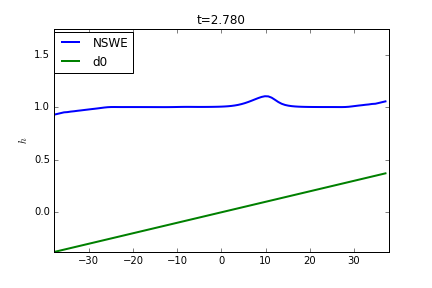
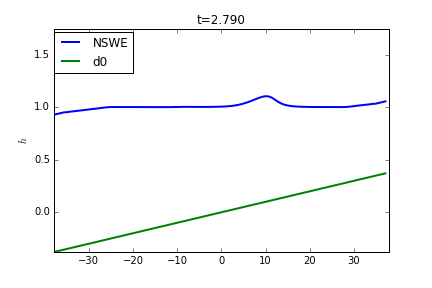
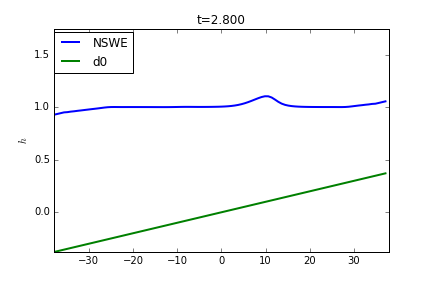
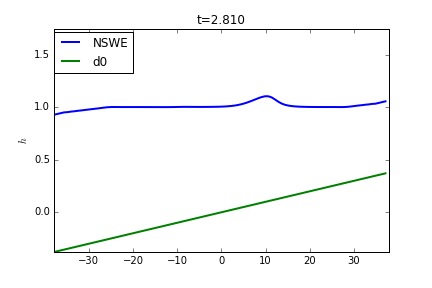
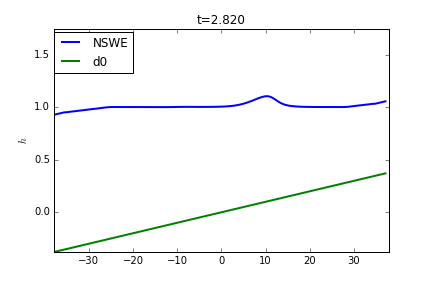
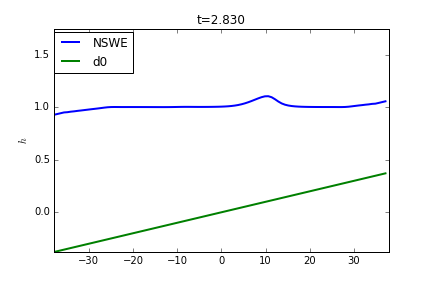
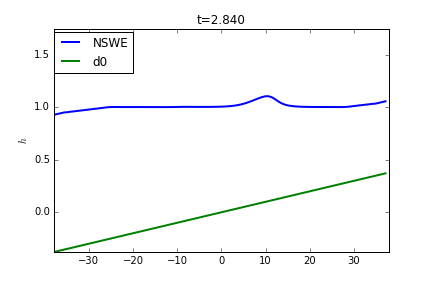
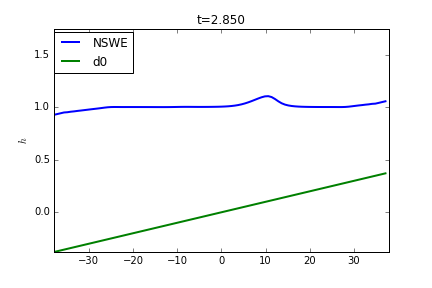
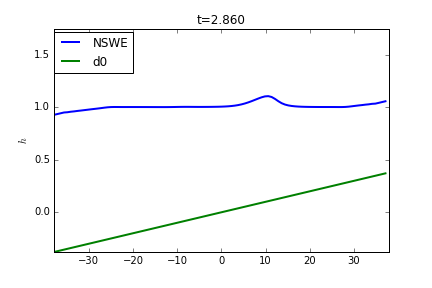
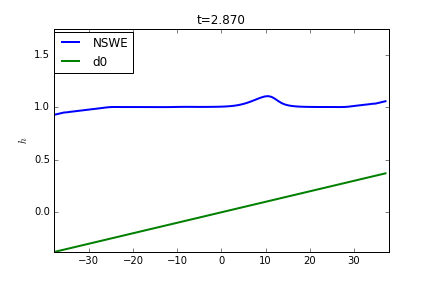
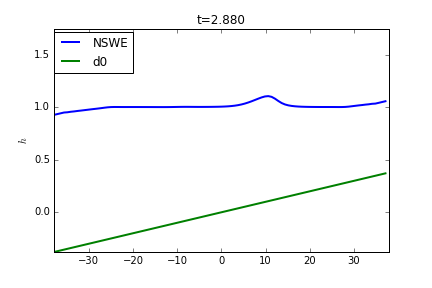
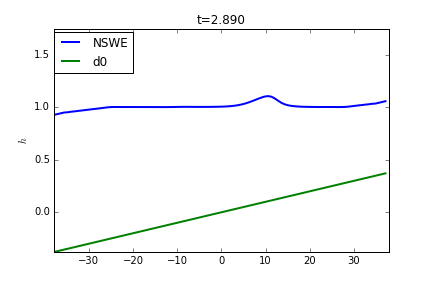
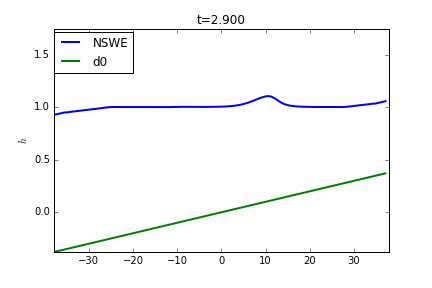
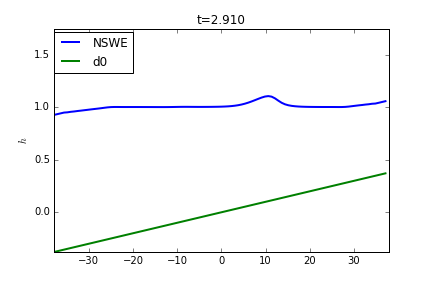
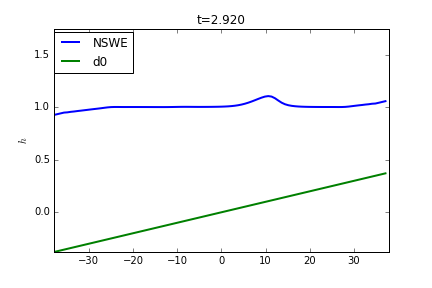
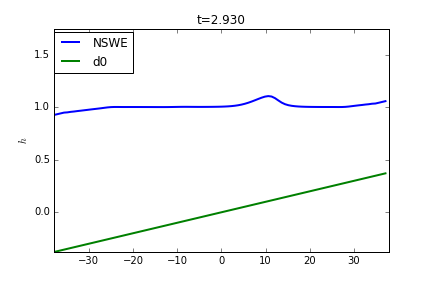
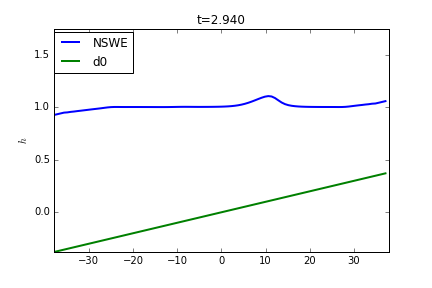
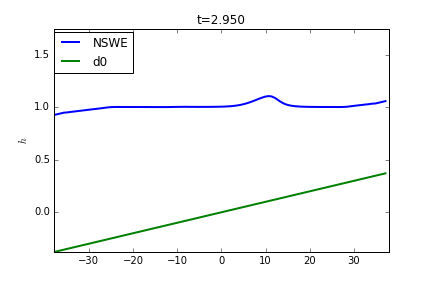
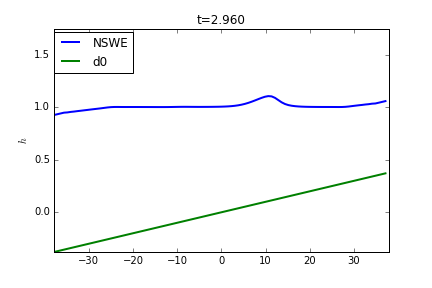
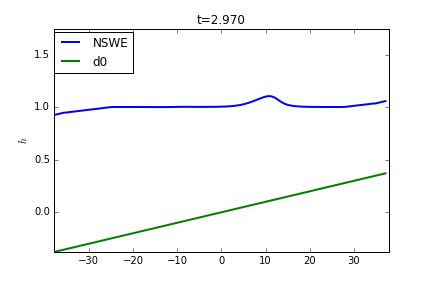
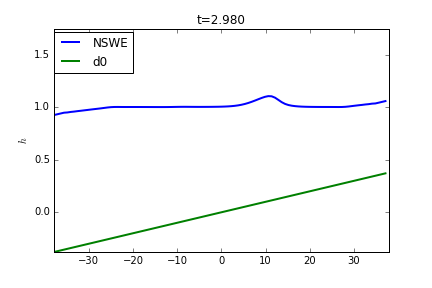
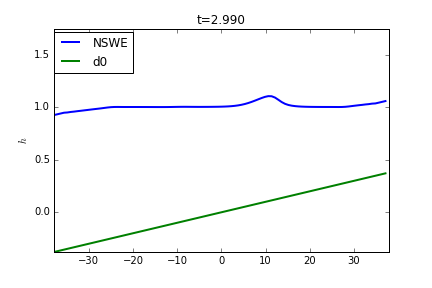
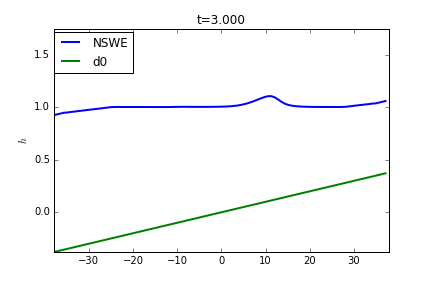
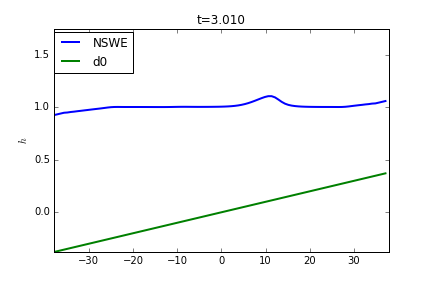
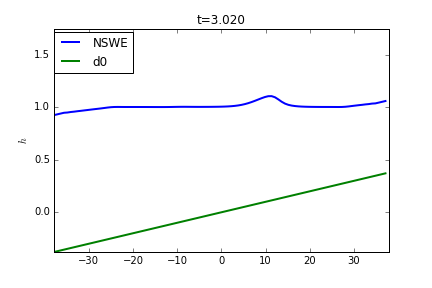
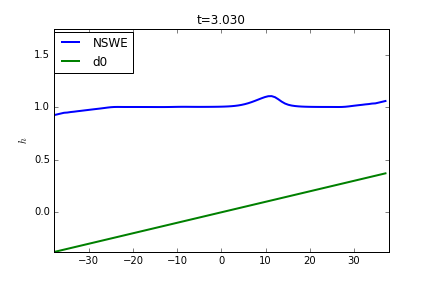
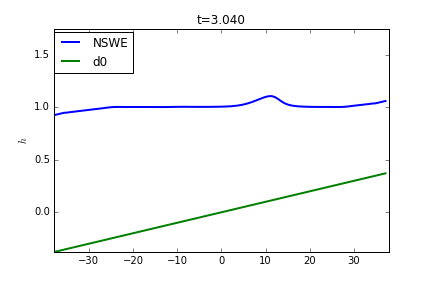
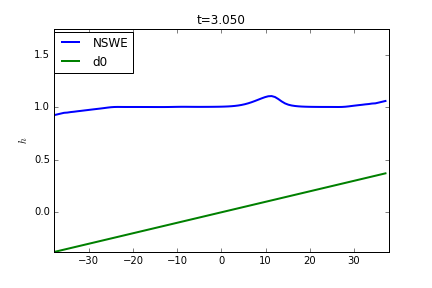
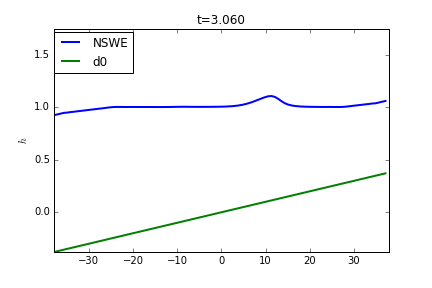
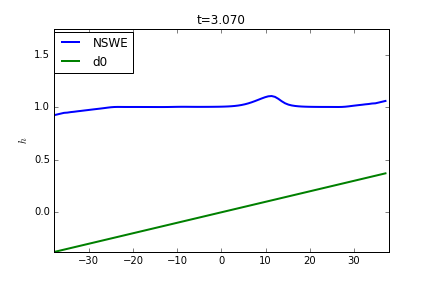
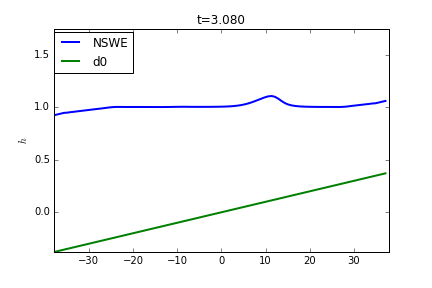
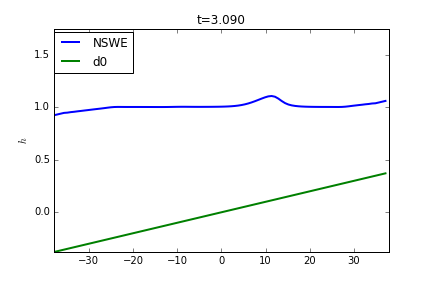
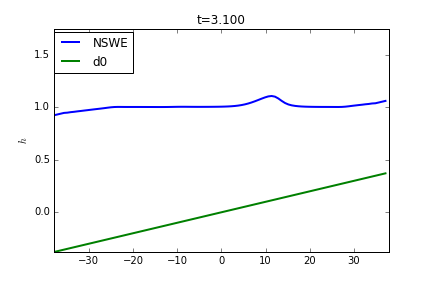
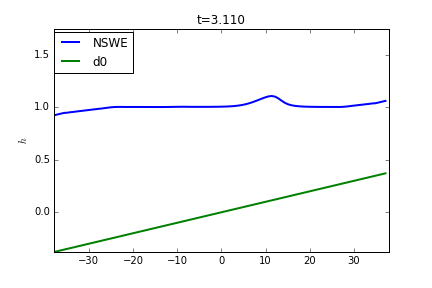
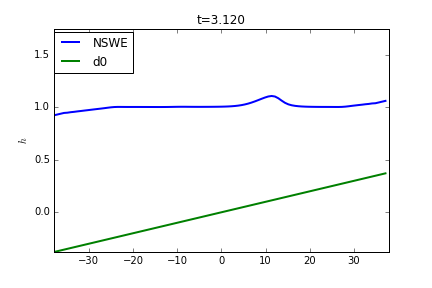
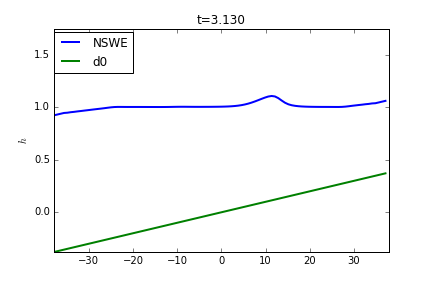
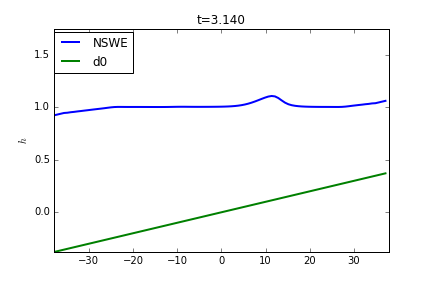
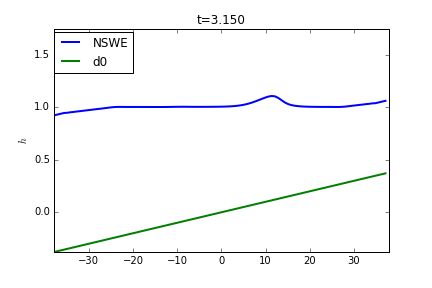
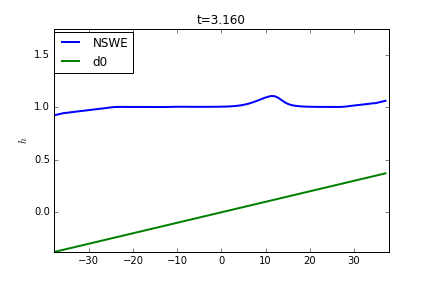
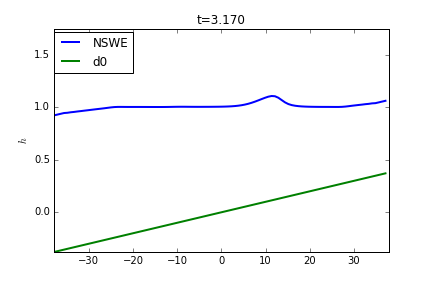
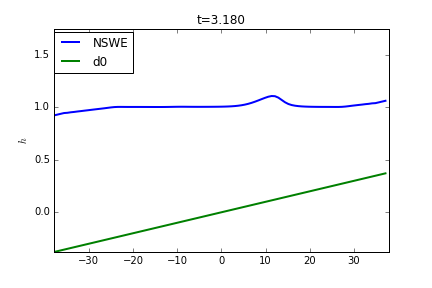
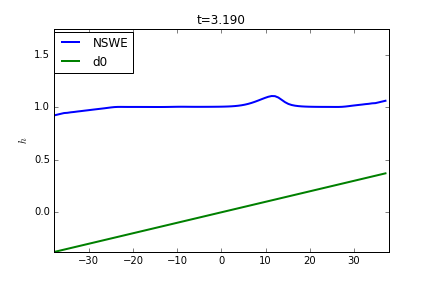
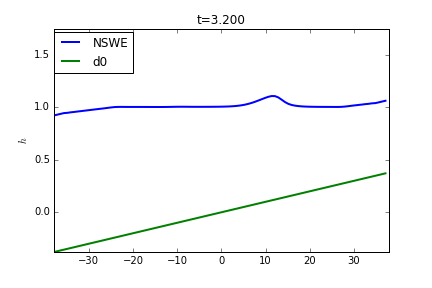
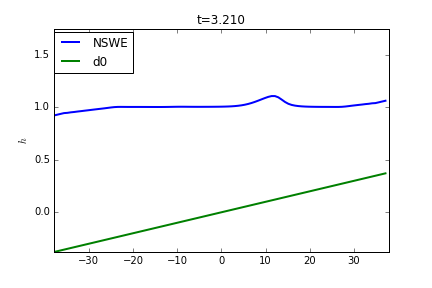
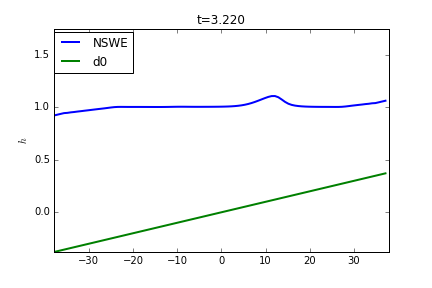
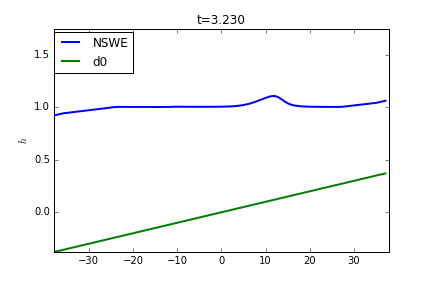
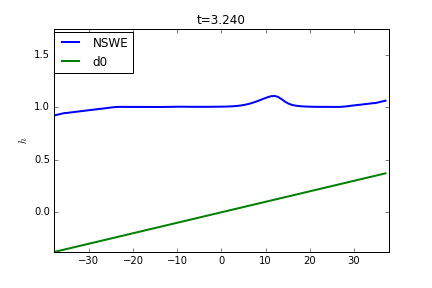
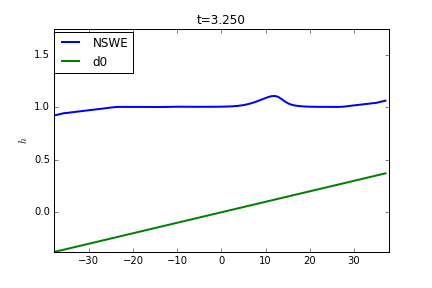
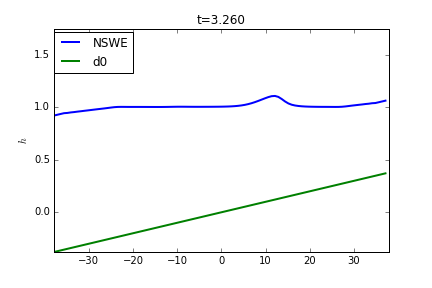
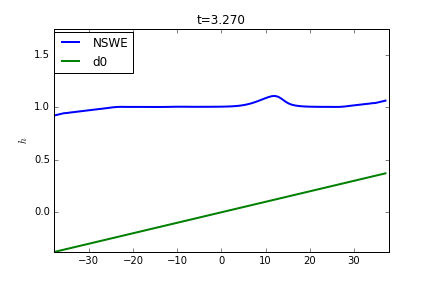
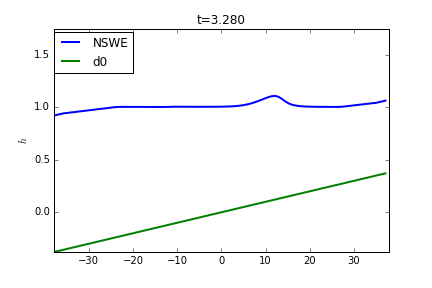
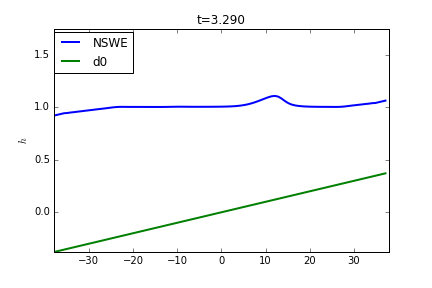
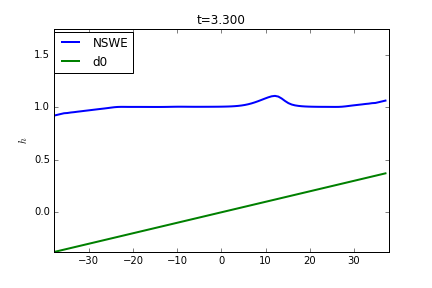
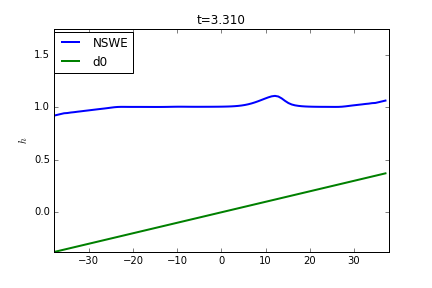
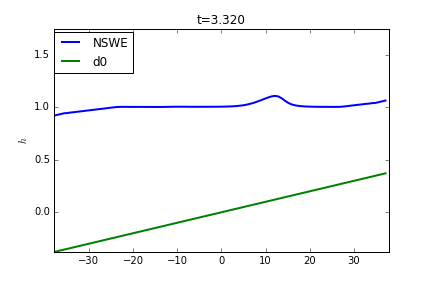
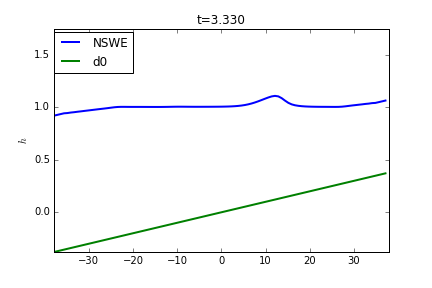
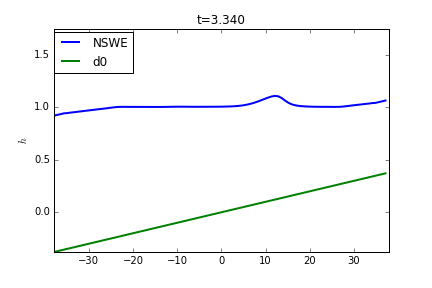
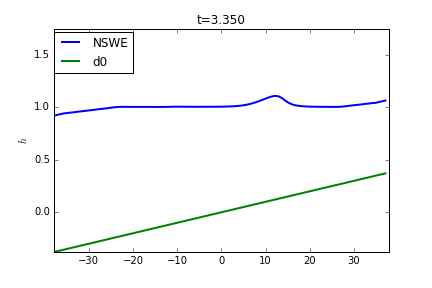
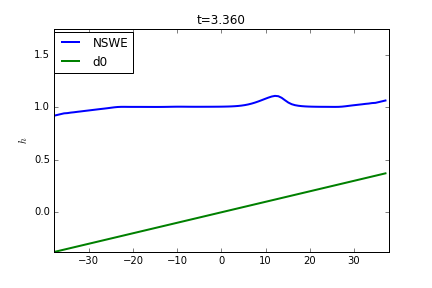
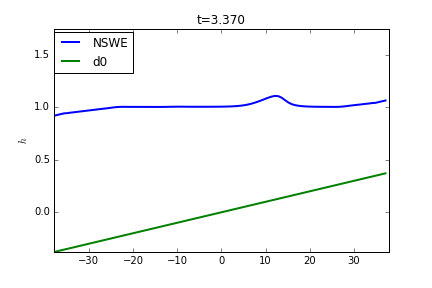
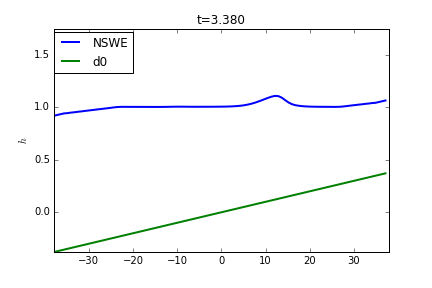
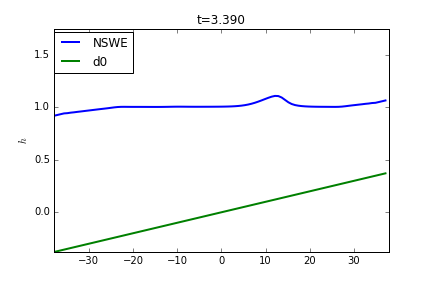
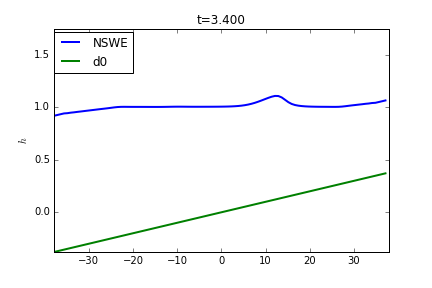
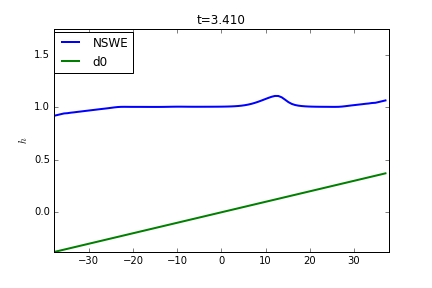
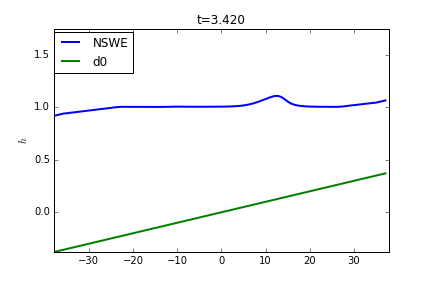
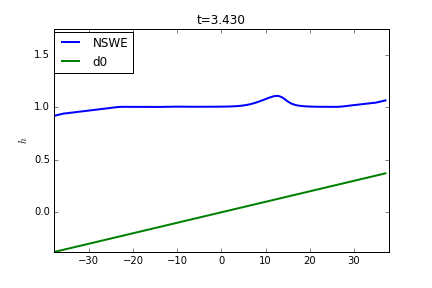
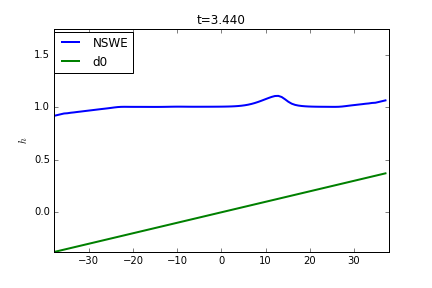
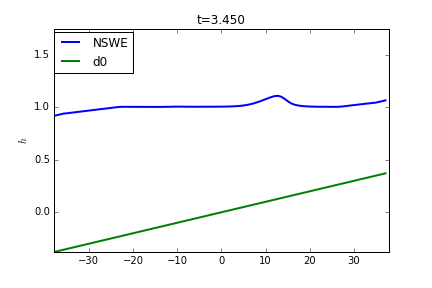
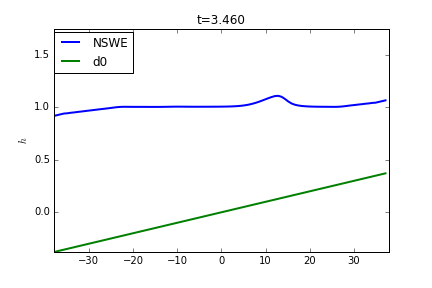
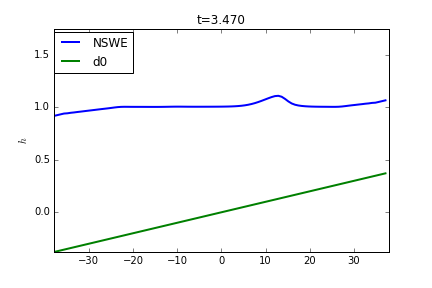
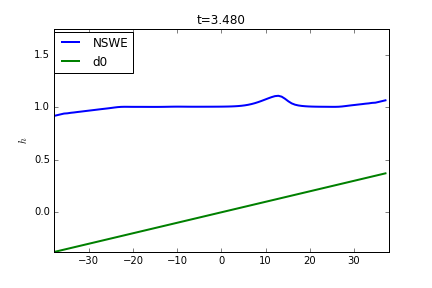
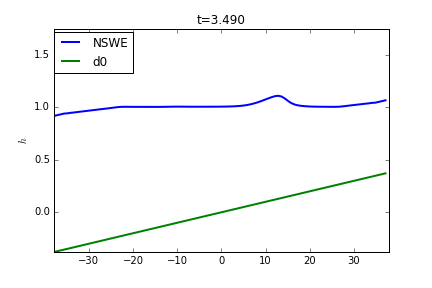
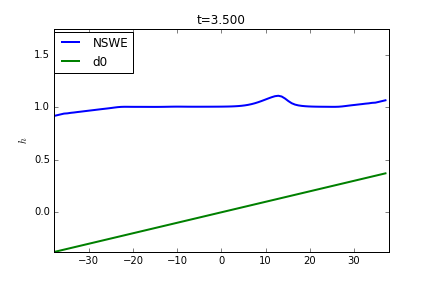
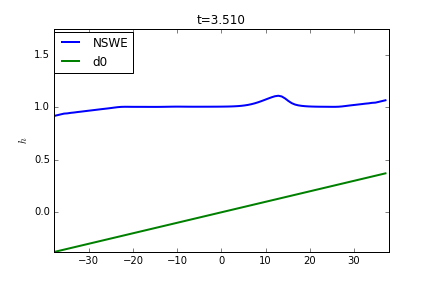
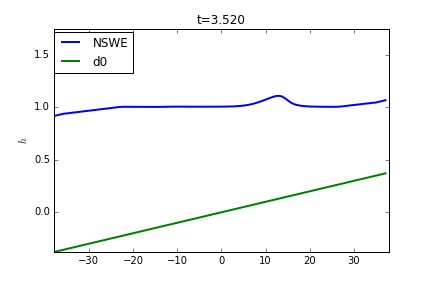
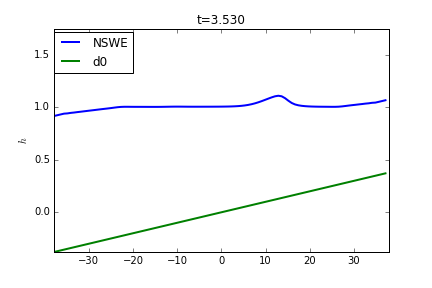
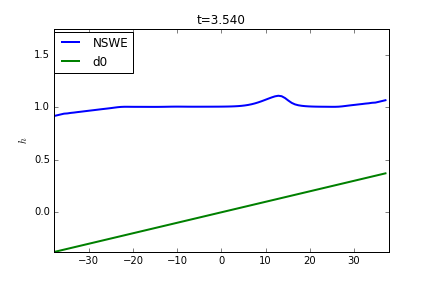
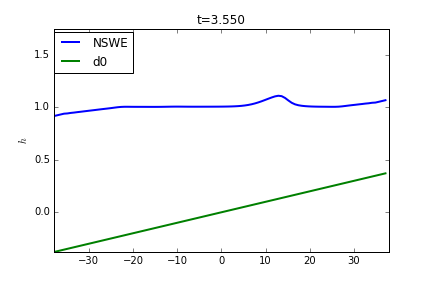
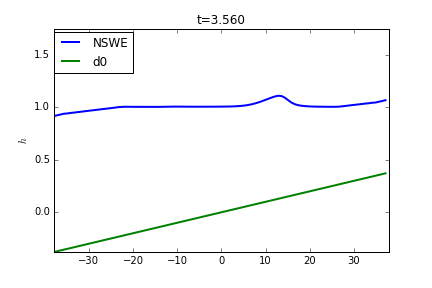
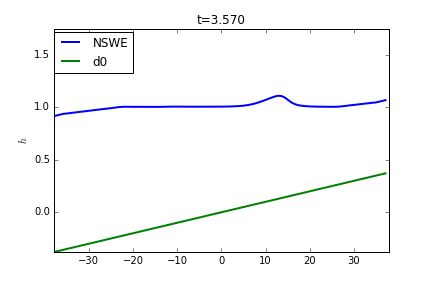
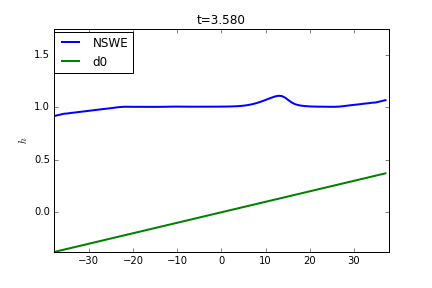
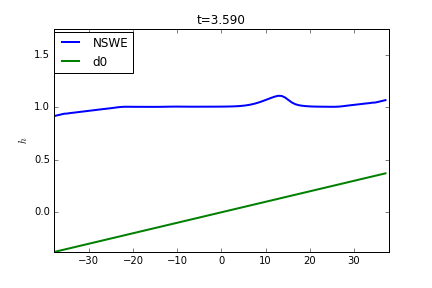
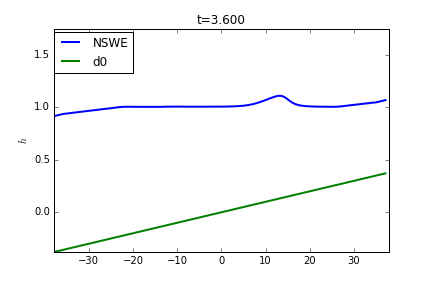
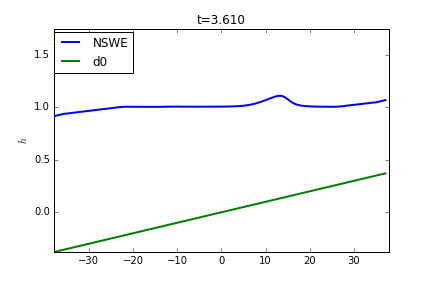
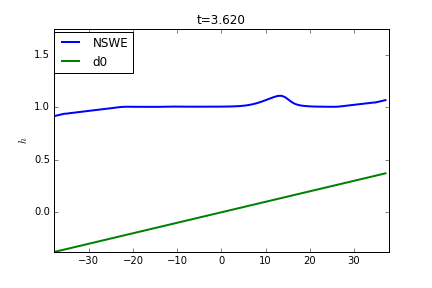
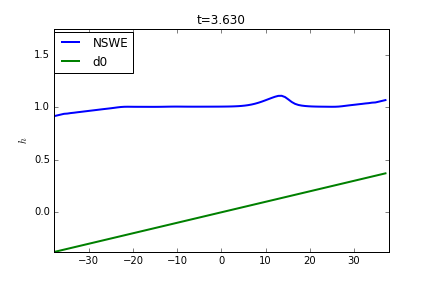
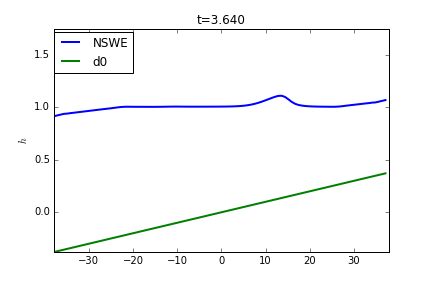
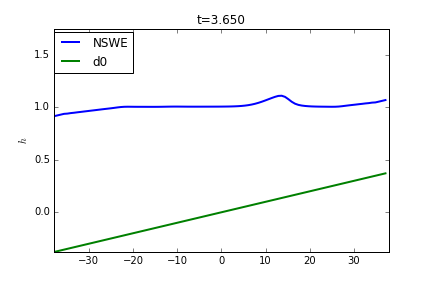
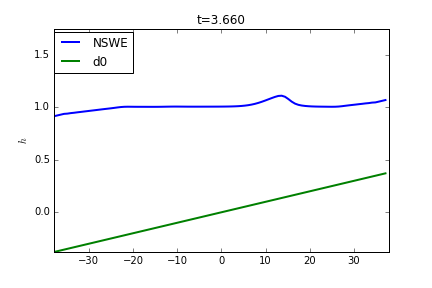
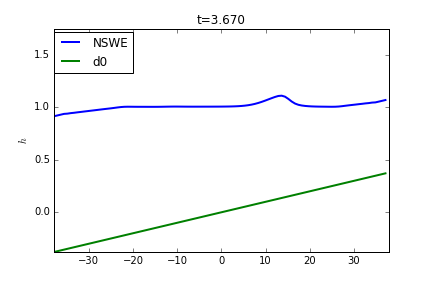
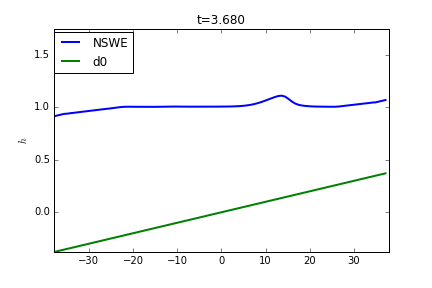
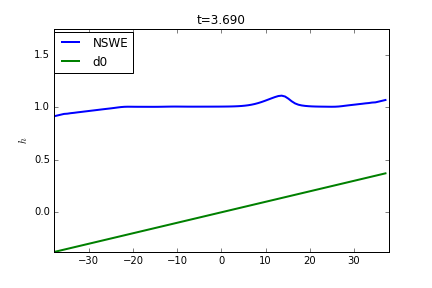
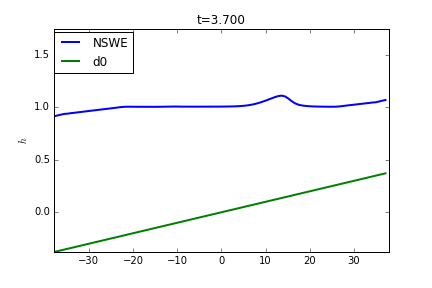
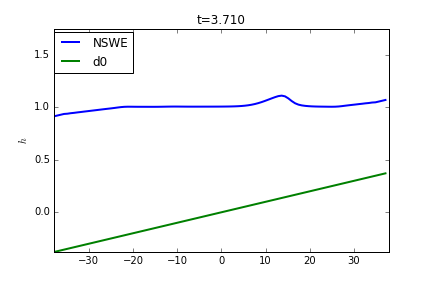
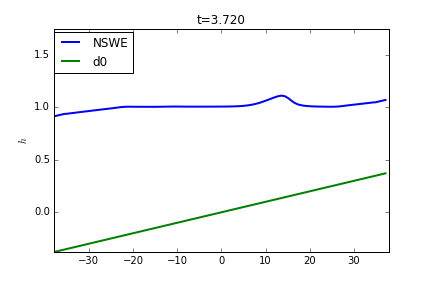
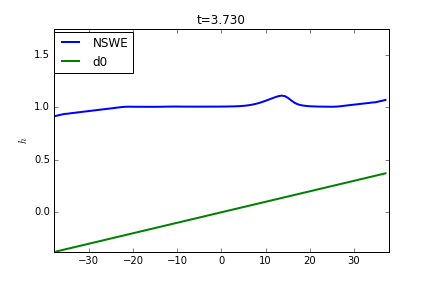
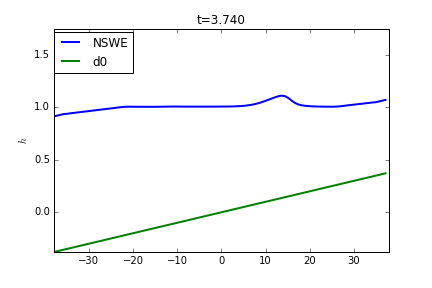
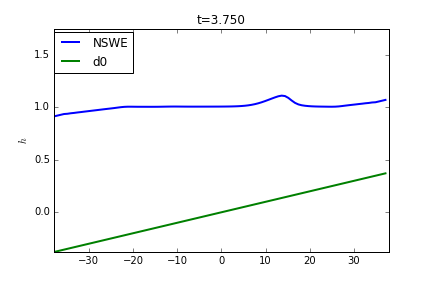
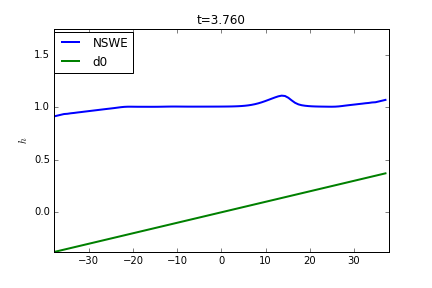
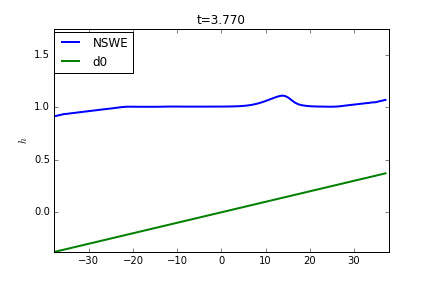
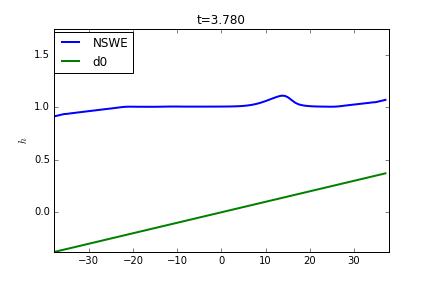
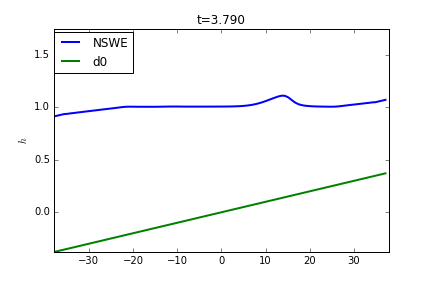
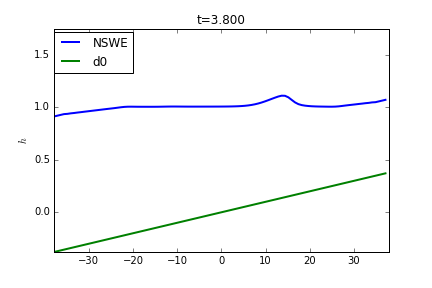
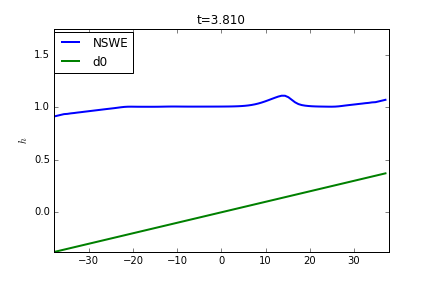
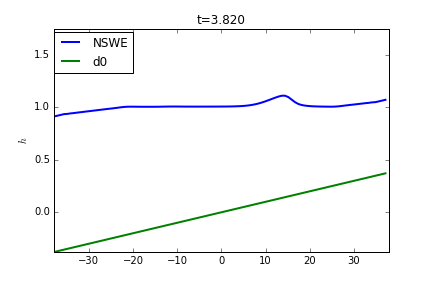
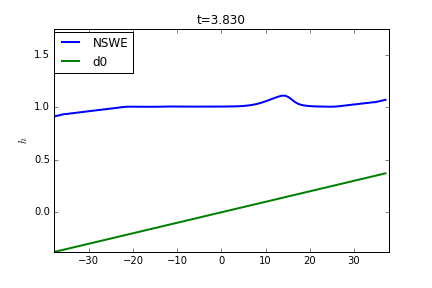
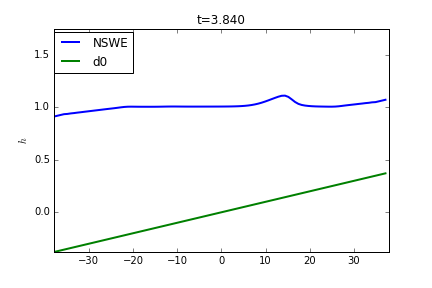
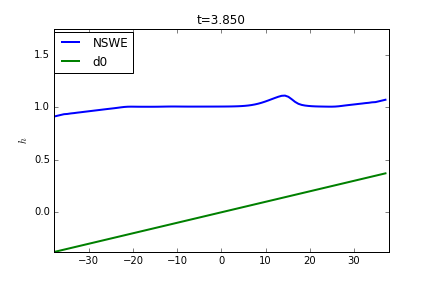
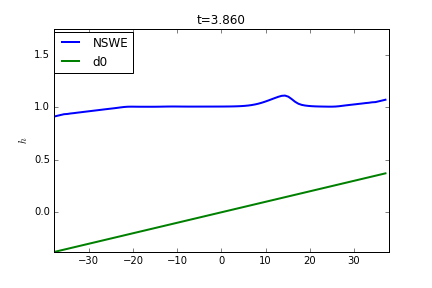
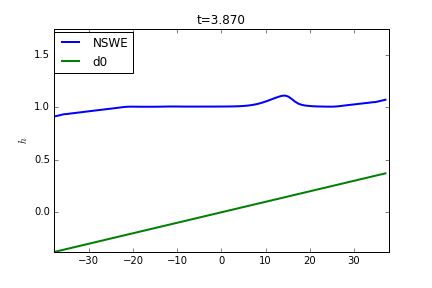
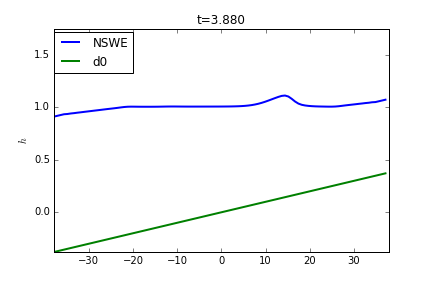
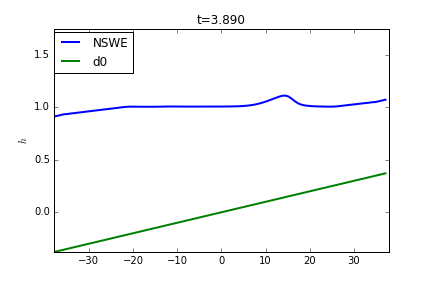
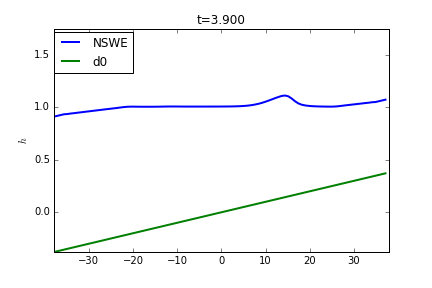
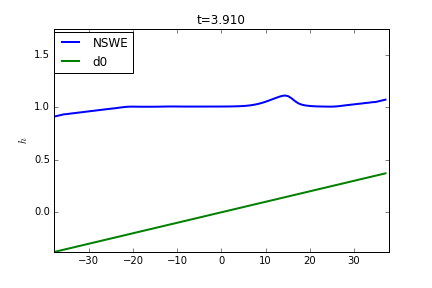
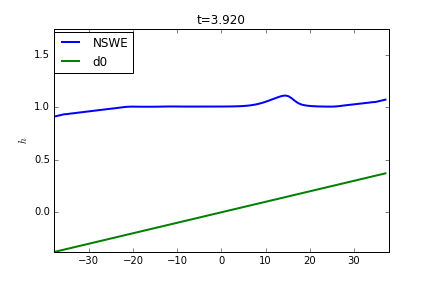
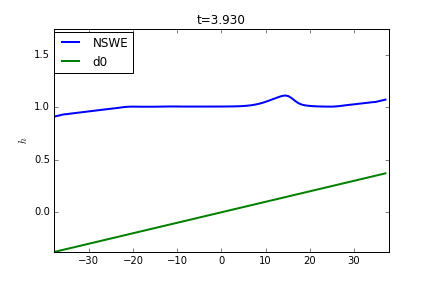
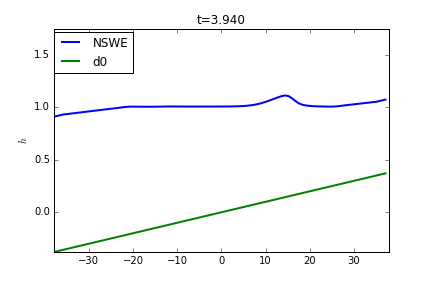
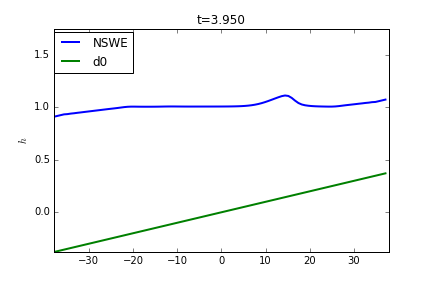
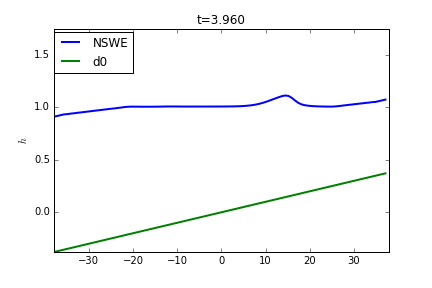
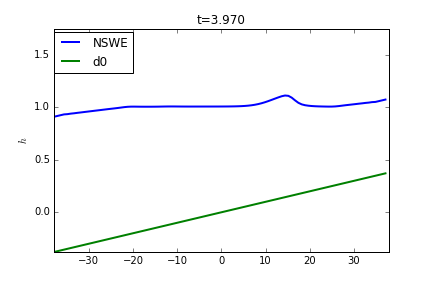
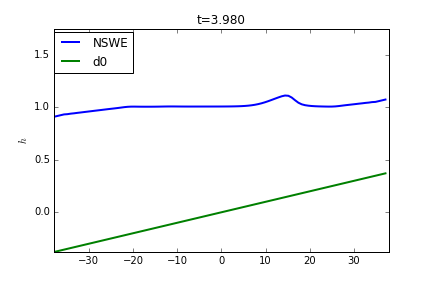
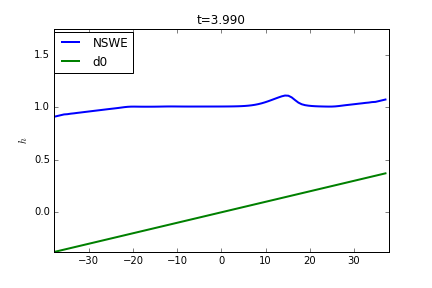
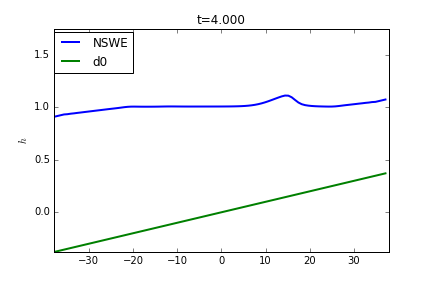
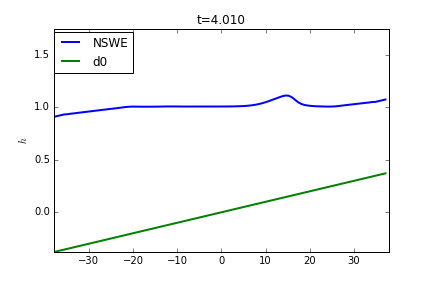
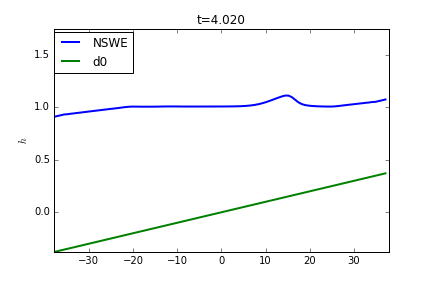
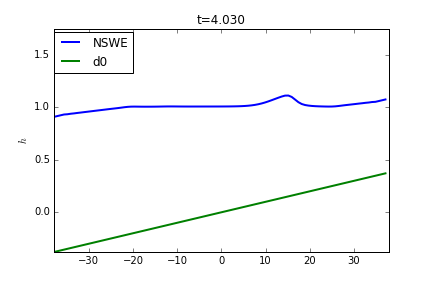
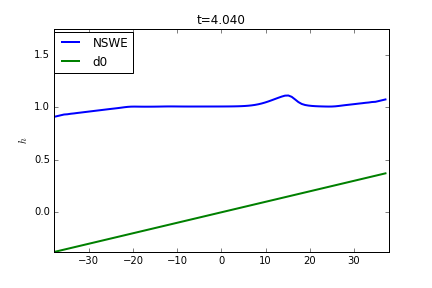
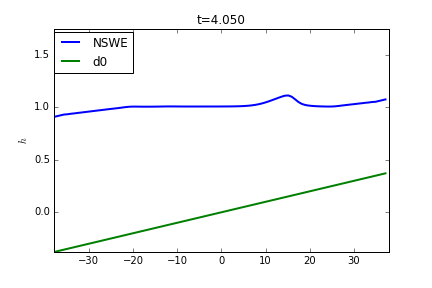
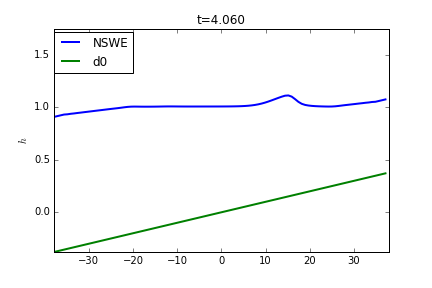
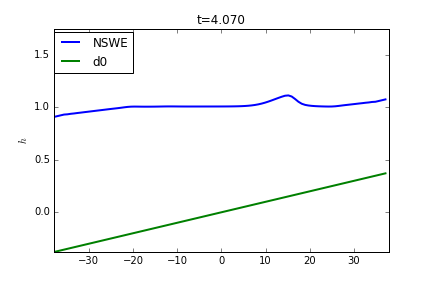
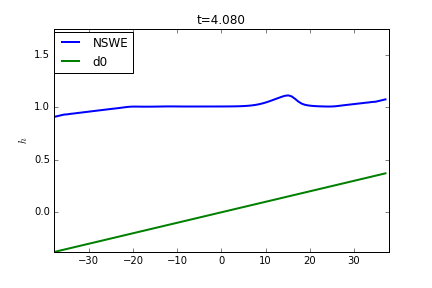
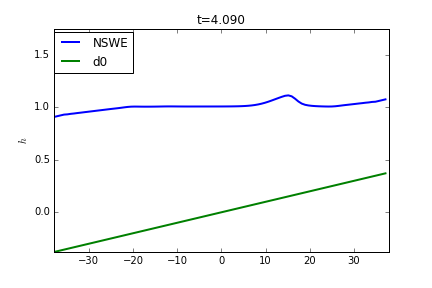
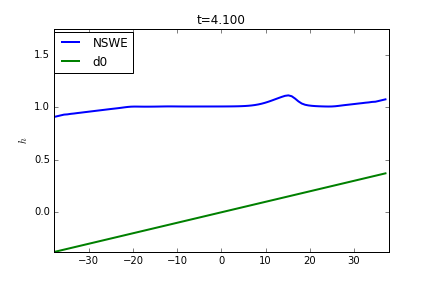
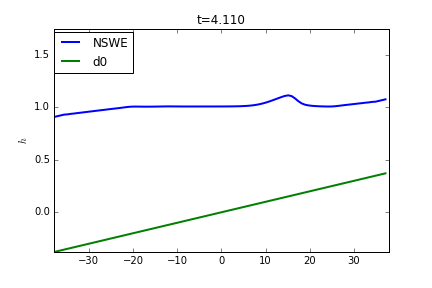
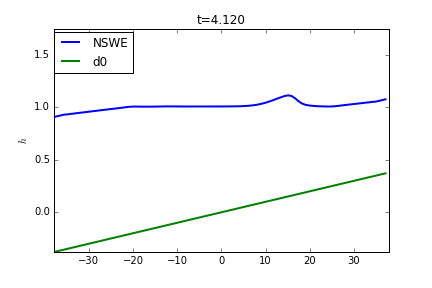
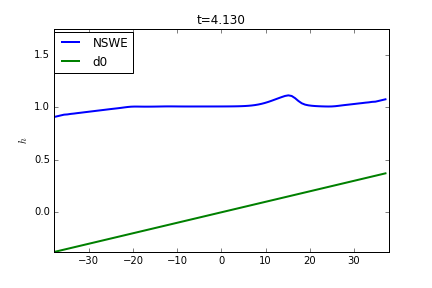
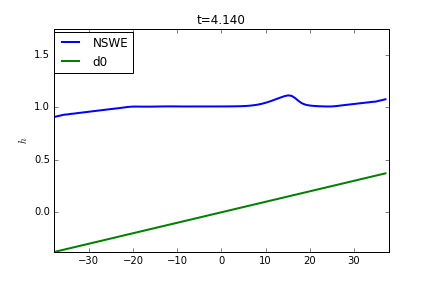
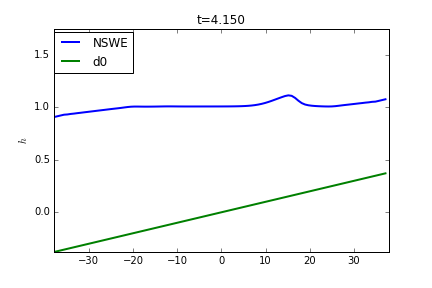
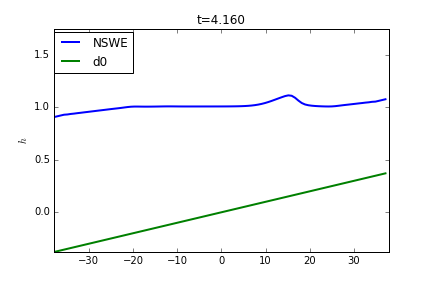
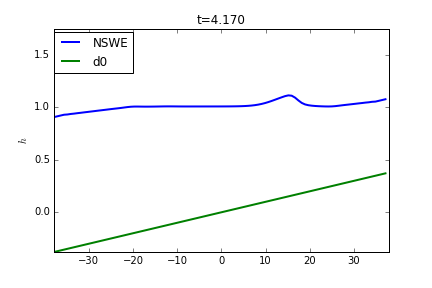
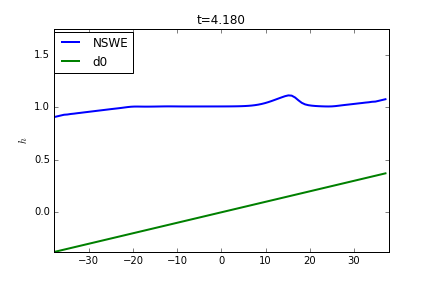
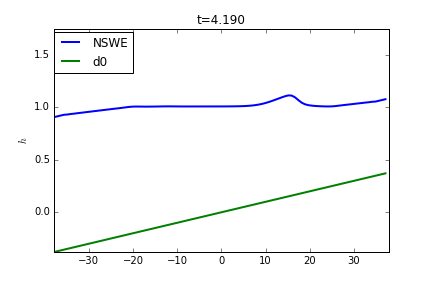
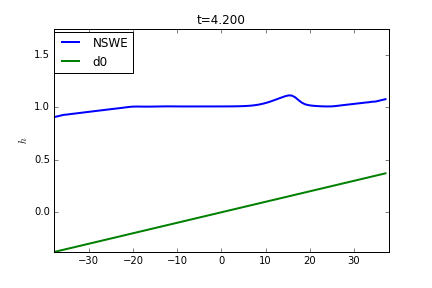
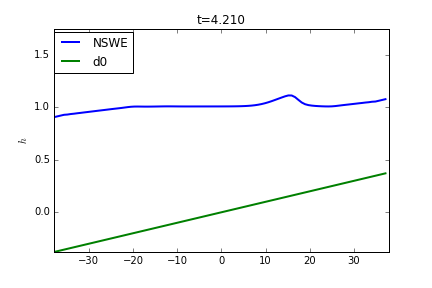
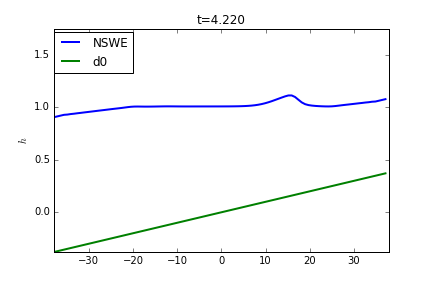
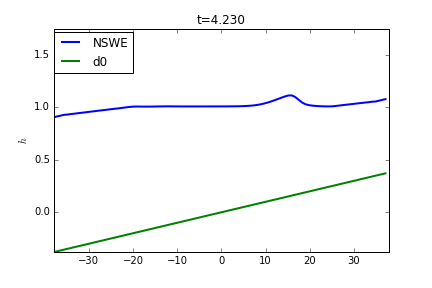
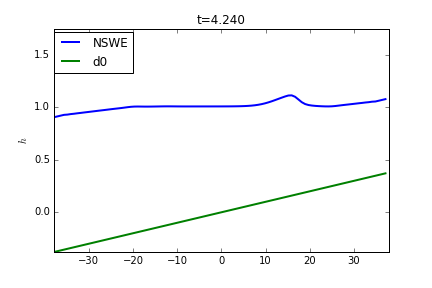
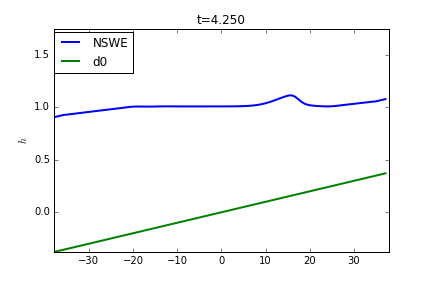
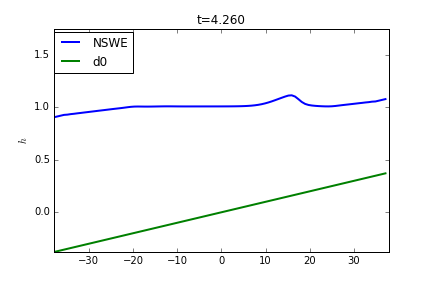
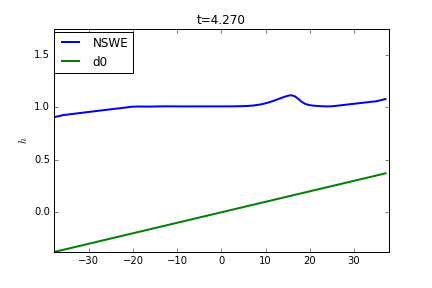
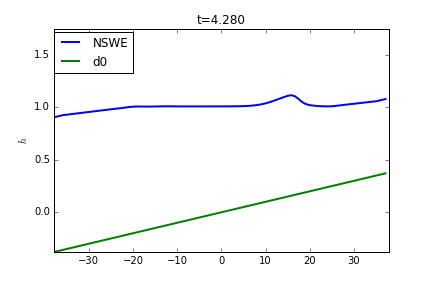
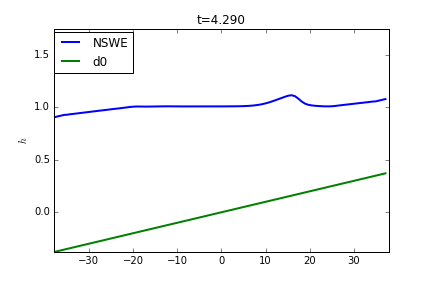
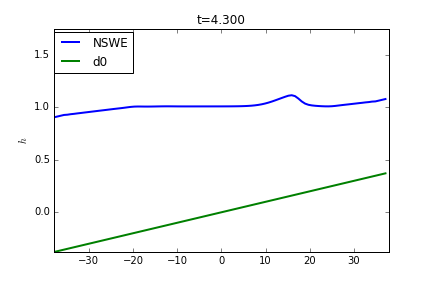
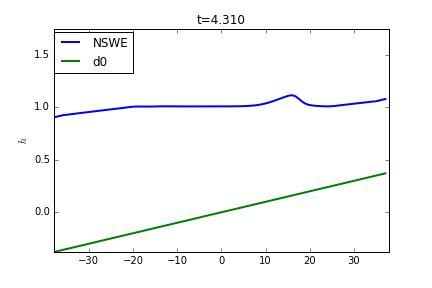
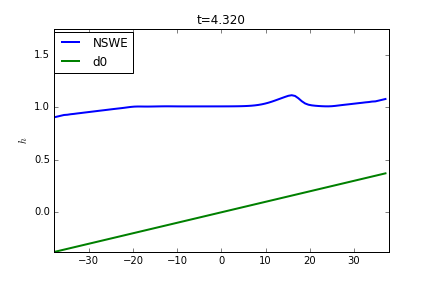
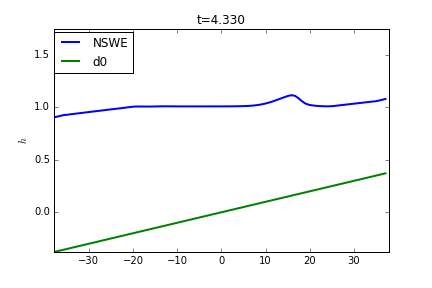
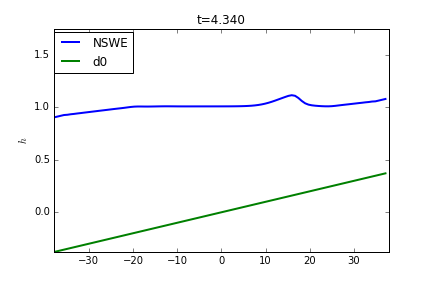
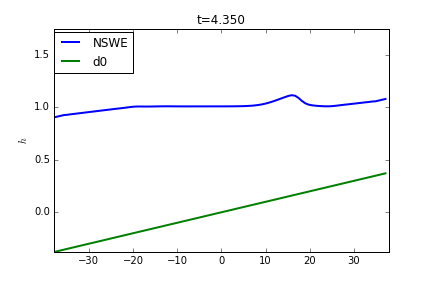
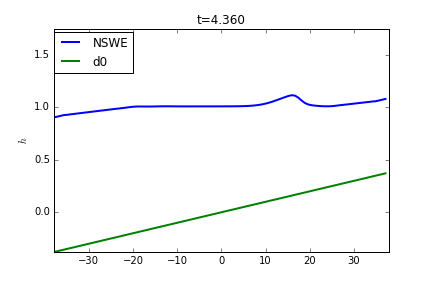
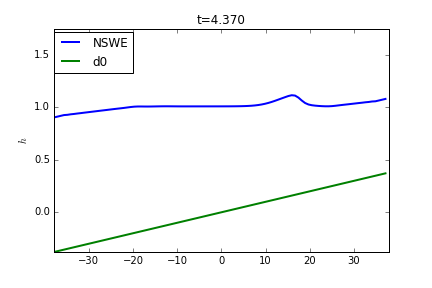
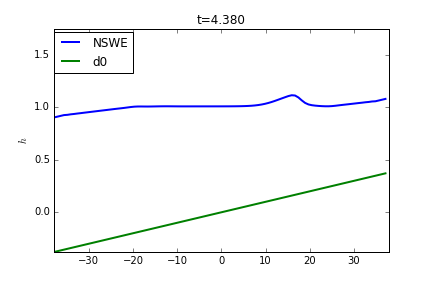
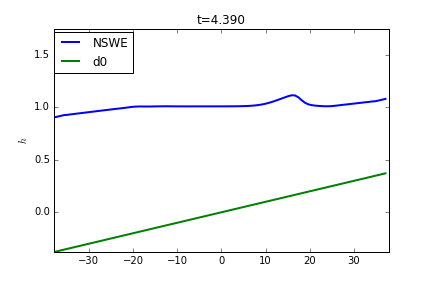
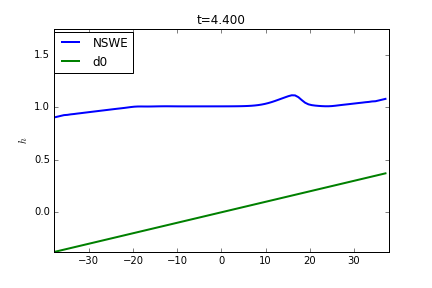
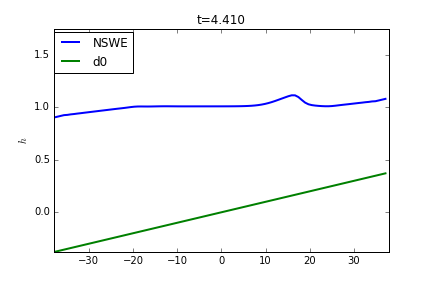
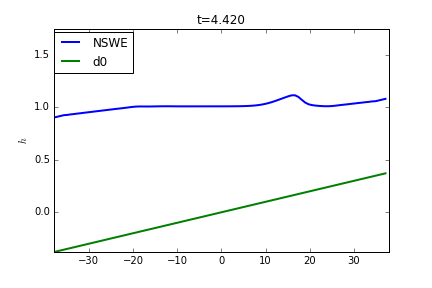
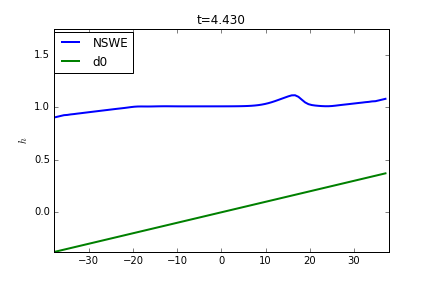
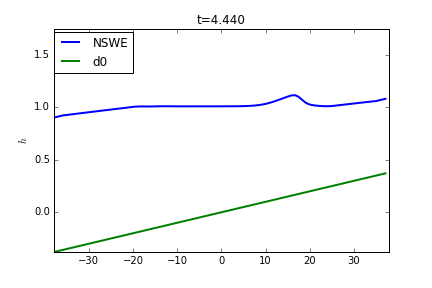
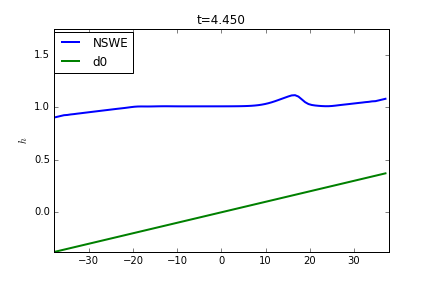
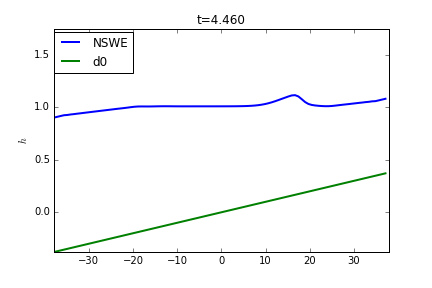
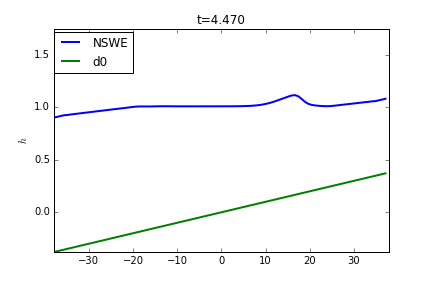
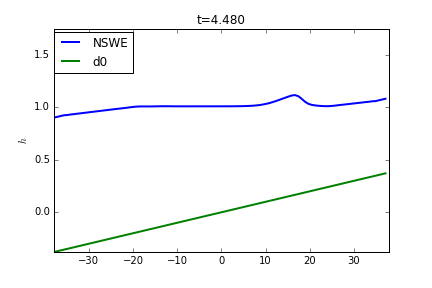
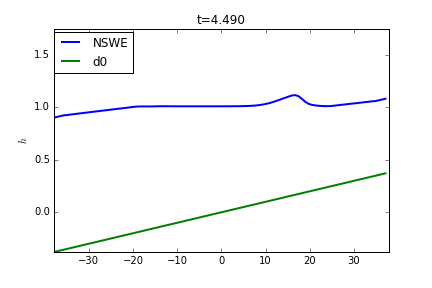
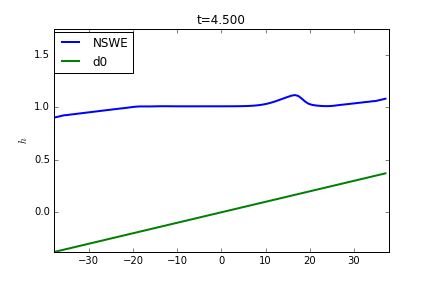
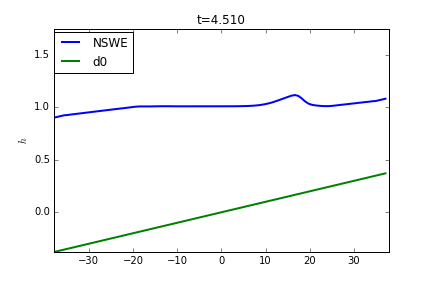
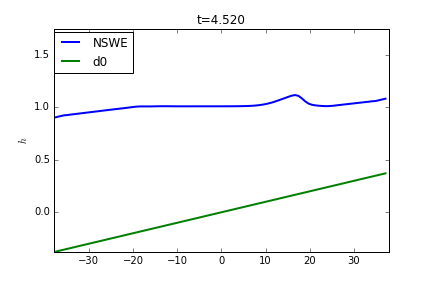
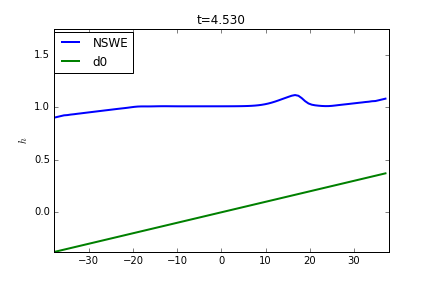
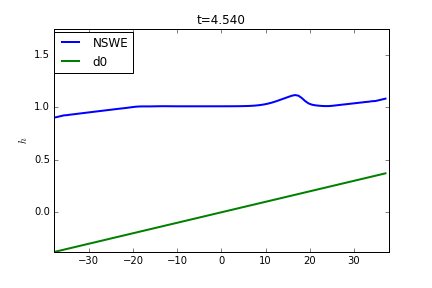
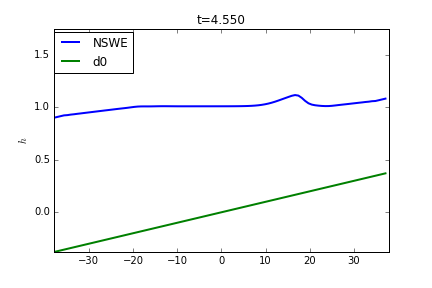
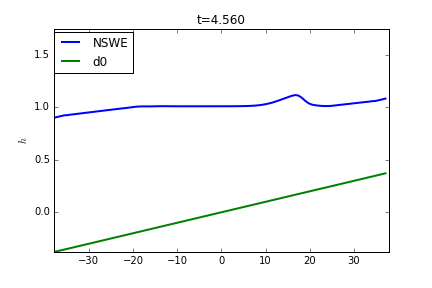
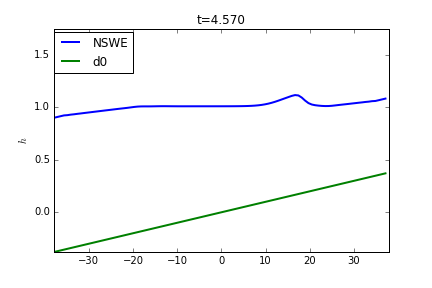
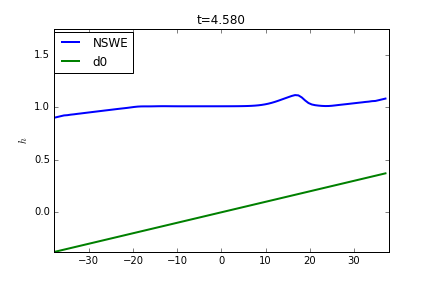
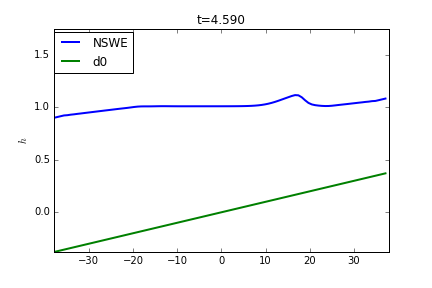
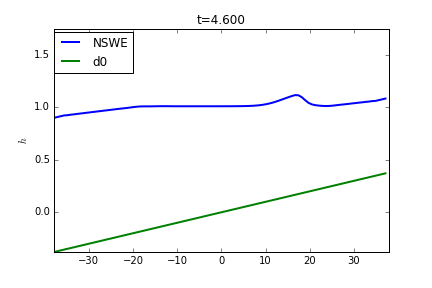
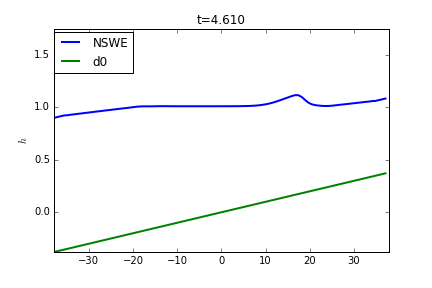
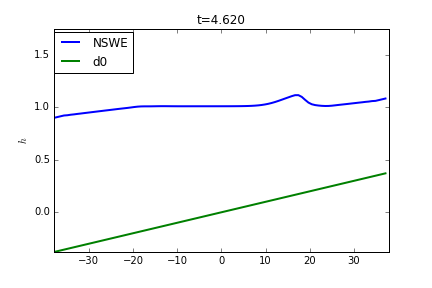
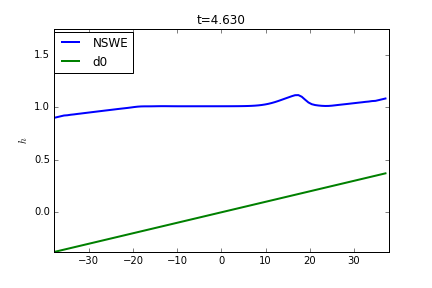
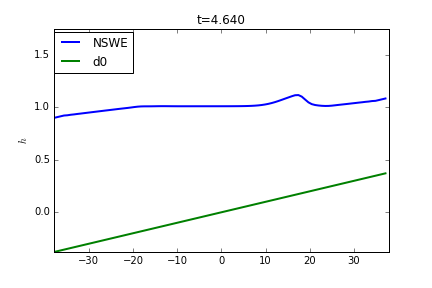
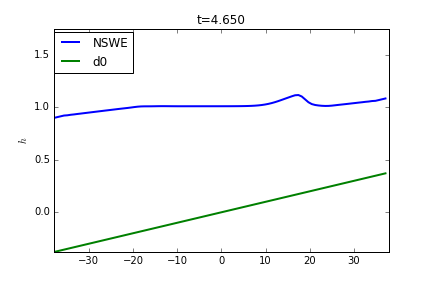
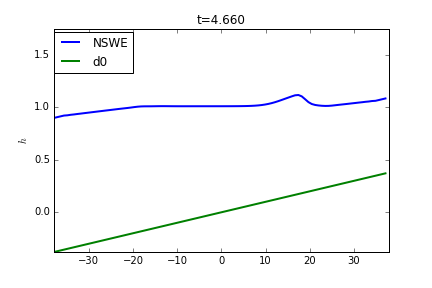
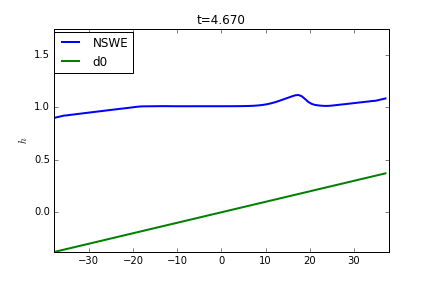
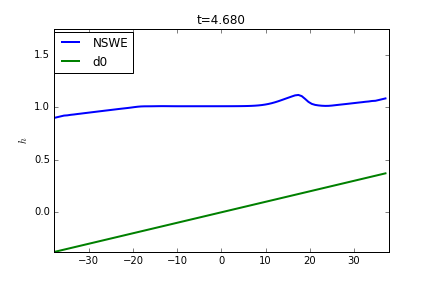
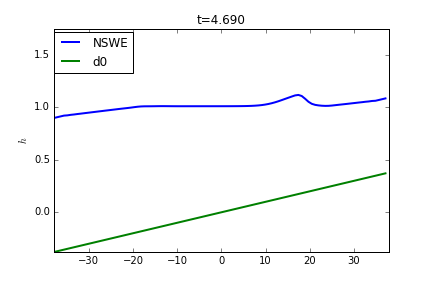
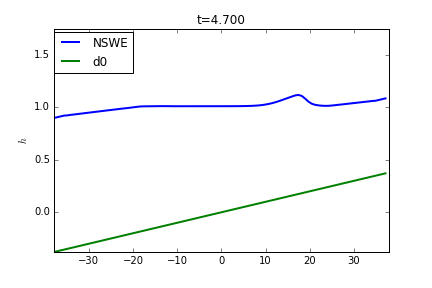
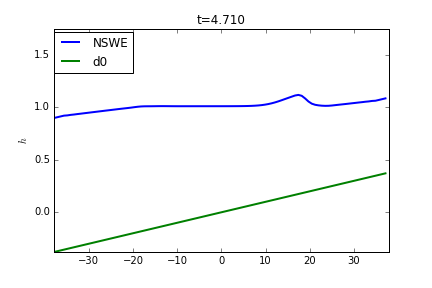
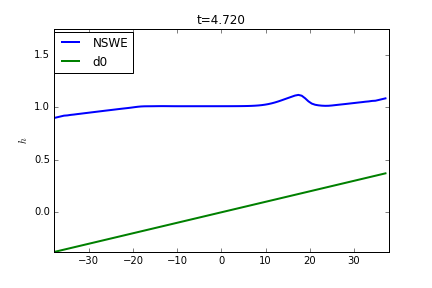
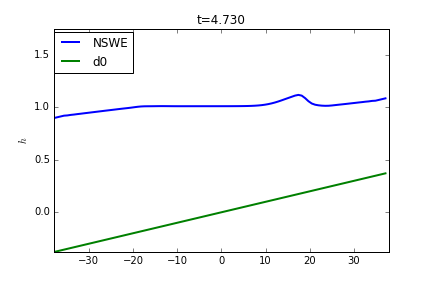
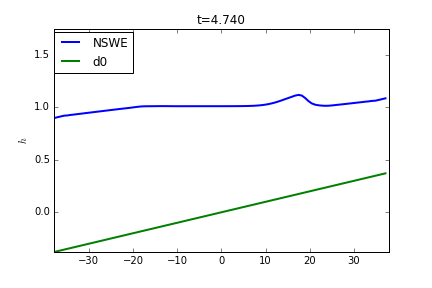
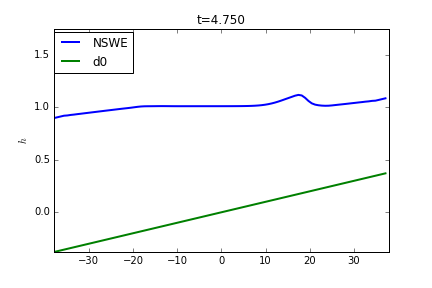
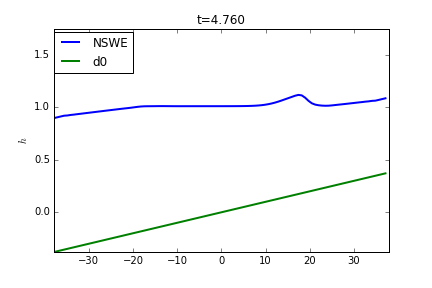
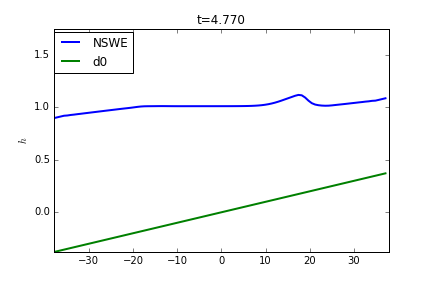
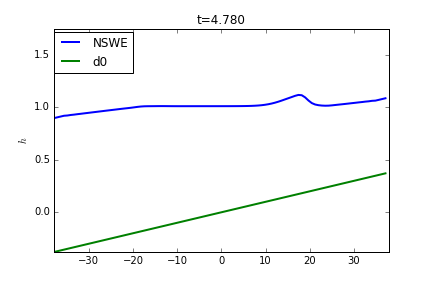
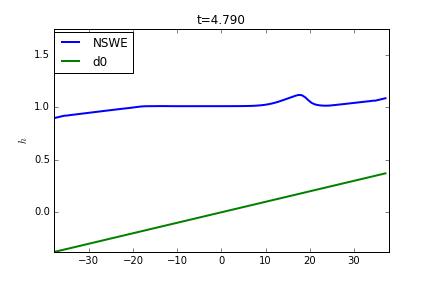
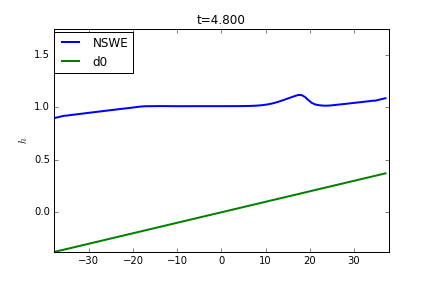
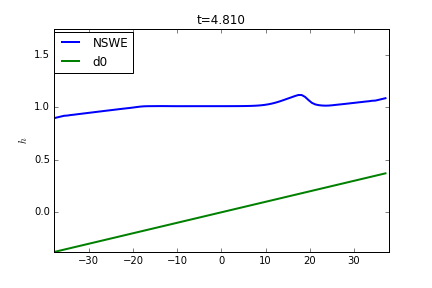
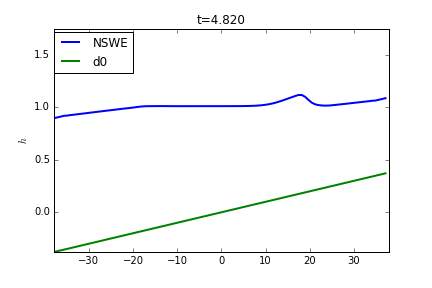
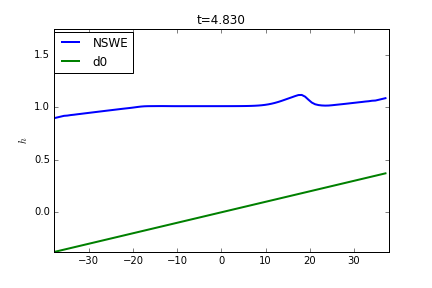
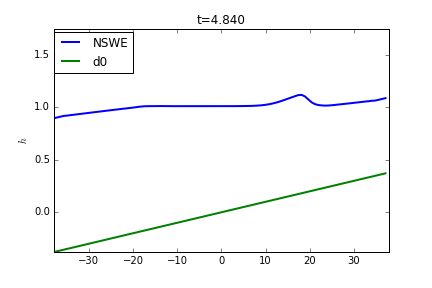
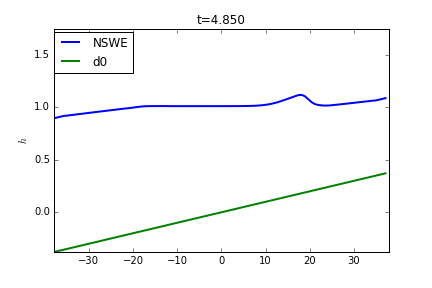
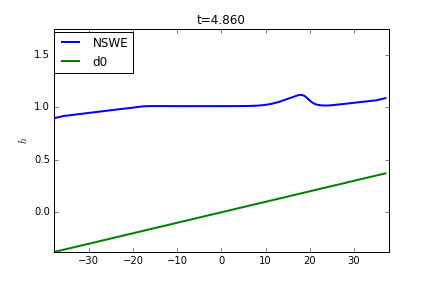
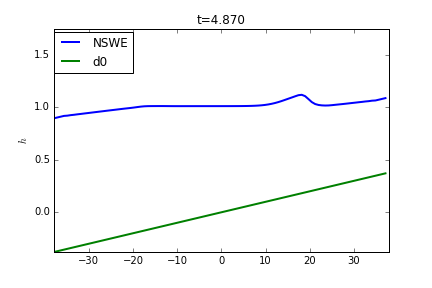
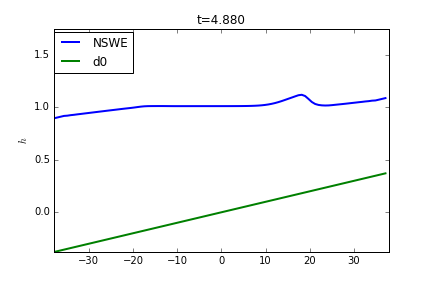
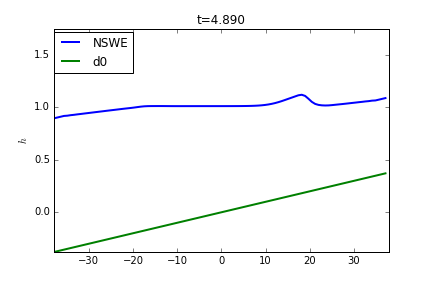
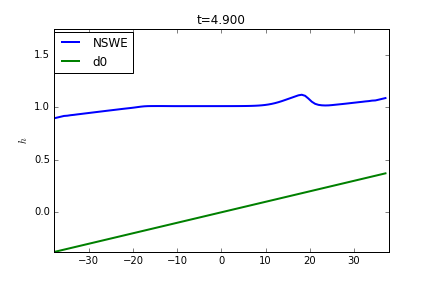
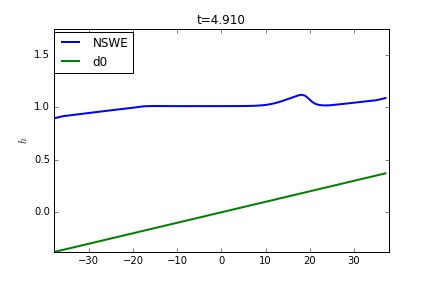
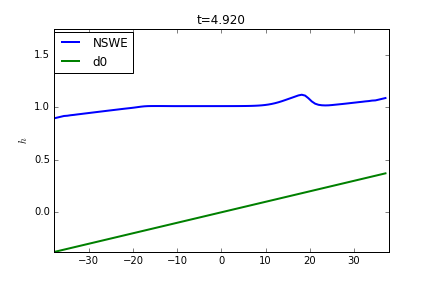
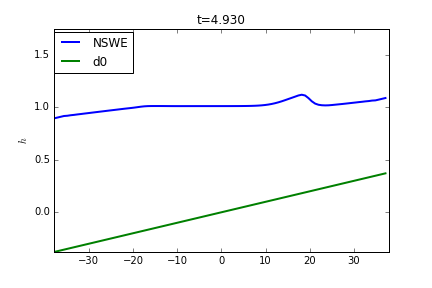
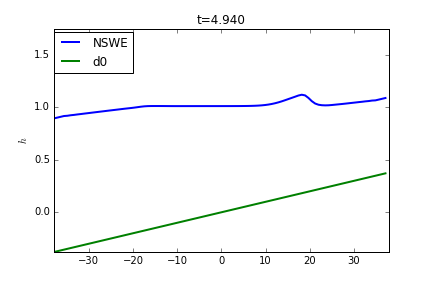
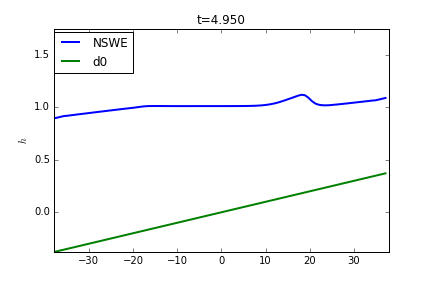
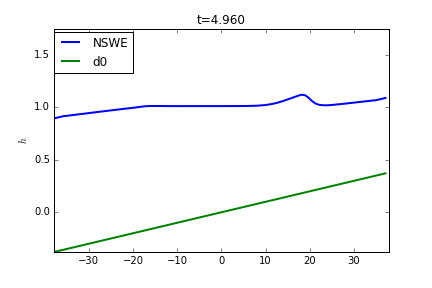
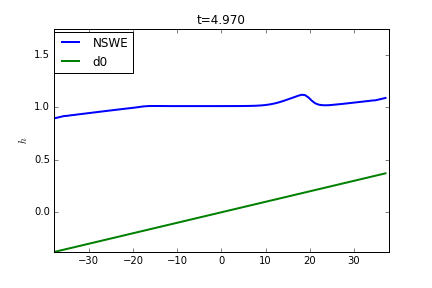
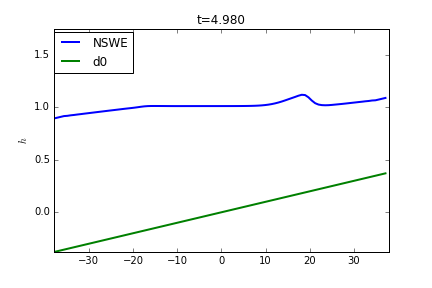
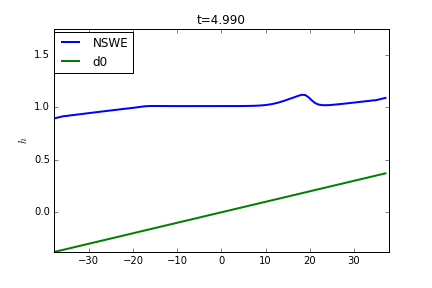
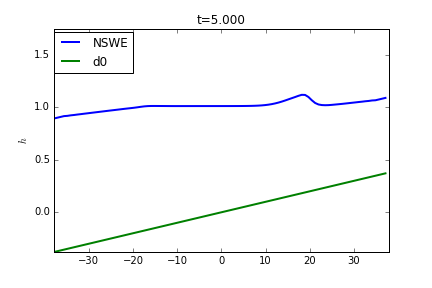
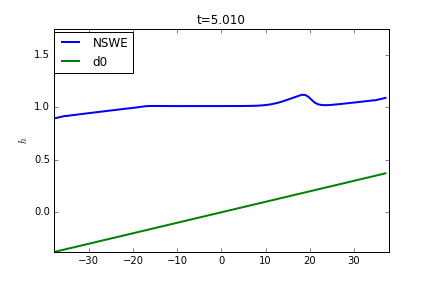

In [13]:
lb = ["NSWE", "d0"]
gF.plotAnimationNSolutions(2,x,np.array([hallP,d0all]),tall,xmin,xmax,d0all[0,0],hmax+np.amax(d0),lb,ylabel=r'$h$',location=(0.,0.8))

## Validation: solitary solution over constant slope (Serre)

In [14]:
reload(serre)

a0 = 1.
a1 = .1
k = 0.
g = 9.81
t0 = 0.0
t = t0
tmax = 2.

lam, h0 = cnoidal.WaveLengthDepth(k,a0,a1)

L = 3.*lam
xmin = -L
xmax = L
nx = 100

x,dx = serre.discretizeSpace(xmin,xmax,nx)
dx = np.diff(x)[0]

eta = 0.01
d0 = 0.001 + eta*(x-xmax)
h,u = cnoidal.analyticalSolutionSolitary(x,t,a0,a1)
h = h-d0

BC1=np.array([0.,0.,0.,0.,0.,1.,0.,1.,0.,1.,0.,1.,0.])
BC2=np.array([0.,0.,nan,nan,0.,nan,nan,nan,0,0,0,0.,0.,0,nan,nan])

hall,uall,tall = serre.splitSerre(x,h,u,t0,tmax,openDomainThreeGC,
                                     serre.genericOpenDomain2,None,BC2,dx,nx,vardt = False, dt = 0.05,splitSteps=2,
                                     order=4, periodic=False,fvsolver = fluxes, fdsolver = serre.EFDSolverFM4Bottom,
                                     ghostcells=3, fvTimesolver = serre.RK4,eta=eta)
#hall,uall,tall = serre.NSWE(x,h,u,t0,tmax,openDomainThreeGC,None,dx,x.size,vardt = False, dt = 0.01,
#                              fvsolver=fluxes, ghostcells=3,fvTimesolver=serre.Euler)

umin = np.amin(uall)
umax = np.amax(uall)
hmin = np.amin(hall)
hmax = np.amax(hall)

CFL = 0.115207


serre.py:619: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if BCparam != None:


In [15]:
uall2 = np.copy(uall)
hall2 = np.copy(hall)

In [16]:
print(np.linalg.norm(uall-uall2))
print(np.linalg.norm(hall-hall2))



0.0
0.0


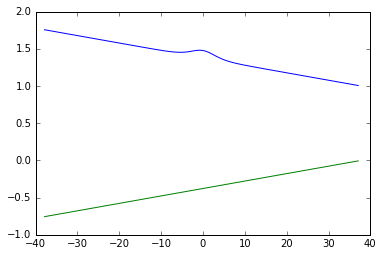

In [17]:
plt.plot(x,h)
plt.plot(x,d0)

In [18]:
hallP = np.copy(hall)
d0all = np.copy(hall)

for i in range (tall.size):
    d0all[:,i] = d0
    hallP[:,i] = hall[:,i] + d0

*** Plotting animation ...



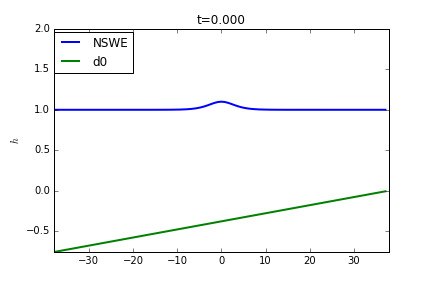
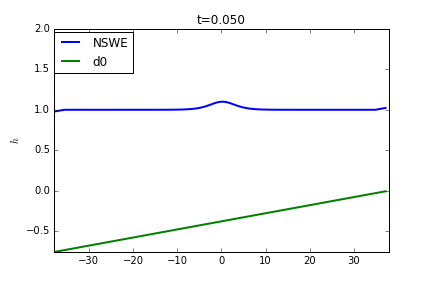
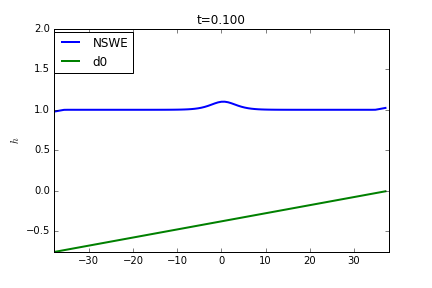
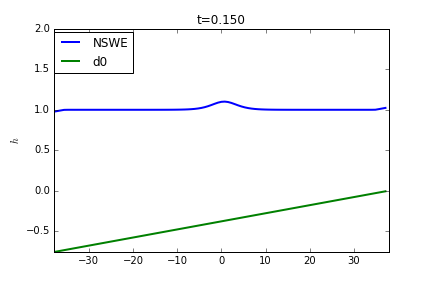
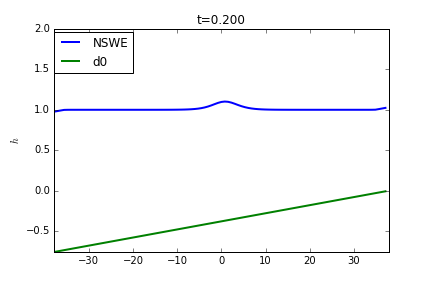
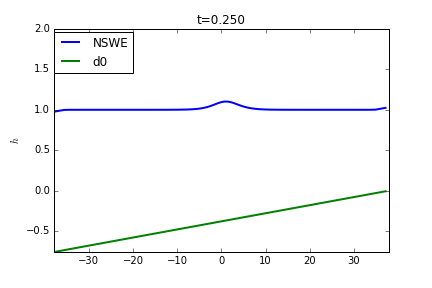
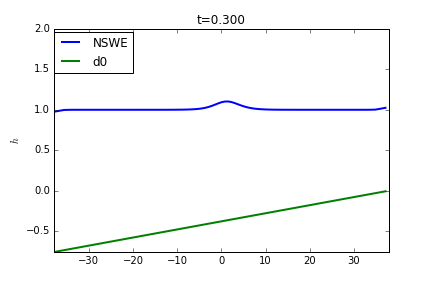
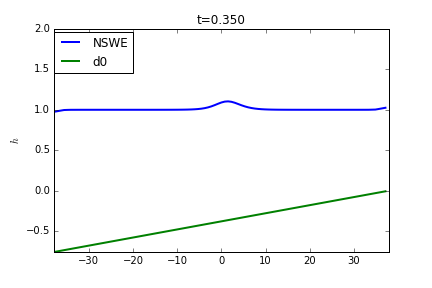
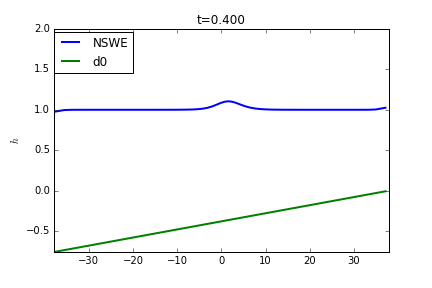
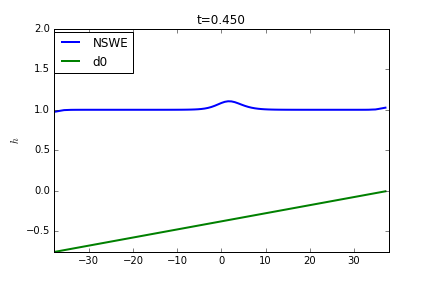
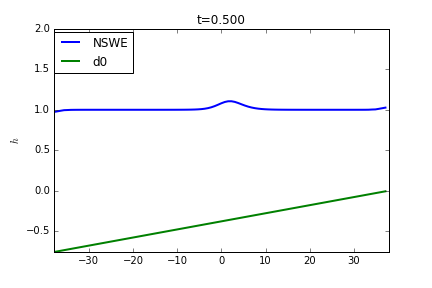
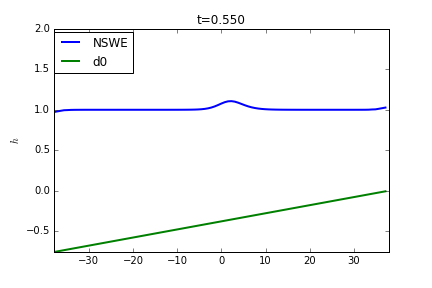
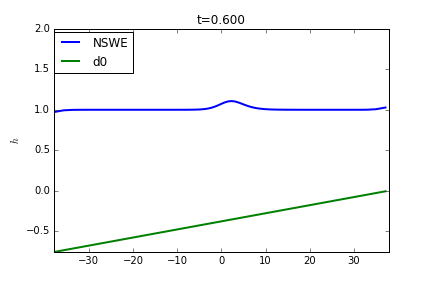
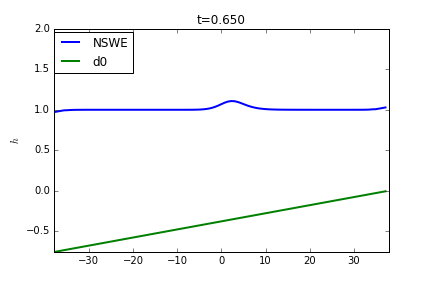
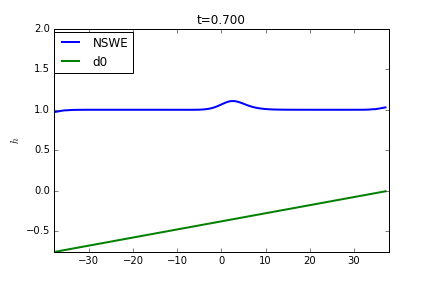
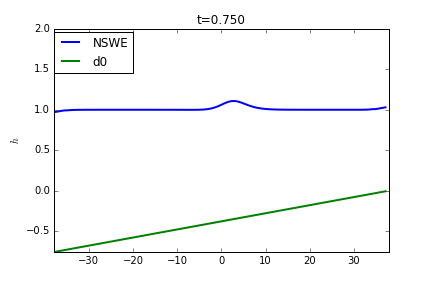
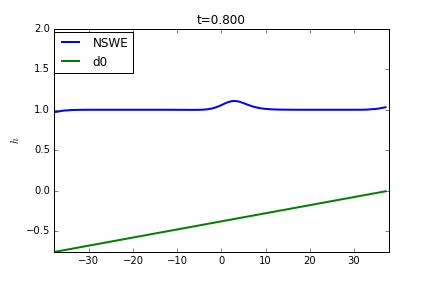
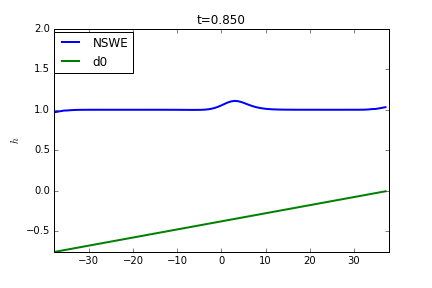
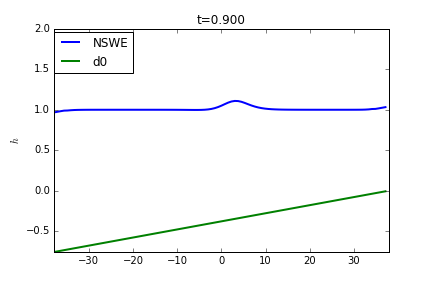
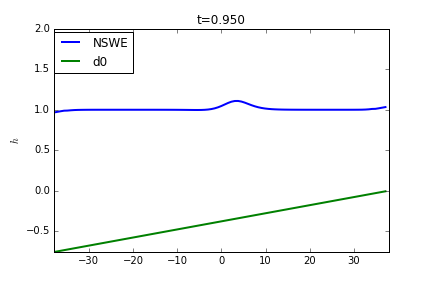
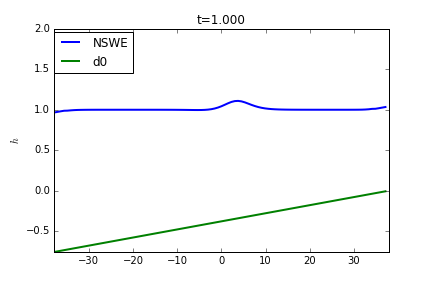
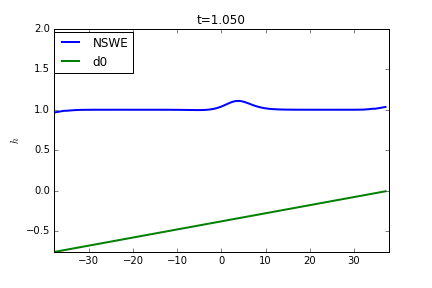
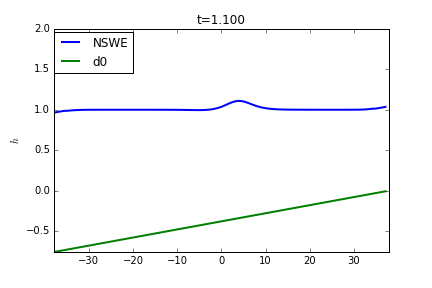
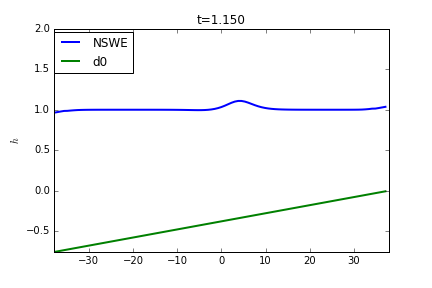
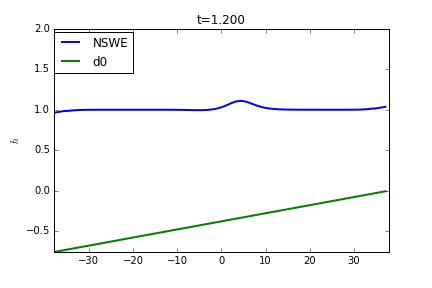
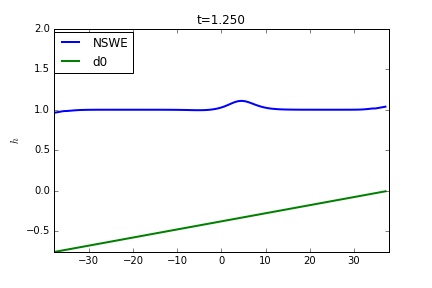
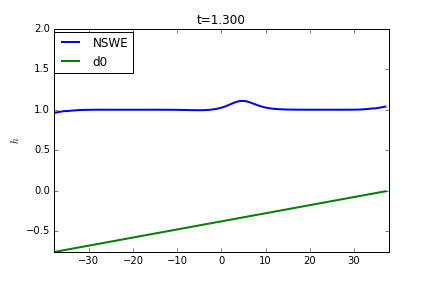
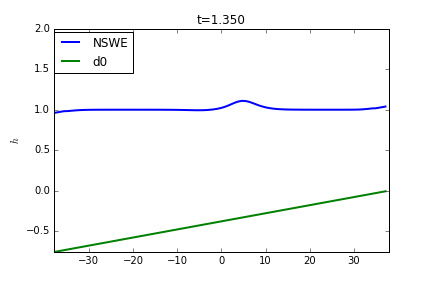
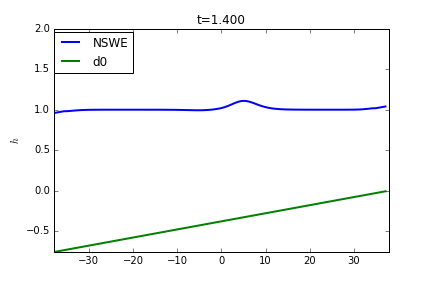
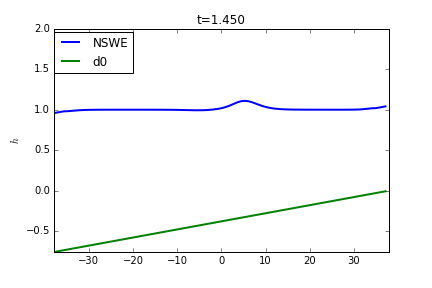
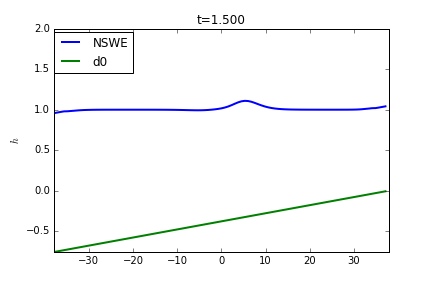
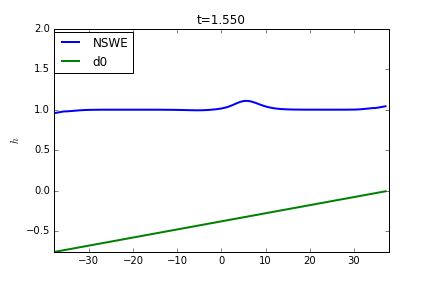
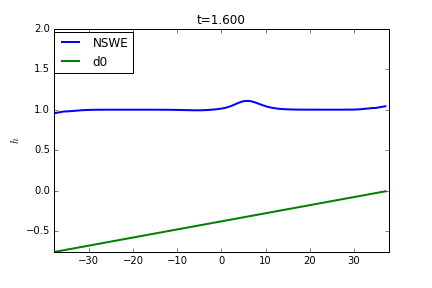
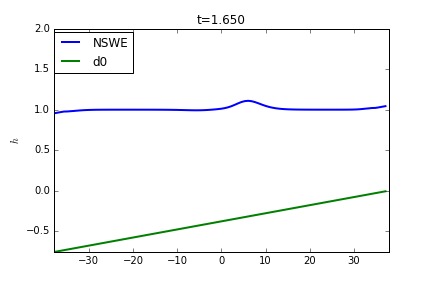
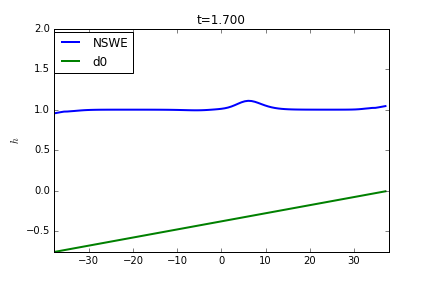
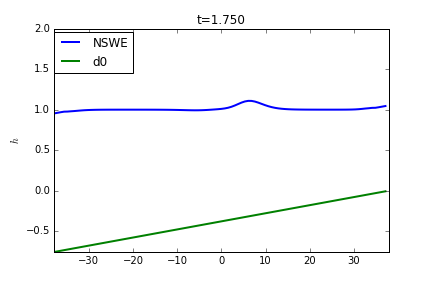
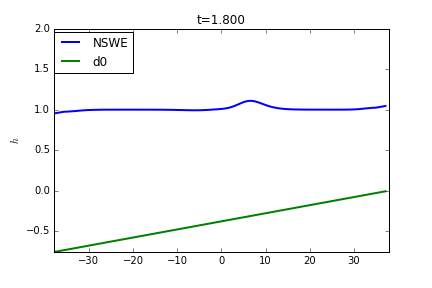
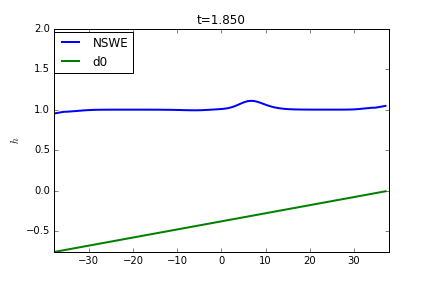
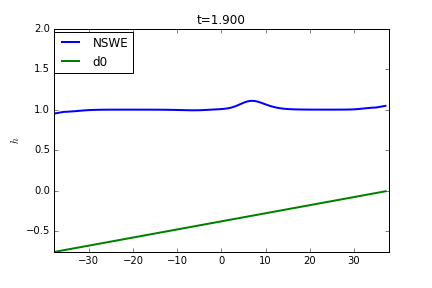
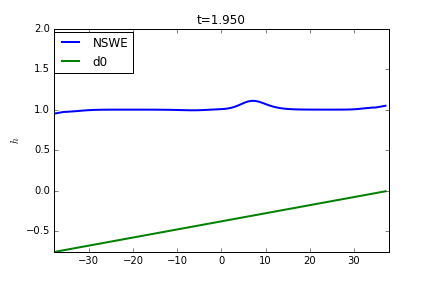
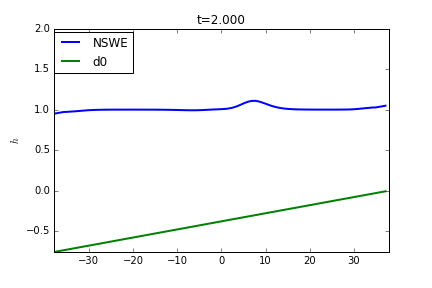

In [19]:
reload(gF)
lb = ["NSWE", "d0"]
gF.plotAnimationNSolutions(2,x,np.array([hallP,d0all]),tall,xmin,xmax,d0all[0,0],2.,lb,ylabel=r'$h$',location=(0.,0.8))